# Grand Theft Auto V Driving learning with Deep Learning (CNN and YOLO)
---
Self driving car in Grand Theft Auto V with Deep Learning and Object Detection. Adapted from
https://github.com/eritzyg/GTAV-Self-driving-car
by Iker Garcia and Eritz Yerga.



### Authors: Evan Miller, Allan Bourke, Joshua Gutowski, and Ian Kraft

See [this README](https://github.com/eritzyg/GTAV-Self-driving-car/blob/master/Notebook/README.md) for info about the notebook and required libraries.

---
## Index:

0. <a href="#0.-Object-Detection">Object Detection</a>
1. <a href="#1.-Generate-dataset">Generate dataset</a>
    * <a href="#Frame-capture-functions">Frame capture functions</a>
    * <a href="#Image-preprocessing-functions">Image preprocess functions</a>
    * <a href="#Game-control-and-input-reading-functions">Game control and input reading functions</a>
    * <b><a href="#Generate-dataset">Generate dataset</a></b>
2. <a href="#2.-Dataset-processing-utilities">Dataset processing utilities</a>
3. <a href="#3.-Define-the-model">Define our model</a>
4. <a href="#4.-Train">Train</a>
5. <a href="#5.-Run-our-model-in-the-game">Run our model in the game</a>

<a href=""></a>

---
First we import the libraries we are going to need to run this notebook.

In [1]:
import sys
sys.path.append(r'C:%APPDATA%\Python\Python38\Scripts')


!pip install opencv-python
!pip install tensorflow --ignore-installed --user

!pip show tensorflow

  Using cached tensorflow-2.4.1-cp38-cp38-win_amd64.whl (370.7 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: After October 2020 you may experience errors when installing or u

  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached tensorboard-2.4.1-py3-none-any.whl (10.6 MB)
  Using cached numpy-1.19.5-cp38-cp38-win_amd64.whl (13.3 MB)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Using cached grpcio-1.32.0-cp38-cp38-win_amd64.whl (2.6 MB)
  Using cached protobuf-3.14.0-py2.py3-none-any.whl (173 kB)
  Using cached tensorflow_estimator-2.4.0-py2.py3-none-any.whl (462 kB)
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached wheel-0.36.2-py2.py3-none-any.whl (35 kB)
  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
Processing c:\users\simulator\appdata\local\pip\cache\wheels\5f\fd\9e\b6cf5890494cb8ef0b5eaff72e5d55a70fb56316007d6dfe73\wrapt-1.12.1-py3-none-any.whl
  Using cached h5py-2.10.0-cp38-cp38-win_amd64.wh

In [2]:
import numpy as np
from PIL import ImageGrab
import cv2 
import time
from sys import stdout
from IPython.display import clear_output
import os
from grabber import Grabber
import threading
import matplotlib.pyplot as plt
from collections import Counter
from random import shuffle
import glob
import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import TimeDistributed, LSTM, Flatten, Dense, InputLayer, MaxPooling2D, Dropout, Activation, Embedding, GRU, ConvLSTM2D, concatenate
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras import initializers
import h5py
import log
from heapq import nlargest

In [3]:
# Gets an array of filepaths to images from a folder

def loadImages(path):
    # Put files into lists and return them as one list of size 4
    image_files = sorted([os.path.join(path, 'train', file)
         for file in os.listdir(path + "/train") if      file.endswith('.png')])
 
    return image_files

# 0. Object Detection
By Evan Miller

This section utilizes the Yolov3 object detection model with pretrained weights for driving created by Lavanya Shukla on Kaggle. https://www.kaggle.com/lavanyashukla01/yolov3-lyft-dataset/?select=model.h5 

In [4]:
# Loads the model from the file
obj_model = load_model('yolo.h5', compile=False)

In [5]:
#By Lavanya Shukla on Kaggle.

#Custom class for functionality needed to extract bounding boxes from the YOLO model

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
 
        return self.score
 
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def _softmax(x, axis=-1):
    x = x - np.amax(x, axis, keepdims=True)
    e_x = np.exp(x)
    
    return e_x / e_x.sum(axis, keepdims=True)
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5

    boxes = []

    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4]   = _sigmoid(netout[..., 4])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i // grid_w
        col = i % grid_w
        
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[row, col, b, 4]
            
            if(objectness <= obj_thresh): continue
            
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[row,col,b,:4]

            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height  
            
            # last elements are class probabilities
            classes = netout[row,col,b,5:]
            
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)

            boxes.append(box)

    return boxes

#TODO: Expanding boxes outside the range of the original image
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h
        
    i=0
    while i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
        
        
        #TODO: Fails to reset coordinates
        if boxes[i].xmin < 0:
            boxes[i].xmin = 0
            i = i+1
        elif boxes[i].ymin < 0:
            boxes[i].ymin = 0
            i = i+1
        elif boxes[i].xmax < 0:
            boxes.pop(i)
        elif boxes[i].ymax < 0:
            boxes.pop(i)
        elif boxes[i].xmin >= image_w:
            boxes.pop(i)
        elif boxes[i].ymin >= image_h:
            boxes.pop(i)
        elif boxes[i].xmax >= image_w:
            boxes[i].xmax = image_w - 1
            i = i+1
        elif boxes[i].ymax >= image_h:
            boxes[i].ymax = image_h - 1
            i = i+1
        else:
            i = i+1
        #print(boxes[i].xmin, boxes[i].ymin, boxes[i].xmax, boxes[i].ymax)
        

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union

def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
        
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='white')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='white')
    # show the plot
    pyplot.show()

In [6]:
#Takes a normalized rgb image file and returns a tuple of two image arrays. The first has the objects and the second has everything else.
#Adapted from Lavanya Shukla on Kaggle. Written by Evan Miller.

# VERSION 1: KEPT FOR DEBUGGING PURPOSES. DELETE WHEN FINISHED!

def get_sub_images(imagepath):
    #get image size and model paramaters
    WIDTH, HEIGHT = 416,416
    anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
    class_threshold = 0.3
    
    #load original image
    image = load_img(filename)
    width, height = image.size
    IMAGE = img_to_array(image)
    
    # load the image with the required size
    image = load_img(filename, target_size=(WIDTH,HEIGHT))
    
    # convert to numpy array
    image = img_to_array(image)
    
    #normalize image and add a dimension
    image = image.astype('float32')
    image /= 255.0
    image = expand_dims(image, 0)
    
    yhat = obj_model.predict(image)
    
    # Create boxes
    boxes = list()
    for i in range(len(yhat)):
        # decode the output of the network
        boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, HEIGHT, WIDTH)
    
    # correct the sizes of the bounding boxes for the shape of the image
    correct_yolo_boxes(boxes, height, width, HEIGHT, WIDTH)
    
    # suppress non-maximal boxes
    do_nms(boxes, 0.5)
    
    # get the details of the detected objects
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
    
    objects = np.zeros_like(IMAGE)
    background = IMAGE[:]
    
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # Loop over area of each box
        for i in range(x1,x2):
            for j in range(y1,y2):
                # Data is channels last, so we copy and erase whole channels here
                # objects contains all values within the box
                objects[j][i] = IMAGE[j][i][:]
                # background gets this coordinate erased and is left with the remainder of the image
                background[j][i] = np.zeros_like(IMAGE[j][i])
    
    return (objects, background)

In [7]:
#Takes a normalized rgb image and returns a tuple of two image arrays. The first has the objects and the second has everything else.
#Adapted from Lavanya Shukla on Kaggle. Written by Evan Miller.

def get_sub_images(IMAGE):
    #declare labels for the model
    labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat"]
    
    #get image size and model paramaters
    WIDTH, HEIGHT = 416,416
    anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
    class_threshold = 0.3
    
    #load original image
    width, height = (IMAGE.shape[0], IMAGE.shape[1])
    
    # load the image with the required size
    image = cv2.resize(IMAGE, dsize=(WIDTH, HEIGHT), interpolation=cv2.INTER_CUBIC)
    
    #normalize image and add a dimension
    image = image.astype('float32')
    image /= 255.0
    image = np.expand_dims(image, 0)
    
    yhat = obj_model.predict(image)
    
    # Create boxes
    boxes = list()
    for i in range(len(yhat)):
        # decode the output of the network
        boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, HEIGHT, WIDTH)
    
    # correct the sizes of the bounding boxes for the shape of the image
    correct_yolo_boxes(boxes, height, width, HEIGHT, WIDTH)
    
    # suppress non-maximal boxes
    do_nms(boxes, 0.5)
    
    # get the details of the detected objects
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
    
    objects = np.zeros_like(IMAGE)
    background = IMAGE[:]
    print(objects.shape, background.shape, IMAGE.shape)
    
    for x in range(len(v_boxes)):
        box = v_boxes[x]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # Loop over area of each box
        for i in range(x1,x2):
            for j in range(y1,y2):
                # Data is channels last, so we copy and erase whole channels here
                # objects contains all values within the box
                
                print(x1,x2,y1,y2,i,j)
                #TODO: Erroring with index out of bounds when an object is found
                objects[j][i] = IMAGE[j][i][:]
                # background gets this coordinate erased and is left with the remainder of the image
                background[j][i] = np.zeros_like(IMAGE[j][i])
    
    return (objects, background)

# 1. Generate dataset

We will generate the dataset for training the model later on, it is important that we set the game on the first person view and take into account certain conditions for the dataset. Check the "Generation of the dataset" section in the [documentation](https://github.com/eritzyg/GTAV-Self-driving-car#documentation) for more information on this.

### Frame capture functions
These functions capture the game's frames in 1600x900 Windowed mode.

Screen record is the method to get one frame and img_thread is the thread we will later use to constantly capture the game's output.

In [8]:
global grb
grb = Grabber(bbox=(129,26,1152,1025))
def screen_record(method = 'ImageGrab'):
    if method == 'ImageGrab':
        printscreen =  ImageGrab.grab(bbox=(126,26,1152,1025))
        generalIMG = np.array(printscreen)
    
    elif method == 'grabber':
        global grb
        printscreen = None
        printscreen = grb.grab(printscreen)
        generalIMG = np.array(printscreen)
    
    return generalIMG          

In [9]:
global front_buffer
global back_buffer
front_buffer = np.zeros((1024, 1024), dtype=np.int8)
back_buffer = np.zeros((1024, 1024), dtype=np.int8)

global fps
fps = 0

def img_thread():
    global front_buffer
    global back_buffer
    global fps
    
    last_time = time.time()
    while True:
        front_buffer = screen_record()
        # Swap buffers
        front_buffer, back_buffer = back_buffer, front_buffer
        fps = int(1.0/(time.time()-last_time))
        last_time = time.time()
    return
    

### Image preprocessing functions

We will define a function that will apply the preprocessing we want to the images:

In [10]:
# Code inspired by https://towardsdatascience.com/image-pre-processing-c1aec0be3edf
# Ideas written by Prince Canuma

#adds Gaussian blur to an image

def blur(res_img):

    no_noise = []
    for i in range(len(res_img)):
        blur = cv2.GaussianBlur(res_img[i], (5, 5), 0)
        no_noise.append(blur)

    return no_noise

In [11]:
def preprocess_image(image):
    proccessed_image = cv2.resize(image,(416,416))
    #proccessed_image = blur(proccessed_image)
    
    return proccessed_image

### Game control and input reading functions

These functions will read the inputs and generate a array for later use when generating the dataset:

In [12]:
from game_control import PressKey, ReleaseKey
from getkeys import key_check

In [13]:
def keys_to_output(keys):
    '''
    Convert keys to a ...multi-hot... array

    [A,W,D] boolean values.
    '''
    output = [0,0,0,0]
    
    if 'A' in keys:
        output[0] = 1
    if 'D' in keys:
        output[1] = 1
    if 'W' in keys:
        output[2] = 1
    if 'S' in keys:
        output[3] = 1
    
    return output

This sequencer thread will capture the sequences of 5 frames with a separation of 1/capturerate ms each.

In [14]:
global seq
global num
num = 0
seq = []

global key_out
key_out = [0, 0, 0, 0]

def image_sequencer_thread():
    global back_buffer
    global seq
    global key_out
    global num
    
    # Frames per second capture rate
    capturerate = 10.0
    while True:
        last_time = time.time()
        if len(seq) == 5:
            del seq[0]

        seq.append(preprocess_image(np.copy(back_buffer)))
        num = num + 1
        keys = key_check()
        key_out = keys_to_output(keys)
        waittime = (1.0/capturerate)-(time.time()-last_time)
        if waittime>0.0:
            time.sleep(waittime)

This function will be useful to check which class corresponds the input we captured to:

In [15]:
def counter_keys(key):
        if np.array_equal(key , [0,0,0,0]):
            return 0
        elif np.array_equal(key , [1,0,0,0]):
            return 1
        elif np.array_equal(key , [0,1,0,0]):
            return 2
        elif np.array_equal(key , [0,0,1,0]):
            return 3
        elif np.array_equal(key , [0,0,0,1]):
            return 4
        elif np.array_equal(key , [1,0,1,0]):
            return 5
        elif np.array_equal(key , [1,0,0,1]):
            return 6
        elif np.array_equal(key , [0,1,1,0]):
            return 7
        elif np.array_equal(key , [0,1,0,1]):
            return 8
        else:
            return -1

This is the function that the data saving threads will run to save the dataset to compressed files (change the path if needed):

In [16]:
def save_data(data,number):
    file_name = 'Data\\training_data'+str(number)+'.npz'
    np.savez_compressed(file_name,data=list([x[:5] for x in data]),labels=list([x[5:] for x in data]))
    del data

## Generate dataset

We will run this function to generate the dataset:

In [17]:
def run():
    global fps
    global front_buffer
    global back_buffer
    global seq
    global key_out
    global num
    training_data = []
    threads = list()
    th_img = threading.Thread(target=img_thread)
    th_seq = threading.Thread(target=image_sequencer_thread)
    threads.append(th_img)
    threads.append(th_seq)
    th_img.start()
    time.sleep(1)
    th_seq.start()
    l = 0
    fn = 0
    time.sleep(4)
    last_num = 0
    
    number_of_keys = [0,0,0,0,0,0,0,0,0]
    
    while True:
        img_seq = seq.copy()
        output = key_out.copy()
        
        while len(img_seq) != 5 or last_num==num:
            del img_seq, output
            img_seq = seq.copy()
            output = key_out.copy()
        last_num = num
        
        clear_output(wait=True)
        stdout.write('Recording at {} FPS \n'.format(fps))
        stdout.write('Images in sequence {} \n'.format(len(img_seq)))
        stdout.write('Training data len {} secuences \n'.format(l))
        stdout.write('Number of archives {}\n'.format(fn))
        stdout.write('Keys pressed: ' + str(output) + ' \n')
        stdout.write('Keys samples in this file: ' + 'none:' + str(number_of_keys[0]) + ' A:' + str(number_of_keys[1])+ ' D:' + str(number_of_keys[2]) + ' W:' + str(number_of_keys[3])+ ' S:' + str(number_of_keys[4]) + ' AW:'  + str(number_of_keys[5]) + ' AS:' + str(number_of_keys[6]) + ' WD:' + str(number_of_keys[7]) + ' SD:' + str(number_of_keys[8]) + ' \n')
        stdout.flush()
        
        key  = counter_keys(output)
        
        if key != -1:
            larg = nlargest(9,number_of_keys)
            prop = (9. - float(larg.index(number_of_keys[key])))/10
            if(number_of_keys[key]  > np.mean(number_of_keys) * 1.25):
                prop = prop + 0.05
            if (np.random.rand() > prop):
                number_of_keys[key] += 1
                l = l+1
                training_data.append([img_seq[0],img_seq[1],img_seq[2],img_seq[3],img_seq[4], output])
            
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break

        #if len(training_data) % 500 == 0 and len(training_data) != 0:
        if len(training_data) % 20 == 0 and len(training_data) != 0:                 #used for debugging
            threading.Thread(target=save_data, args=(training_data.copy(), fn,)).start()
            fn = fn + 1
            del training_data
            training_data = []
            


Now we will run the capture and generation of the dataset, remember that the game's window must be in 1600x900 resolution and located in the top left part of the screen ((0,0) coordinates).

Once you captured all the data you need you can press 'q' and interrupt the kernel to stop the run function.

In [ ]:
time.sleep(5)
run()

Recording at 6 FPS 
Images in sequence 5 
Training data len 63 secuences 
Number of archives 3
Keys pressed: [0, 0, 0, 0] 
Keys samples in this file: none:17 A:4 D:4 W:12 S:9 AW:8 AS:0 WD:5 SD:4 


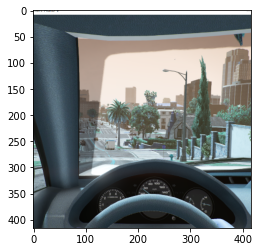

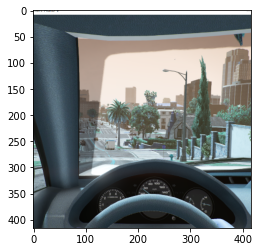

---------------------------------------------------------


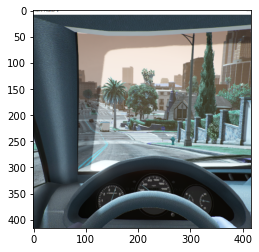

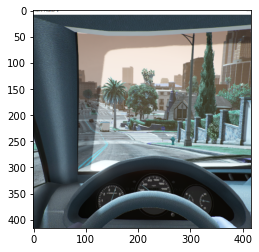

---------------------------------------------------------


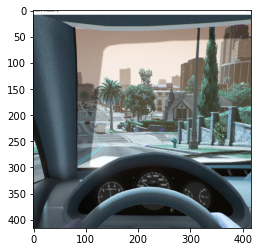

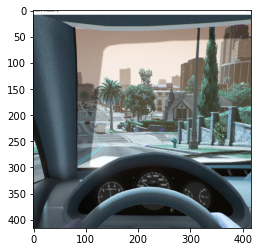

---------------------------------------------------------


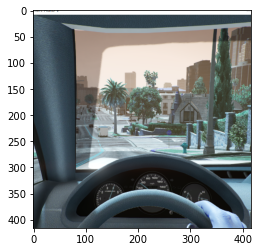

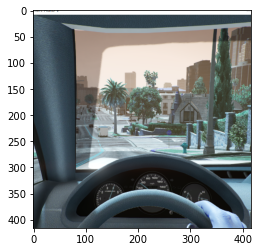

---------------------------------------------------------


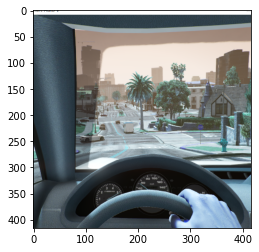

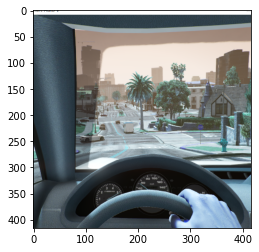

---------------------------------------------------------


In [18]:
'''
Plots images from the data file
'''

plotImgs = True
if plotImgs:
    with np.load('Data\\training_data2.npz') as data:
        training_data = data['data']
    
    i= 10
    for j in range(5):
        plt.imshow(cv2.cvtColor(training_data[i][j], cv2.COLOR_BGR2RGB))
        plt.show()
        plt.imshow(cv2.cvtColor(training_data[i][j], cv2.COLOR_BGR2RGB))
        plt.show()
        print('---------------------------------------------------------')

(416, 416, 3) (416, 416, 3) (416, 416, 3)
(416, 416, 3) (416, 416, 3) (416, 416, 3)
(416, 416, 3) (416, 416, 3) (416, 416, 3)
(416, 416, 3) (416, 416, 3) (416, 416, 3)
13 400 246 412 13 246
13 400 246 412 13 247
13 400 246 412 13 248
13 400 246 412 13 249
13 400 246 412 13 250
13 400 246 412 13 251
13 400 246 412 13 252
13 400 246 412 13 253
13 400 246 412 13 254
13 400 246 412 13 255
13 400 246 412 13 256
13 400 246 412 13 257
13 400 246 412 13 258
13 400 246 412 13 259
13 400 246 412 13 260
13 400 246 412 13 261
13 400 246 412 13 262
13 400 246 412 13 263
13 400 246 412 13 264
13 400 246 412 13 265
13 400 246 412 13 266
13 400 246 412 13 267
13 400 246 412 13 268
13 400 246 412 13 269
13 400 246 412 13 270
13 400 246 412 13 271
13 400 246 412 13 272
13 400 246 412 13 273
13 400 246 412 13 274
13 400 246 412 13 275
13 400 246 412 13 276
13 400 246 412 13 277
13 400 246 412 13 278
13 400 246 412 13 279
13 400 246 412 13 280
13 400 246 412 13 281
13 400 246 412 13 282
13 400 246 412 13 

13 400 246 412 16 253
13 400 246 412 16 254
13 400 246 412 16 255
13 400 246 412 16 256
13 400 246 412 16 257
13 400 246 412 16 258
13 400 246 412 16 259
13 400 246 412 16 260
13 400 246 412 16 261
13 400 246 412 16 262
13 400 246 412 16 263
13 400 246 412 16 264
13 400 246 412 16 265
13 400 246 412 16 266
13 400 246 412 16 267
13 400 246 412 16 268
13 400 246 412 16 269
13 400 246 412 16 270
13 400 246 412 16 271
13 400 246 412 16 272
13 400 246 412 16 273
13 400 246 412 16 274
13 400 246 412 16 275
13 400 246 412 16 276
13 400 246 412 16 277
13 400 246 412 16 278
13 400 246 412 16 279
13 400 246 412 16 280
13 400 246 412 16 281
13 400 246 412 16 282
13 400 246 412 16 283
13 400 246 412 16 284
13 400 246 412 16 285
13 400 246 412 16 286
13 400 246 412 16 287
13 400 246 412 16 288
13 400 246 412 16 289
13 400 246 412 16 290
13 400 246 412 16 291
13 400 246 412 16 292
13 400 246 412 16 293
13 400 246 412 16 294
13 400 246 412 16 295
13 400 246 412 16 296
13 400 246 412 16 297
13 400 246

13 400 246 412 19 254
13 400 246 412 19 255
13 400 246 412 19 256
13 400 246 412 19 257
13 400 246 412 19 258
13 400 246 412 19 259
13 400 246 412 19 260
13 400 246 412 19 261
13 400 246 412 19 262
13 400 246 412 19 263
13 400 246 412 19 264
13 400 246 412 19 265
13 400 246 412 19 266
13 400 246 412 19 267
13 400 246 412 19 268
13 400 246 412 19 269
13 400 246 412 19 270
13 400 246 412 19 271
13 400 246 412 19 272
13 400 246 412 19 273
13 400 246 412 19 274
13 400 246 412 19 275
13 400 246 412 19 276
13 400 246 412 19 277
13 400 246 412 19 278
13 400 246 412 19 279
13 400 246 412 19 280
13 400 246 412 19 281
13 400 246 412 19 282
13 400 246 412 19 283
13 400 246 412 19 284
13 400 246 412 19 285
13 400 246 412 19 286
13 400 246 412 19 287
13 400 246 412 19 288
13 400 246 412 19 289
13 400 246 412 19 290
13 400 246 412 19 291
13 400 246 412 19 292
13 400 246 412 19 293
13 400 246 412 19 294
13 400 246 412 19 295
13 400 246 412 19 296
13 400 246 412 19 297
13 400 246 412 19 298
13 400 246

13 400 246 412 21 370
13 400 246 412 21 371
13 400 246 412 21 372
13 400 246 412 21 373
13 400 246 412 21 374
13 400 246 412 21 375
13 400 246 412 21 376
13 400 246 412 21 377
13 400 246 412 21 378
13 400 246 412 21 379
13 400 246 412 21 380
13 400 246 412 21 381
13 400 246 412 21 382
13 400 246 412 21 383
13 400 246 412 21 384
13 400 246 412 21 385
13 400 246 412 21 386
13 400 246 412 21 387
13 400 246 412 21 388
13 400 246 412 21 389
13 400 246 412 21 390
13 400 246 412 21 391
13 400 246 412 21 392
13 400 246 412 21 393
13 400 246 412 21 394
13 400 246 412 21 395
13 400 246 412 21 396
13 400 246 412 21 397
13 400 246 412 21 398
13 400 246 412 21 399
13 400 246 412 21 400
13 400 246 412 21 401
13 400 246 412 21 402
13 400 246 412 21 403
13 400 246 412 21 404
13 400 246 412 21 405
13 400 246 412 21 406
13 400 246 412 21 407
13 400 246 412 21 408
13 400 246 412 21 409
13 400 246 412 21 410
13 400 246 412 21 411
13 400 246 412 22 246
13 400 246 412 22 247
13 400 246 412 22 248
13 400 246

13 400 246 412 24 383
13 400 246 412 24 384
13 400 246 412 24 385
13 400 246 412 24 386
13 400 246 412 24 387
13 400 246 412 24 388
13 400 246 412 24 389
13 400 246 412 24 390
13 400 246 412 24 391
13 400 246 412 24 392
13 400 246 412 24 393
13 400 246 412 24 394
13 400 246 412 24 395
13 400 246 412 24 396
13 400 246 412 24 397
13 400 246 412 24 398
13 400 246 412 24 399
13 400 246 412 24 400
13 400 246 412 24 401
13 400 246 412 24 402
13 400 246 412 24 403
13 400 246 412 24 404
13 400 246 412 24 405
13 400 246 412 24 406
13 400 246 412 24 407
13 400 246 412 24 408
13 400 246 412 24 409
13 400 246 412 24 410
13 400 246 412 24 411
13 400 246 412 25 246
13 400 246 412 25 247
13 400 246 412 25 248
13 400 246 412 25 249
13 400 246 412 25 250
13 400 246 412 25 251
13 400 246 412 25 252
13 400 246 412 25 253
13 400 246 412 25 254
13 400 246 412 25 255
13 400 246 412 25 256
13 400 246 412 25 257
13 400 246 412 25 258
13 400 246 412 25 259
13 400 246 412 25 260
13 400 246 412 25 261
13 400 246

13 400 246 412 28 261
13 400 246 412 28 262
13 400 246 412 28 263
13 400 246 412 28 264
13 400 246 412 28 265
13 400 246 412 28 266
13 400 246 412 28 267
13 400 246 412 28 268
13 400 246 412 28 269
13 400 246 412 28 270
13 400 246 412 28 271
13 400 246 412 28 272
13 400 246 412 28 273
13 400 246 412 28 274
13 400 246 412 28 275
13 400 246 412 28 276
13 400 246 412 28 277
13 400 246 412 28 278
13 400 246 412 28 279
13 400 246 412 28 280
13 400 246 412 28 281
13 400 246 412 28 282
13 400 246 412 28 283
13 400 246 412 28 284
13 400 246 412 28 285
13 400 246 412 28 286
13 400 246 412 28 287
13 400 246 412 28 288
13 400 246 412 28 289
13 400 246 412 28 290
13 400 246 412 28 291
13 400 246 412 28 292
13 400 246 412 28 293
13 400 246 412 28 294
13 400 246 412 28 295
13 400 246 412 28 296
13 400 246 412 28 297
13 400 246 412 28 298
13 400 246 412 28 299
13 400 246 412 28 300
13 400 246 412 28 301
13 400 246 412 28 302
13 400 246 412 28 303
13 400 246 412 28 304
13 400 246 412 28 305
13 400 246

13 400 246 412 30 389
13 400 246 412 30 390
13 400 246 412 30 391
13 400 246 412 30 392
13 400 246 412 30 393
13 400 246 412 30 394
13 400 246 412 30 395
13 400 246 412 30 396
13 400 246 412 30 397
13 400 246 412 30 398
13 400 246 412 30 399
13 400 246 412 30 400
13 400 246 412 30 401
13 400 246 412 30 402
13 400 246 412 30 403
13 400 246 412 30 404
13 400 246 412 30 405
13 400 246 412 30 406
13 400 246 412 30 407
13 400 246 412 30 408
13 400 246 412 30 409
13 400 246 412 30 410
13 400 246 412 30 411
13 400 246 412 31 246
13 400 246 412 31 247
13 400 246 412 31 248
13 400 246 412 31 249
13 400 246 412 31 250
13 400 246 412 31 251
13 400 246 412 31 252
13 400 246 412 31 253
13 400 246 412 31 254
13 400 246 412 31 255
13 400 246 412 31 256
13 400 246 412 31 257
13 400 246 412 31 258
13 400 246 412 31 259
13 400 246 412 31 260
13 400 246 412 31 261
13 400 246 412 31 262
13 400 246 412 31 263
13 400 246 412 31 264
13 400 246 412 31 265
13 400 246 412 31 266
13 400 246 412 31 267
13 400 246

13 400 246 412 33 376
13 400 246 412 33 377
13 400 246 412 33 378
13 400 246 412 33 379
13 400 246 412 33 380
13 400 246 412 33 381
13 400 246 412 33 382
13 400 246 412 33 383
13 400 246 412 33 384
13 400 246 412 33 385
13 400 246 412 33 386
13 400 246 412 33 387
13 400 246 412 33 388
13 400 246 412 33 389
13 400 246 412 33 390
13 400 246 412 33 391
13 400 246 412 33 392
13 400 246 412 33 393
13 400 246 412 33 394
13 400 246 412 33 395
13 400 246 412 33 396
13 400 246 412 33 397
13 400 246 412 33 398
13 400 246 412 33 399
13 400 246 412 33 400
13 400 246 412 33 401
13 400 246 412 33 402
13 400 246 412 33 403
13 400 246 412 33 404
13 400 246 412 33 405
13 400 246 412 33 406
13 400 246 412 33 407
13 400 246 412 33 408
13 400 246 412 33 409
13 400 246 412 33 410
13 400 246 412 33 411
13 400 246 412 34 246
13 400 246 412 34 247
13 400 246 412 34 248
13 400 246 412 34 249
13 400 246 412 34 250
13 400 246 412 34 251
13 400 246 412 34 252
13 400 246 412 34 253
13 400 246 412 34 254
13 400 246

13 400 246 412 36 395
13 400 246 412 36 396
13 400 246 412 36 397
13 400 246 412 36 398
13 400 246 412 36 399
13 400 246 412 36 400
13 400 246 412 36 401
13 400 246 412 36 402
13 400 246 412 36 403
13 400 246 412 36 404
13 400 246 412 36 405
13 400 246 412 36 406
13 400 246 412 36 407
13 400 246 412 36 408
13 400 246 412 36 409
13 400 246 412 36 410
13 400 246 412 36 411
13 400 246 412 37 246
13 400 246 412 37 247
13 400 246 412 37 248
13 400 246 412 37 249
13 400 246 412 37 250
13 400 246 412 37 251
13 400 246 412 37 252
13 400 246 412 37 253
13 400 246 412 37 254
13 400 246 412 37 255
13 400 246 412 37 256
13 400 246 412 37 257
13 400 246 412 37 258
13 400 246 412 37 259
13 400 246 412 37 260
13 400 246 412 37 261
13 400 246 412 37 262
13 400 246 412 37 263
13 400 246 412 37 264
13 400 246 412 37 265
13 400 246 412 37 266
13 400 246 412 37 267
13 400 246 412 37 268
13 400 246 412 37 269
13 400 246 412 37 270
13 400 246 412 37 271
13 400 246 412 37 272
13 400 246 412 37 273
13 400 246

13 400 246 412 40 258
13 400 246 412 40 259
13 400 246 412 40 260
13 400 246 412 40 261
13 400 246 412 40 262
13 400 246 412 40 263
13 400 246 412 40 264
13 400 246 412 40 265
13 400 246 412 40 266
13 400 246 412 40 267
13 400 246 412 40 268
13 400 246 412 40 269
13 400 246 412 40 270
13 400 246 412 40 271
13 400 246 412 40 272
13 400 246 412 40 273
13 400 246 412 40 274
13 400 246 412 40 275
13 400 246 412 40 276
13 400 246 412 40 277
13 400 246 412 40 278
13 400 246 412 40 279
13 400 246 412 40 280
13 400 246 412 40 281
13 400 246 412 40 282
13 400 246 412 40 283
13 400 246 412 40 284
13 400 246 412 40 285
13 400 246 412 40 286
13 400 246 412 40 287
13 400 246 412 40 288
13 400 246 412 40 289
13 400 246 412 40 290
13 400 246 412 40 291
13 400 246 412 40 292
13 400 246 412 40 293
13 400 246 412 40 294
13 400 246 412 40 295
13 400 246 412 40 296
13 400 246 412 40 297
13 400 246 412 40 298
13 400 246 412 40 299
13 400 246 412 40 300
13 400 246 412 40 301
13 400 246 412 40 302
13 400 246

13 400 246 412 42 374
13 400 246 412 42 375
13 400 246 412 42 376
13 400 246 412 42 377
13 400 246 412 42 378
13 400 246 412 42 379
13 400 246 412 42 380
13 400 246 412 42 381
13 400 246 412 42 382
13 400 246 412 42 383
13 400 246 412 42 384
13 400 246 412 42 385
13 400 246 412 42 386
13 400 246 412 42 387
13 400 246 412 42 388
13 400 246 412 42 389
13 400 246 412 42 390
13 400 246 412 42 391
13 400 246 412 42 392
13 400 246 412 42 393
13 400 246 412 42 394
13 400 246 412 42 395
13 400 246 412 42 396
13 400 246 412 42 397
13 400 246 412 42 398
13 400 246 412 42 399
13 400 246 412 42 400
13 400 246 412 42 401
13 400 246 412 42 402
13 400 246 412 42 403
13 400 246 412 42 404
13 400 246 412 42 405
13 400 246 412 42 406
13 400 246 412 42 407
13 400 246 412 42 408
13 400 246 412 42 409
13 400 246 412 42 410
13 400 246 412 42 411
13 400 246 412 43 246
13 400 246 412 43 247
13 400 246 412 43 248
13 400 246 412 43 249
13 400 246 412 43 250
13 400 246 412 43 251
13 400 246 412 43 252
13 400 246

13 400 246 412 45 373
13 400 246 412 45 374
13 400 246 412 45 375
13 400 246 412 45 376
13 400 246 412 45 377
13 400 246 412 45 378
13 400 246 412 45 379
13 400 246 412 45 380
13 400 246 412 45 381
13 400 246 412 45 382
13 400 246 412 45 383
13 400 246 412 45 384
13 400 246 412 45 385
13 400 246 412 45 386
13 400 246 412 45 387
13 400 246 412 45 388
13 400 246 412 45 389
13 400 246 412 45 390
13 400 246 412 45 391
13 400 246 412 45 392
13 400 246 412 45 393
13 400 246 412 45 394
13 400 246 412 45 395
13 400 246 412 45 396
13 400 246 412 45 397
13 400 246 412 45 398
13 400 246 412 45 399
13 400 246 412 45 400
13 400 246 412 45 401
13 400 246 412 45 402
13 400 246 412 45 403
13 400 246 412 45 404
13 400 246 412 45 405
13 400 246 412 45 406
13 400 246 412 45 407
13 400 246 412 45 408
13 400 246 412 45 409
13 400 246 412 45 410
13 400 246 412 45 411
13 400 246 412 46 246
13 400 246 412 46 247
13 400 246 412 46 248
13 400 246 412 46 249
13 400 246 412 46 250
13 400 246 412 46 251
13 400 246

13 400 246 412 48 406
13 400 246 412 48 407
13 400 246 412 48 408
13 400 246 412 48 409
13 400 246 412 48 410
13 400 246 412 48 411
13 400 246 412 49 246
13 400 246 412 49 247
13 400 246 412 49 248
13 400 246 412 49 249
13 400 246 412 49 250
13 400 246 412 49 251
13 400 246 412 49 252
13 400 246 412 49 253
13 400 246 412 49 254
13 400 246 412 49 255
13 400 246 412 49 256
13 400 246 412 49 257
13 400 246 412 49 258
13 400 246 412 49 259
13 400 246 412 49 260
13 400 246 412 49 261
13 400 246 412 49 262
13 400 246 412 49 263
13 400 246 412 49 264
13 400 246 412 49 265
13 400 246 412 49 266
13 400 246 412 49 267
13 400 246 412 49 268
13 400 246 412 49 269
13 400 246 412 49 270
13 400 246 412 49 271
13 400 246 412 49 272
13 400 246 412 49 273
13 400 246 412 49 274
13 400 246 412 49 275
13 400 246 412 49 276
13 400 246 412 49 277
13 400 246 412 49 278
13 400 246 412 49 279
13 400 246 412 49 280
13 400 246 412 49 281
13 400 246 412 49 282
13 400 246 412 49 283
13 400 246 412 49 284
13 400 246

13 400 246 412 52 256
13 400 246 412 52 257
13 400 246 412 52 258
13 400 246 412 52 259
13 400 246 412 52 260
13 400 246 412 52 261
13 400 246 412 52 262
13 400 246 412 52 263
13 400 246 412 52 264
13 400 246 412 52 265
13 400 246 412 52 266
13 400 246 412 52 267
13 400 246 412 52 268
13 400 246 412 52 269
13 400 246 412 52 270
13 400 246 412 52 271
13 400 246 412 52 272
13 400 246 412 52 273
13 400 246 412 52 274
13 400 246 412 52 275
13 400 246 412 52 276
13 400 246 412 52 277
13 400 246 412 52 278
13 400 246 412 52 279
13 400 246 412 52 280
13 400 246 412 52 281
13 400 246 412 52 282
13 400 246 412 52 283
13 400 246 412 52 284
13 400 246 412 52 285
13 400 246 412 52 286
13 400 246 412 52 287
13 400 246 412 52 288
13 400 246 412 52 289
13 400 246 412 52 290
13 400 246 412 52 291
13 400 246 412 52 292
13 400 246 412 52 293
13 400 246 412 52 294
13 400 246 412 52 295
13 400 246 412 52 296
13 400 246 412 52 297
13 400 246 412 52 298
13 400 246 412 52 299
13 400 246 412 52 300
13 400 246

13 400 246 412 54 404
13 400 246 412 54 405
13 400 246 412 54 406
13 400 246 412 54 407
13 400 246 412 54 408
13 400 246 412 54 409
13 400 246 412 54 410
13 400 246 412 54 411
13 400 246 412 55 246
13 400 246 412 55 247
13 400 246 412 55 248
13 400 246 412 55 249
13 400 246 412 55 250
13 400 246 412 55 251
13 400 246 412 55 252
13 400 246 412 55 253
13 400 246 412 55 254
13 400 246 412 55 255
13 400 246 412 55 256
13 400 246 412 55 257
13 400 246 412 55 258
13 400 246 412 55 259
13 400 246 412 55 260
13 400 246 412 55 261
13 400 246 412 55 262
13 400 246 412 55 263
13 400 246 412 55 264
13 400 246 412 55 265
13 400 246 412 55 266
13 400 246 412 55 267
13 400 246 412 55 268
13 400 246 412 55 269
13 400 246 412 55 270
13 400 246 412 55 271
13 400 246 412 55 272
13 400 246 412 55 273
13 400 246 412 55 274
13 400 246 412 55 275
13 400 246 412 55 276
13 400 246 412 55 277
13 400 246 412 55 278
13 400 246 412 55 279
13 400 246 412 55 280
13 400 246 412 55 281
13 400 246 412 55 282
13 400 246

13 400 246 412 57 395
13 400 246 412 57 396
13 400 246 412 57 397
13 400 246 412 57 398
13 400 246 412 57 399
13 400 246 412 57 400
13 400 246 412 57 401
13 400 246 412 57 402
13 400 246 412 57 403
13 400 246 412 57 404
13 400 246 412 57 405
13 400 246 412 57 406
13 400 246 412 57 407
13 400 246 412 57 408
13 400 246 412 57 409
13 400 246 412 57 410
13 400 246 412 57 411
13 400 246 412 58 246
13 400 246 412 58 247
13 400 246 412 58 248
13 400 246 412 58 249
13 400 246 412 58 250
13 400 246 412 58 251
13 400 246 412 58 252
13 400 246 412 58 253
13 400 246 412 58 254
13 400 246 412 58 255
13 400 246 412 58 256
13 400 246 412 58 257
13 400 246 412 58 258
13 400 246 412 58 259
13 400 246 412 58 260
13 400 246 412 58 261
13 400 246 412 58 262
13 400 246 412 58 263
13 400 246 412 58 264
13 400 246 412 58 265
13 400 246 412 58 266
13 400 246 412 58 267
13 400 246 412 58 268
13 400 246 412 58 269
13 400 246 412 58 270
13 400 246 412 58 271
13 400 246 412 58 272
13 400 246 412 58 273
13 400 246

13 400 246 412 60 357
13 400 246 412 60 358
13 400 246 412 60 359
13 400 246 412 60 360
13 400 246 412 60 361
13 400 246 412 60 362
13 400 246 412 60 363
13 400 246 412 60 364
13 400 246 412 60 365
13 400 246 412 60 366
13 400 246 412 60 367
13 400 246 412 60 368
13 400 246 412 60 369
13 400 246 412 60 370
13 400 246 412 60 371
13 400 246 412 60 372
13 400 246 412 60 373
13 400 246 412 60 374
13 400 246 412 60 375
13 400 246 412 60 376
13 400 246 412 60 377
13 400 246 412 60 378
13 400 246 412 60 379
13 400 246 412 60 380
13 400 246 412 60 381
13 400 246 412 60 382
13 400 246 412 60 383
13 400 246 412 60 384
13 400 246 412 60 385
13 400 246 412 60 386
13 400 246 412 60 387
13 400 246 412 60 388
13 400 246 412 60 389
13 400 246 412 60 390
13 400 246 412 60 391
13 400 246 412 60 392
13 400 246 412 60 393
13 400 246 412 60 394
13 400 246 412 60 395
13 400 246 412 60 396
13 400 246 412 60 397
13 400 246 412 60 398
13 400 246 412 60 399
13 400 246 412 60 400
13 400 246 412 60 401
13 400 246

13 400 246 412 63 325
13 400 246 412 63 326
13 400 246 412 63 327
13 400 246 412 63 328
13 400 246 412 63 329
13 400 246 412 63 330
13 400 246 412 63 331
13 400 246 412 63 332
13 400 246 412 63 333
13 400 246 412 63 334
13 400 246 412 63 335
13 400 246 412 63 336
13 400 246 412 63 337
13 400 246 412 63 338
13 400 246 412 63 339
13 400 246 412 63 340
13 400 246 412 63 341
13 400 246 412 63 342
13 400 246 412 63 343
13 400 246 412 63 344
13 400 246 412 63 345
13 400 246 412 63 346
13 400 246 412 63 347
13 400 246 412 63 348
13 400 246 412 63 349
13 400 246 412 63 350
13 400 246 412 63 351
13 400 246 412 63 352
13 400 246 412 63 353
13 400 246 412 63 354
13 400 246 412 63 355
13 400 246 412 63 356
13 400 246 412 63 357
13 400 246 412 63 358
13 400 246 412 63 359
13 400 246 412 63 360
13 400 246 412 63 361
13 400 246 412 63 362
13 400 246 412 63 363
13 400 246 412 63 364
13 400 246 412 63 365
13 400 246 412 63 366
13 400 246 412 63 367
13 400 246 412 63 368
13 400 246 412 63 369
13 400 246

13 400 246 412 66 329
13 400 246 412 66 330
13 400 246 412 66 331
13 400 246 412 66 332
13 400 246 412 66 333
13 400 246 412 66 334
13 400 246 412 66 335
13 400 246 412 66 336
13 400 246 412 66 337
13 400 246 412 66 338
13 400 246 412 66 339
13 400 246 412 66 340
13 400 246 412 66 341
13 400 246 412 66 342
13 400 246 412 66 343
13 400 246 412 66 344
13 400 246 412 66 345
13 400 246 412 66 346
13 400 246 412 66 347
13 400 246 412 66 348
13 400 246 412 66 349
13 400 246 412 66 350
13 400 246 412 66 351
13 400 246 412 66 352
13 400 246 412 66 353
13 400 246 412 66 354
13 400 246 412 66 355
13 400 246 412 66 356
13 400 246 412 66 357
13 400 246 412 66 358
13 400 246 412 66 359
13 400 246 412 66 360
13 400 246 412 66 361
13 400 246 412 66 362
13 400 246 412 66 363
13 400 246 412 66 364
13 400 246 412 66 365
13 400 246 412 66 366
13 400 246 412 66 367
13 400 246 412 66 368
13 400 246 412 66 369
13 400 246 412 66 370
13 400 246 412 66 371
13 400 246 412 66 372
13 400 246 412 66 373
13 400 246

13 400 246 412 69 328
13 400 246 412 69 329
13 400 246 412 69 330
13 400 246 412 69 331
13 400 246 412 69 332
13 400 246 412 69 333
13 400 246 412 69 334
13 400 246 412 69 335
13 400 246 412 69 336
13 400 246 412 69 337
13 400 246 412 69 338
13 400 246 412 69 339
13 400 246 412 69 340
13 400 246 412 69 341
13 400 246 412 69 342
13 400 246 412 69 343
13 400 246 412 69 344
13 400 246 412 69 345
13 400 246 412 69 346
13 400 246 412 69 347
13 400 246 412 69 348
13 400 246 412 69 349
13 400 246 412 69 350
13 400 246 412 69 351
13 400 246 412 69 352
13 400 246 412 69 353
13 400 246 412 69 354
13 400 246 412 69 355
13 400 246 412 69 356
13 400 246 412 69 357
13 400 246 412 69 358
13 400 246 412 69 359
13 400 246 412 69 360
13 400 246 412 69 361
13 400 246 412 69 362
13 400 246 412 69 363
13 400 246 412 69 364
13 400 246 412 69 365
13 400 246 412 69 366
13 400 246 412 69 367
13 400 246 412 69 368
13 400 246 412 69 369
13 400 246 412 69 370
13 400 246 412 69 371
13 400 246 412 69 372
13 400 246

13 400 246 412 72 330
13 400 246 412 72 331
13 400 246 412 72 332
13 400 246 412 72 333
13 400 246 412 72 334
13 400 246 412 72 335
13 400 246 412 72 336
13 400 246 412 72 337
13 400 246 412 72 338
13 400 246 412 72 339
13 400 246 412 72 340
13 400 246 412 72 341
13 400 246 412 72 342
13 400 246 412 72 343
13 400 246 412 72 344
13 400 246 412 72 345
13 400 246 412 72 346
13 400 246 412 72 347
13 400 246 412 72 348
13 400 246 412 72 349
13 400 246 412 72 350
13 400 246 412 72 351
13 400 246 412 72 352
13 400 246 412 72 353
13 400 246 412 72 354
13 400 246 412 72 355
13 400 246 412 72 356
13 400 246 412 72 357
13 400 246 412 72 358
13 400 246 412 72 359
13 400 246 412 72 360
13 400 246 412 72 361
13 400 246 412 72 362
13 400 246 412 72 363
13 400 246 412 72 364
13 400 246 412 72 365
13 400 246 412 72 366
13 400 246 412 72 367
13 400 246 412 72 368
13 400 246 412 72 369
13 400 246 412 72 370
13 400 246 412 72 371
13 400 246 412 72 372
13 400 246 412 72 373
13 400 246 412 72 374
13 400 246

13 400 246 412 75 337
13 400 246 412 75 338
13 400 246 412 75 339
13 400 246 412 75 340
13 400 246 412 75 341
13 400 246 412 75 342
13 400 246 412 75 343
13 400 246 412 75 344
13 400 246 412 75 345
13 400 246 412 75 346
13 400 246 412 75 347
13 400 246 412 75 348
13 400 246 412 75 349
13 400 246 412 75 350
13 400 246 412 75 351
13 400 246 412 75 352
13 400 246 412 75 353
13 400 246 412 75 354
13 400 246 412 75 355
13 400 246 412 75 356
13 400 246 412 75 357
13 400 246 412 75 358
13 400 246 412 75 359
13 400 246 412 75 360
13 400 246 412 75 361
13 400 246 412 75 362
13 400 246 412 75 363
13 400 246 412 75 364
13 400 246 412 75 365
13 400 246 412 75 366
13 400 246 412 75 367
13 400 246 412 75 368
13 400 246 412 75 369
13 400 246 412 75 370
13 400 246 412 75 371
13 400 246 412 75 372
13 400 246 412 75 373
13 400 246 412 75 374
13 400 246 412 75 375
13 400 246 412 75 376
13 400 246 412 75 377
13 400 246 412 75 378
13 400 246 412 75 379
13 400 246 412 75 380
13 400 246 412 75 381
13 400 246

13 400 246 412 78 370
13 400 246 412 78 371
13 400 246 412 78 372
13 400 246 412 78 373
13 400 246 412 78 374
13 400 246 412 78 375
13 400 246 412 78 376
13 400 246 412 78 377
13 400 246 412 78 378
13 400 246 412 78 379
13 400 246 412 78 380
13 400 246 412 78 381
13 400 246 412 78 382
13 400 246 412 78 383
13 400 246 412 78 384
13 400 246 412 78 385
13 400 246 412 78 386
13 400 246 412 78 387
13 400 246 412 78 388
13 400 246 412 78 389
13 400 246 412 78 390
13 400 246 412 78 391
13 400 246 412 78 392
13 400 246 412 78 393
13 400 246 412 78 394
13 400 246 412 78 395
13 400 246 412 78 396
13 400 246 412 78 397
13 400 246 412 78 398
13 400 246 412 78 399
13 400 246 412 78 400
13 400 246 412 78 401
13 400 246 412 78 402
13 400 246 412 78 403
13 400 246 412 78 404
13 400 246 412 78 405
13 400 246 412 78 406
13 400 246 412 78 407
13 400 246 412 78 408
13 400 246 412 78 409
13 400 246 412 78 410
13 400 246 412 78 411
13 400 246 412 79 246
13 400 246 412 79 247
13 400 246 412 79 248
13 400 246

13 400 246 412 81 267
13 400 246 412 81 268
13 400 246 412 81 269
13 400 246 412 81 270
13 400 246 412 81 271
13 400 246 412 81 272
13 400 246 412 81 273
13 400 246 412 81 274
13 400 246 412 81 275
13 400 246 412 81 276
13 400 246 412 81 277
13 400 246 412 81 278
13 400 246 412 81 279
13 400 246 412 81 280
13 400 246 412 81 281
13 400 246 412 81 282
13 400 246 412 81 283
13 400 246 412 81 284
13 400 246 412 81 285
13 400 246 412 81 286
13 400 246 412 81 287
13 400 246 412 81 288
13 400 246 412 81 289
13 400 246 412 81 290
13 400 246 412 81 291
13 400 246 412 81 292
13 400 246 412 81 293
13 400 246 412 81 294
13 400 246 412 81 295
13 400 246 412 81 296
13 400 246 412 81 297
13 400 246 412 81 298
13 400 246 412 81 299
13 400 246 412 81 300
13 400 246 412 81 301
13 400 246 412 81 302
13 400 246 412 81 303
13 400 246 412 81 304
13 400 246 412 81 305
13 400 246 412 81 306
13 400 246 412 81 307
13 400 246 412 81 308
13 400 246 412 81 309
13 400 246 412 81 310
13 400 246 412 81 311
13 400 246

13 400 246 412 84 263
13 400 246 412 84 264
13 400 246 412 84 265
13 400 246 412 84 266
13 400 246 412 84 267
13 400 246 412 84 268
13 400 246 412 84 269
13 400 246 412 84 270
13 400 246 412 84 271
13 400 246 412 84 272
13 400 246 412 84 273
13 400 246 412 84 274
13 400 246 412 84 275
13 400 246 412 84 276
13 400 246 412 84 277
13 400 246 412 84 278
13 400 246 412 84 279
13 400 246 412 84 280
13 400 246 412 84 281
13 400 246 412 84 282
13 400 246 412 84 283
13 400 246 412 84 284
13 400 246 412 84 285
13 400 246 412 84 286
13 400 246 412 84 287
13 400 246 412 84 288
13 400 246 412 84 289
13 400 246 412 84 290
13 400 246 412 84 291
13 400 246 412 84 292
13 400 246 412 84 293
13 400 246 412 84 294
13 400 246 412 84 295
13 400 246 412 84 296
13 400 246 412 84 297
13 400 246 412 84 298
13 400 246 412 84 299
13 400 246 412 84 300
13 400 246 412 84 301
13 400 246 412 84 302
13 400 246 412 84 303
13 400 246 412 84 304
13 400 246 412 84 305
13 400 246 412 84 306
13 400 246 412 84 307
13 400 246

13 400 246 412 87 261
13 400 246 412 87 262
13 400 246 412 87 263
13 400 246 412 87 264
13 400 246 412 87 265
13 400 246 412 87 266
13 400 246 412 87 267
13 400 246 412 87 268
13 400 246 412 87 269
13 400 246 412 87 270
13 400 246 412 87 271
13 400 246 412 87 272
13 400 246 412 87 273
13 400 246 412 87 274
13 400 246 412 87 275
13 400 246 412 87 276
13 400 246 412 87 277
13 400 246 412 87 278
13 400 246 412 87 279
13 400 246 412 87 280
13 400 246 412 87 281
13 400 246 412 87 282
13 400 246 412 87 283
13 400 246 412 87 284
13 400 246 412 87 285
13 400 246 412 87 286
13 400 246 412 87 287
13 400 246 412 87 288
13 400 246 412 87 289
13 400 246 412 87 290
13 400 246 412 87 291
13 400 246 412 87 292
13 400 246 412 87 293
13 400 246 412 87 294
13 400 246 412 87 295
13 400 246 412 87 296
13 400 246 412 87 297
13 400 246 412 87 298
13 400 246 412 87 299
13 400 246 412 87 300
13 400 246 412 87 301
13 400 246 412 87 302
13 400 246 412 87 303
13 400 246 412 87 304
13 400 246 412 87 305
13 400 246

13 400 246 412 90 252
13 400 246 412 90 253
13 400 246 412 90 254
13 400 246 412 90 255
13 400 246 412 90 256
13 400 246 412 90 257
13 400 246 412 90 258
13 400 246 412 90 259
13 400 246 412 90 260
13 400 246 412 90 261
13 400 246 412 90 262
13 400 246 412 90 263
13 400 246 412 90 264
13 400 246 412 90 265
13 400 246 412 90 266
13 400 246 412 90 267
13 400 246 412 90 268
13 400 246 412 90 269
13 400 246 412 90 270
13 400 246 412 90 271
13 400 246 412 90 272
13 400 246 412 90 273
13 400 246 412 90 274
13 400 246 412 90 275
13 400 246 412 90 276
13 400 246 412 90 277
13 400 246 412 90 278
13 400 246 412 90 279
13 400 246 412 90 280
13 400 246 412 90 281
13 400 246 412 90 282
13 400 246 412 90 283
13 400 246 412 90 284
13 400 246 412 90 285
13 400 246 412 90 286
13 400 246 412 90 287
13 400 246 412 90 288
13 400 246 412 90 289
13 400 246 412 90 290
13 400 246 412 90 291
13 400 246 412 90 292
13 400 246 412 90 293
13 400 246 412 90 294
13 400 246 412 90 295
13 400 246 412 90 296
13 400 246

13 400 246 412 93 276
13 400 246 412 93 277
13 400 246 412 93 278
13 400 246 412 93 279
13 400 246 412 93 280
13 400 246 412 93 281
13 400 246 412 93 282
13 400 246 412 93 283
13 400 246 412 93 284
13 400 246 412 93 285
13 400 246 412 93 286
13 400 246 412 93 287
13 400 246 412 93 288
13 400 246 412 93 289
13 400 246 412 93 290
13 400 246 412 93 291
13 400 246 412 93 292
13 400 246 412 93 293
13 400 246 412 93 294
13 400 246 412 93 295
13 400 246 412 93 296
13 400 246 412 93 297
13 400 246 412 93 298
13 400 246 412 93 299
13 400 246 412 93 300
13 400 246 412 93 301
13 400 246 412 93 302
13 400 246 412 93 303
13 400 246 412 93 304
13 400 246 412 93 305
13 400 246 412 93 306
13 400 246 412 93 307
13 400 246 412 93 308
13 400 246 412 93 309
13 400 246 412 93 310
13 400 246 412 93 311
13 400 246 412 93 312
13 400 246 412 93 313
13 400 246 412 93 314
13 400 246 412 93 315
13 400 246 412 93 316
13 400 246 412 93 317
13 400 246 412 93 318
13 400 246 412 93 319
13 400 246 412 93 320
13 400 246

13 400 246 412 96 283
13 400 246 412 96 284
13 400 246 412 96 285
13 400 246 412 96 286
13 400 246 412 96 287
13 400 246 412 96 288
13 400 246 412 96 289
13 400 246 412 96 290
13 400 246 412 96 291
13 400 246 412 96 292
13 400 246 412 96 293
13 400 246 412 96 294
13 400 246 412 96 295
13 400 246 412 96 296
13 400 246 412 96 297
13 400 246 412 96 298
13 400 246 412 96 299
13 400 246 412 96 300
13 400 246 412 96 301
13 400 246 412 96 302
13 400 246 412 96 303
13 400 246 412 96 304
13 400 246 412 96 305
13 400 246 412 96 306
13 400 246 412 96 307
13 400 246 412 96 308
13 400 246 412 96 309
13 400 246 412 96 310
13 400 246 412 96 311
13 400 246 412 96 312
13 400 246 412 96 313
13 400 246 412 96 314
13 400 246 412 96 315
13 400 246 412 96 316
13 400 246 412 96 317
13 400 246 412 96 318
13 400 246 412 96 319
13 400 246 412 96 320
13 400 246 412 96 321
13 400 246 412 96 322
13 400 246 412 96 323
13 400 246 412 96 324
13 400 246 412 96 325
13 400 246 412 96 326
13 400 246 412 96 327
13 400 246

13 400 246 412 98 393
13 400 246 412 98 394
13 400 246 412 98 395
13 400 246 412 98 396
13 400 246 412 98 397
13 400 246 412 98 398
13 400 246 412 98 399
13 400 246 412 98 400
13 400 246 412 98 401
13 400 246 412 98 402
13 400 246 412 98 403
13 400 246 412 98 404
13 400 246 412 98 405
13 400 246 412 98 406
13 400 246 412 98 407
13 400 246 412 98 408
13 400 246 412 98 409
13 400 246 412 98 410
13 400 246 412 98 411
13 400 246 412 99 246
13 400 246 412 99 247
13 400 246 412 99 248
13 400 246 412 99 249
13 400 246 412 99 250
13 400 246 412 99 251
13 400 246 412 99 252
13 400 246 412 99 253
13 400 246 412 99 254
13 400 246 412 99 255
13 400 246 412 99 256
13 400 246 412 99 257
13 400 246 412 99 258
13 400 246 412 99 259
13 400 246 412 99 260
13 400 246 412 99 261
13 400 246 412 99 262
13 400 246 412 99 263
13 400 246 412 99 264
13 400 246 412 99 265
13 400 246 412 99 266
13 400 246 412 99 267
13 400 246 412 99 268
13 400 246 412 99 269
13 400 246 412 99 270
13 400 246 412 99 271
13 400 246

13 400 246 412 102 266
13 400 246 412 102 267
13 400 246 412 102 268
13 400 246 412 102 269
13 400 246 412 102 270
13 400 246 412 102 271
13 400 246 412 102 272
13 400 246 412 102 273
13 400 246 412 102 274
13 400 246 412 102 275
13 400 246 412 102 276
13 400 246 412 102 277
13 400 246 412 102 278
13 400 246 412 102 279
13 400 246 412 102 280
13 400 246 412 102 281
13 400 246 412 102 282
13 400 246 412 102 283
13 400 246 412 102 284
13 400 246 412 102 285
13 400 246 412 102 286
13 400 246 412 102 287
13 400 246 412 102 288
13 400 246 412 102 289
13 400 246 412 102 290
13 400 246 412 102 291
13 400 246 412 102 292
13 400 246 412 102 293
13 400 246 412 102 294
13 400 246 412 102 295
13 400 246 412 102 296
13 400 246 412 102 297
13 400 246 412 102 298
13 400 246 412 102 299
13 400 246 412 102 300
13 400 246 412 102 301
13 400 246 412 102 302
13 400 246 412 102 303
13 400 246 412 102 304
13 400 246 412 102 305
13 400 246 412 102 306
13 400 246 412 102 307
13 400 246 412 102 308
13 400 246 

13 400 246 412 105 268
13 400 246 412 105 269
13 400 246 412 105 270
13 400 246 412 105 271
13 400 246 412 105 272
13 400 246 412 105 273
13 400 246 412 105 274
13 400 246 412 105 275
13 400 246 412 105 276
13 400 246 412 105 277
13 400 246 412 105 278
13 400 246 412 105 279
13 400 246 412 105 280
13 400 246 412 105 281
13 400 246 412 105 282
13 400 246 412 105 283
13 400 246 412 105 284
13 400 246 412 105 285
13 400 246 412 105 286
13 400 246 412 105 287
13 400 246 412 105 288
13 400 246 412 105 289
13 400 246 412 105 290
13 400 246 412 105 291
13 400 246 412 105 292
13 400 246 412 105 293
13 400 246 412 105 294
13 400 246 412 105 295
13 400 246 412 105 296
13 400 246 412 105 297
13 400 246 412 105 298
13 400 246 412 105 299
13 400 246 412 105 300
13 400 246 412 105 301
13 400 246 412 105 302
13 400 246 412 105 303
13 400 246 412 105 304
13 400 246 412 105 305
13 400 246 412 105 306
13 400 246 412 105 307
13 400 246 412 105 308
13 400 246 412 105 309
13 400 246 412 105 310
13 400 246 

13 400 246 412 107 407
13 400 246 412 107 408
13 400 246 412 107 409
13 400 246 412 107 410
13 400 246 412 107 411
13 400 246 412 108 246
13 400 246 412 108 247
13 400 246 412 108 248
13 400 246 412 108 249
13 400 246 412 108 250
13 400 246 412 108 251
13 400 246 412 108 252
13 400 246 412 108 253
13 400 246 412 108 254
13 400 246 412 108 255
13 400 246 412 108 256
13 400 246 412 108 257
13 400 246 412 108 258
13 400 246 412 108 259
13 400 246 412 108 260
13 400 246 412 108 261
13 400 246 412 108 262
13 400 246 412 108 263
13 400 246 412 108 264
13 400 246 412 108 265
13 400 246 412 108 266
13 400 246 412 108 267
13 400 246 412 108 268
13 400 246 412 108 269
13 400 246 412 108 270
13 400 246 412 108 271
13 400 246 412 108 272
13 400 246 412 108 273
13 400 246 412 108 274
13 400 246 412 108 275
13 400 246 412 108 276
13 400 246 412 108 277
13 400 246 412 108 278
13 400 246 412 108 279
13 400 246 412 108 280
13 400 246 412 108 281
13 400 246 412 108 282
13 400 246 412 108 283
13 400 246 

13 400 246 412 110 396
13 400 246 412 110 397
13 400 246 412 110 398
13 400 246 412 110 399
13 400 246 412 110 400
13 400 246 412 110 401
13 400 246 412 110 402
13 400 246 412 110 403
13 400 246 412 110 404
13 400 246 412 110 405
13 400 246 412 110 406
13 400 246 412 110 407
13 400 246 412 110 408
13 400 246 412 110 409
13 400 246 412 110 410
13 400 246 412 110 411
13 400 246 412 111 246
13 400 246 412 111 247
13 400 246 412 111 248
13 400 246 412 111 249
13 400 246 412 111 250
13 400 246 412 111 251
13 400 246 412 111 252
13 400 246 412 111 253
13 400 246 412 111 254
13 400 246 412 111 255
13 400 246 412 111 256
13 400 246 412 111 257
13 400 246 412 111 258
13 400 246 412 111 259
13 400 246 412 111 260
13 400 246 412 111 261
13 400 246 412 111 262
13 400 246 412 111 263
13 400 246 412 111 264
13 400 246 412 111 265
13 400 246 412 111 266
13 400 246 412 111 267
13 400 246 412 111 268
13 400 246 412 111 269
13 400 246 412 111 270
13 400 246 412 111 271
13 400 246 412 111 272
13 400 246 

13 400 246 412 113 343
13 400 246 412 113 344
13 400 246 412 113 345
13 400 246 412 113 346
13 400 246 412 113 347
13 400 246 412 113 348
13 400 246 412 113 349
13 400 246 412 113 350
13 400 246 412 113 351
13 400 246 412 113 352
13 400 246 412 113 353
13 400 246 412 113 354
13 400 246 412 113 355
13 400 246 412 113 356
13 400 246 412 113 357
13 400 246 412 113 358
13 400 246 412 113 359
13 400 246 412 113 360
13 400 246 412 113 361
13 400 246 412 113 362
13 400 246 412 113 363
13 400 246 412 113 364
13 400 246 412 113 365
13 400 246 412 113 366
13 400 246 412 113 367
13 400 246 412 113 368
13 400 246 412 113 369
13 400 246 412 113 370
13 400 246 412 113 371
13 400 246 412 113 372
13 400 246 412 113 373
13 400 246 412 113 374
13 400 246 412 113 375
13 400 246 412 113 376
13 400 246 412 113 377
13 400 246 412 113 378
13 400 246 412 113 379
13 400 246 412 113 380
13 400 246 412 113 381
13 400 246 412 113 382
13 400 246 412 113 383
13 400 246 412 113 384
13 400 246 412 113 385
13 400 246 

13 400 246 412 116 346
13 400 246 412 116 347
13 400 246 412 116 348
13 400 246 412 116 349
13 400 246 412 116 350
13 400 246 412 116 351
13 400 246 412 116 352
13 400 246 412 116 353
13 400 246 412 116 354
13 400 246 412 116 355
13 400 246 412 116 356
13 400 246 412 116 357
13 400 246 412 116 358
13 400 246 412 116 359
13 400 246 412 116 360
13 400 246 412 116 361
13 400 246 412 116 362
13 400 246 412 116 363
13 400 246 412 116 364
13 400 246 412 116 365
13 400 246 412 116 366
13 400 246 412 116 367
13 400 246 412 116 368
13 400 246 412 116 369
13 400 246 412 116 370
13 400 246 412 116 371
13 400 246 412 116 372
13 400 246 412 116 373
13 400 246 412 116 374
13 400 246 412 116 375
13 400 246 412 116 376
13 400 246 412 116 377
13 400 246 412 116 378
13 400 246 412 116 379
13 400 246 412 116 380
13 400 246 412 116 381
13 400 246 412 116 382
13 400 246 412 116 383
13 400 246 412 116 384
13 400 246 412 116 385
13 400 246 412 116 386
13 400 246 412 116 387
13 400 246 412 116 388
13 400 246 

13 400 246 412 119 318
13 400 246 412 119 319
13 400 246 412 119 320
13 400 246 412 119 321
13 400 246 412 119 322
13 400 246 412 119 323
13 400 246 412 119 324
13 400 246 412 119 325
13 400 246 412 119 326
13 400 246 412 119 327
13 400 246 412 119 328
13 400 246 412 119 329
13 400 246 412 119 330
13 400 246 412 119 331
13 400 246 412 119 332
13 400 246 412 119 333
13 400 246 412 119 334
13 400 246 412 119 335
13 400 246 412 119 336
13 400 246 412 119 337
13 400 246 412 119 338
13 400 246 412 119 339
13 400 246 412 119 340
13 400 246 412 119 341
13 400 246 412 119 342
13 400 246 412 119 343
13 400 246 412 119 344
13 400 246 412 119 345
13 400 246 412 119 346
13 400 246 412 119 347
13 400 246 412 119 348
13 400 246 412 119 349
13 400 246 412 119 350
13 400 246 412 119 351
13 400 246 412 119 352
13 400 246 412 119 353
13 400 246 412 119 354
13 400 246 412 119 355
13 400 246 412 119 356
13 400 246 412 119 357
13 400 246 412 119 358
13 400 246 412 119 359
13 400 246 412 119 360
13 400 246 

13 400 246 412 122 264
13 400 246 412 122 265
13 400 246 412 122 266
13 400 246 412 122 267
13 400 246 412 122 268
13 400 246 412 122 269
13 400 246 412 122 270
13 400 246 412 122 271
13 400 246 412 122 272
13 400 246 412 122 273
13 400 246 412 122 274
13 400 246 412 122 275
13 400 246 412 122 276
13 400 246 412 122 277
13 400 246 412 122 278
13 400 246 412 122 279
13 400 246 412 122 280
13 400 246 412 122 281
13 400 246 412 122 282
13 400 246 412 122 283
13 400 246 412 122 284
13 400 246 412 122 285
13 400 246 412 122 286
13 400 246 412 122 287
13 400 246 412 122 288
13 400 246 412 122 289
13 400 246 412 122 290
13 400 246 412 122 291
13 400 246 412 122 292
13 400 246 412 122 293
13 400 246 412 122 294
13 400 246 412 122 295
13 400 246 412 122 296
13 400 246 412 122 297
13 400 246 412 122 298
13 400 246 412 122 299
13 400 246 412 122 300
13 400 246 412 122 301
13 400 246 412 122 302
13 400 246 412 122 303
13 400 246 412 122 304
13 400 246 412 122 305
13 400 246 412 122 306
13 400 246 

13 400 246 412 125 266
13 400 246 412 125 267
13 400 246 412 125 268
13 400 246 412 125 269
13 400 246 412 125 270
13 400 246 412 125 271
13 400 246 412 125 272
13 400 246 412 125 273
13 400 246 412 125 274
13 400 246 412 125 275
13 400 246 412 125 276
13 400 246 412 125 277
13 400 246 412 125 278
13 400 246 412 125 279
13 400 246 412 125 280
13 400 246 412 125 281
13 400 246 412 125 282
13 400 246 412 125 283
13 400 246 412 125 284
13 400 246 412 125 285
13 400 246 412 125 286
13 400 246 412 125 287
13 400 246 412 125 288
13 400 246 412 125 289
13 400 246 412 125 290
13 400 246 412 125 291
13 400 246 412 125 292
13 400 246 412 125 293
13 400 246 412 125 294
13 400 246 412 125 295
13 400 246 412 125 296
13 400 246 412 125 297
13 400 246 412 125 298
13 400 246 412 125 299
13 400 246 412 125 300
13 400 246 412 125 301
13 400 246 412 125 302
13 400 246 412 125 303
13 400 246 412 125 304
13 400 246 412 125 305
13 400 246 412 125 306
13 400 246 412 125 307
13 400 246 412 125 308
13 400 246 

13 400 246 412 128 277
13 400 246 412 128 278
13 400 246 412 128 279
13 400 246 412 128 280
13 400 246 412 128 281
13 400 246 412 128 282
13 400 246 412 128 283
13 400 246 412 128 284
13 400 246 412 128 285
13 400 246 412 128 286
13 400 246 412 128 287
13 400 246 412 128 288
13 400 246 412 128 289
13 400 246 412 128 290
13 400 246 412 128 291
13 400 246 412 128 292
13 400 246 412 128 293
13 400 246 412 128 294
13 400 246 412 128 295
13 400 246 412 128 296
13 400 246 412 128 297
13 400 246 412 128 298
13 400 246 412 128 299
13 400 246 412 128 300
13 400 246 412 128 301
13 400 246 412 128 302
13 400 246 412 128 303
13 400 246 412 128 304
13 400 246 412 128 305
13 400 246 412 128 306
13 400 246 412 128 307
13 400 246 412 128 308
13 400 246 412 128 309
13 400 246 412 128 310
13 400 246 412 128 311
13 400 246 412 128 312
13 400 246 412 128 313
13 400 246 412 128 314
13 400 246 412 128 315
13 400 246 412 128 316
13 400 246 412 128 317
13 400 246 412 128 318
13 400 246 412 128 319
13 400 246 

13 400 246 412 130 406
13 400 246 412 130 407
13 400 246 412 130 408
13 400 246 412 130 409
13 400 246 412 130 410
13 400 246 412 130 411
13 400 246 412 131 246
13 400 246 412 131 247
13 400 246 412 131 248
13 400 246 412 131 249
13 400 246 412 131 250
13 400 246 412 131 251
13 400 246 412 131 252
13 400 246 412 131 253
13 400 246 412 131 254
13 400 246 412 131 255
13 400 246 412 131 256
13 400 246 412 131 257
13 400 246 412 131 258
13 400 246 412 131 259
13 400 246 412 131 260
13 400 246 412 131 261
13 400 246 412 131 262
13 400 246 412 131 263
13 400 246 412 131 264
13 400 246 412 131 265
13 400 246 412 131 266
13 400 246 412 131 267
13 400 246 412 131 268
13 400 246 412 131 269
13 400 246 412 131 270
13 400 246 412 131 271
13 400 246 412 131 272
13 400 246 412 131 273
13 400 246 412 131 274
13 400 246 412 131 275
13 400 246 412 131 276
13 400 246 412 131 277
13 400 246 412 131 278
13 400 246 412 131 279
13 400 246 412 131 280
13 400 246 412 131 281
13 400 246 412 131 282
13 400 246 

13 400 246 412 133 404
13 400 246 412 133 405
13 400 246 412 133 406
13 400 246 412 133 407
13 400 246 412 133 408
13 400 246 412 133 409
13 400 246 412 133 410
13 400 246 412 133 411
13 400 246 412 134 246
13 400 246 412 134 247
13 400 246 412 134 248
13 400 246 412 134 249
13 400 246 412 134 250
13 400 246 412 134 251
13 400 246 412 134 252
13 400 246 412 134 253
13 400 246 412 134 254
13 400 246 412 134 255
13 400 246 412 134 256
13 400 246 412 134 257
13 400 246 412 134 258
13 400 246 412 134 259
13 400 246 412 134 260
13 400 246 412 134 261
13 400 246 412 134 262
13 400 246 412 134 263
13 400 246 412 134 264
13 400 246 412 134 265
13 400 246 412 134 266
13 400 246 412 134 267
13 400 246 412 134 268
13 400 246 412 134 269
13 400 246 412 134 270
13 400 246 412 134 271
13 400 246 412 134 272
13 400 246 412 134 273
13 400 246 412 134 274
13 400 246 412 134 275
13 400 246 412 134 276
13 400 246 412 134 277
13 400 246 412 134 278
13 400 246 412 134 279
13 400 246 412 134 280
13 400 246 

13 400 246 412 137 267
13 400 246 412 137 268
13 400 246 412 137 269
13 400 246 412 137 270
13 400 246 412 137 271
13 400 246 412 137 272
13 400 246 412 137 273
13 400 246 412 137 274
13 400 246 412 137 275
13 400 246 412 137 276
13 400 246 412 137 277
13 400 246 412 137 278
13 400 246 412 137 279
13 400 246 412 137 280
13 400 246 412 137 281
13 400 246 412 137 282
13 400 246 412 137 283
13 400 246 412 137 284
13 400 246 412 137 285
13 400 246 412 137 286
13 400 246 412 137 287
13 400 246 412 137 288
13 400 246 412 137 289
13 400 246 412 137 290
13 400 246 412 137 291
13 400 246 412 137 292
13 400 246 412 137 293
13 400 246 412 137 294
13 400 246 412 137 295
13 400 246 412 137 296
13 400 246 412 137 297
13 400 246 412 137 298
13 400 246 412 137 299
13 400 246 412 137 300
13 400 246 412 137 301
13 400 246 412 137 302
13 400 246 412 137 303
13 400 246 412 137 304
13 400 246 412 137 305
13 400 246 412 137 306
13 400 246 412 137 307
13 400 246 412 137 308
13 400 246 412 137 309
13 400 246 

13 400 246 412 139 388
13 400 246 412 139 389
13 400 246 412 139 390
13 400 246 412 139 391
13 400 246 412 139 392
13 400 246 412 139 393
13 400 246 412 139 394
13 400 246 412 139 395
13 400 246 412 139 396
13 400 246 412 139 397
13 400 246 412 139 398
13 400 246 412 139 399
13 400 246 412 139 400
13 400 246 412 139 401
13 400 246 412 139 402
13 400 246 412 139 403
13 400 246 412 139 404
13 400 246 412 139 405
13 400 246 412 139 406
13 400 246 412 139 407
13 400 246 412 139 408
13 400 246 412 139 409
13 400 246 412 139 410
13 400 246 412 139 411
13 400 246 412 140 246
13 400 246 412 140 247
13 400 246 412 140 248
13 400 246 412 140 249
13 400 246 412 140 250
13 400 246 412 140 251
13 400 246 412 140 252
13 400 246 412 140 253
13 400 246 412 140 254
13 400 246 412 140 255
13 400 246 412 140 256
13 400 246 412 140 257
13 400 246 412 140 258
13 400 246 412 140 259
13 400 246 412 140 260
13 400 246 412 140 261
13 400 246 412 140 262
13 400 246 412 140 263
13 400 246 412 140 264
13 400 246 

13 400 246 412 142 399
13 400 246 412 142 400
13 400 246 412 142 401
13 400 246 412 142 402
13 400 246 412 142 403
13 400 246 412 142 404
13 400 246 412 142 405
13 400 246 412 142 406
13 400 246 412 142 407
13 400 246 412 142 408
13 400 246 412 142 409
13 400 246 412 142 410
13 400 246 412 142 411
13 400 246 412 143 246
13 400 246 412 143 247
13 400 246 412 143 248
13 400 246 412 143 249
13 400 246 412 143 250
13 400 246 412 143 251
13 400 246 412 143 252
13 400 246 412 143 253
13 400 246 412 143 254
13 400 246 412 143 255
13 400 246 412 143 256
13 400 246 412 143 257
13 400 246 412 143 258
13 400 246 412 143 259
13 400 246 412 143 260
13 400 246 412 143 261
13 400 246 412 143 262
13 400 246 412 143 263
13 400 246 412 143 264
13 400 246 412 143 265
13 400 246 412 143 266
13 400 246 412 143 267
13 400 246 412 143 268
13 400 246 412 143 269
13 400 246 412 143 270
13 400 246 412 143 271
13 400 246 412 143 272
13 400 246 412 143 273
13 400 246 412 143 274
13 400 246 412 143 275
13 400 246 

13 400 246 412 145 377
13 400 246 412 145 378
13 400 246 412 145 379
13 400 246 412 145 380
13 400 246 412 145 381
13 400 246 412 145 382
13 400 246 412 145 383
13 400 246 412 145 384
13 400 246 412 145 385
13 400 246 412 145 386
13 400 246 412 145 387
13 400 246 412 145 388
13 400 246 412 145 389
13 400 246 412 145 390
13 400 246 412 145 391
13 400 246 412 145 392
13 400 246 412 145 393
13 400 246 412 145 394
13 400 246 412 145 395
13 400 246 412 145 396
13 400 246 412 145 397
13 400 246 412 145 398
13 400 246 412 145 399
13 400 246 412 145 400
13 400 246 412 145 401
13 400 246 412 145 402
13 400 246 412 145 403
13 400 246 412 145 404
13 400 246 412 145 405
13 400 246 412 145 406
13 400 246 412 145 407
13 400 246 412 145 408
13 400 246 412 145 409
13 400 246 412 145 410
13 400 246 412 145 411
13 400 246 412 146 246
13 400 246 412 146 247
13 400 246 412 146 248
13 400 246 412 146 249
13 400 246 412 146 250
13 400 246 412 146 251
13 400 246 412 146 252
13 400 246 412 146 253
13 400 246 

13 400 246 412 148 320
13 400 246 412 148 321
13 400 246 412 148 322
13 400 246 412 148 323
13 400 246 412 148 324
13 400 246 412 148 325
13 400 246 412 148 326
13 400 246 412 148 327
13 400 246 412 148 328
13 400 246 412 148 329
13 400 246 412 148 330
13 400 246 412 148 331
13 400 246 412 148 332
13 400 246 412 148 333
13 400 246 412 148 334
13 400 246 412 148 335
13 400 246 412 148 336
13 400 246 412 148 337
13 400 246 412 148 338
13 400 246 412 148 339
13 400 246 412 148 340
13 400 246 412 148 341
13 400 246 412 148 342
13 400 246 412 148 343
13 400 246 412 148 344
13 400 246 412 148 345
13 400 246 412 148 346
13 400 246 412 148 347
13 400 246 412 148 348
13 400 246 412 148 349
13 400 246 412 148 350
13 400 246 412 148 351
13 400 246 412 148 352
13 400 246 412 148 353
13 400 246 412 148 354
13 400 246 412 148 355
13 400 246 412 148 356
13 400 246 412 148 357
13 400 246 412 148 358
13 400 246 412 148 359
13 400 246 412 148 360
13 400 246 412 148 361
13 400 246 412 148 362
13 400 246 

13 400 246 412 151 297
13 400 246 412 151 298
13 400 246 412 151 299
13 400 246 412 151 300
13 400 246 412 151 301
13 400 246 412 151 302
13 400 246 412 151 303
13 400 246 412 151 304
13 400 246 412 151 305
13 400 246 412 151 306
13 400 246 412 151 307
13 400 246 412 151 308
13 400 246 412 151 309
13 400 246 412 151 310
13 400 246 412 151 311
13 400 246 412 151 312
13 400 246 412 151 313
13 400 246 412 151 314
13 400 246 412 151 315
13 400 246 412 151 316
13 400 246 412 151 317
13 400 246 412 151 318
13 400 246 412 151 319
13 400 246 412 151 320
13 400 246 412 151 321
13 400 246 412 151 322
13 400 246 412 151 323
13 400 246 412 151 324
13 400 246 412 151 325
13 400 246 412 151 326
13 400 246 412 151 327
13 400 246 412 151 328
13 400 246 412 151 329
13 400 246 412 151 330
13 400 246 412 151 331
13 400 246 412 151 332
13 400 246 412 151 333
13 400 246 412 151 334
13 400 246 412 151 335
13 400 246 412 151 336
13 400 246 412 151 337
13 400 246 412 151 338
13 400 246 412 151 339
13 400 246 

13 400 246 412 154 247
13 400 246 412 154 248
13 400 246 412 154 249
13 400 246 412 154 250
13 400 246 412 154 251
13 400 246 412 154 252
13 400 246 412 154 253
13 400 246 412 154 254
13 400 246 412 154 255
13 400 246 412 154 256
13 400 246 412 154 257
13 400 246 412 154 258
13 400 246 412 154 259
13 400 246 412 154 260
13 400 246 412 154 261
13 400 246 412 154 262
13 400 246 412 154 263
13 400 246 412 154 264
13 400 246 412 154 265
13 400 246 412 154 266
13 400 246 412 154 267
13 400 246 412 154 268
13 400 246 412 154 269
13 400 246 412 154 270
13 400 246 412 154 271
13 400 246 412 154 272
13 400 246 412 154 273
13 400 246 412 154 274
13 400 246 412 154 275
13 400 246 412 154 276
13 400 246 412 154 277
13 400 246 412 154 278
13 400 246 412 154 279
13 400 246 412 154 280
13 400 246 412 154 281
13 400 246 412 154 282
13 400 246 412 154 283
13 400 246 412 154 284
13 400 246 412 154 285
13 400 246 412 154 286
13 400 246 412 154 287
13 400 246 412 154 288
13 400 246 412 154 289
13 400 246 

13 400 246 412 156 366
13 400 246 412 156 367
13 400 246 412 156 368
13 400 246 412 156 369
13 400 246 412 156 370
13 400 246 412 156 371
13 400 246 412 156 372
13 400 246 412 156 373
13 400 246 412 156 374
13 400 246 412 156 375
13 400 246 412 156 376
13 400 246 412 156 377
13 400 246 412 156 378
13 400 246 412 156 379
13 400 246 412 156 380
13 400 246 412 156 381
13 400 246 412 156 382
13 400 246 412 156 383
13 400 246 412 156 384
13 400 246 412 156 385
13 400 246 412 156 386
13 400 246 412 156 387
13 400 246 412 156 388
13 400 246 412 156 389
13 400 246 412 156 390
13 400 246 412 156 391
13 400 246 412 156 392
13 400 246 412 156 393
13 400 246 412 156 394
13 400 246 412 156 395
13 400 246 412 156 396
13 400 246 412 156 397
13 400 246 412 156 398
13 400 246 412 156 399
13 400 246 412 156 400
13 400 246 412 156 401
13 400 246 412 156 402
13 400 246 412 156 403
13 400 246 412 156 404
13 400 246 412 156 405
13 400 246 412 156 406
13 400 246 412 156 407
13 400 246 412 156 408
13 400 246 

13 400 246 412 159 311
13 400 246 412 159 312
13 400 246 412 159 313
13 400 246 412 159 314
13 400 246 412 159 315
13 400 246 412 159 316
13 400 246 412 159 317
13 400 246 412 159 318
13 400 246 412 159 319
13 400 246 412 159 320
13 400 246 412 159 321
13 400 246 412 159 322
13 400 246 412 159 323
13 400 246 412 159 324
13 400 246 412 159 325
13 400 246 412 159 326
13 400 246 412 159 327
13 400 246 412 159 328
13 400 246 412 159 329
13 400 246 412 159 330
13 400 246 412 159 331
13 400 246 412 159 332
13 400 246 412 159 333
13 400 246 412 159 334
13 400 246 412 159 335
13 400 246 412 159 336
13 400 246 412 159 337
13 400 246 412 159 338
13 400 246 412 159 339
13 400 246 412 159 340
13 400 246 412 159 341
13 400 246 412 159 342
13 400 246 412 159 343
13 400 246 412 159 344
13 400 246 412 159 345
13 400 246 412 159 346
13 400 246 412 159 347
13 400 246 412 159 348
13 400 246 412 159 349
13 400 246 412 159 350
13 400 246 412 159 351
13 400 246 412 159 352
13 400 246 412 159 353
13 400 246 

13 400 246 412 162 304
13 400 246 412 162 305
13 400 246 412 162 306
13 400 246 412 162 307
13 400 246 412 162 308
13 400 246 412 162 309
13 400 246 412 162 310
13 400 246 412 162 311
13 400 246 412 162 312
13 400 246 412 162 313
13 400 246 412 162 314
13 400 246 412 162 315
13 400 246 412 162 316
13 400 246 412 162 317
13 400 246 412 162 318
13 400 246 412 162 319
13 400 246 412 162 320
13 400 246 412 162 321
13 400 246 412 162 322
13 400 246 412 162 323
13 400 246 412 162 324
13 400 246 412 162 325
13 400 246 412 162 326
13 400 246 412 162 327
13 400 246 412 162 328
13 400 246 412 162 329
13 400 246 412 162 330
13 400 246 412 162 331
13 400 246 412 162 332
13 400 246 412 162 333
13 400 246 412 162 334
13 400 246 412 162 335
13 400 246 412 162 336
13 400 246 412 162 337
13 400 246 412 162 338
13 400 246 412 162 339
13 400 246 412 162 340
13 400 246 412 162 341
13 400 246 412 162 342
13 400 246 412 162 343
13 400 246 412 162 344
13 400 246 412 162 345
13 400 246 412 162 346
13 400 246 

13 400 246 412 165 306
13 400 246 412 165 307
13 400 246 412 165 308
13 400 246 412 165 309
13 400 246 412 165 310
13 400 246 412 165 311
13 400 246 412 165 312
13 400 246 412 165 313
13 400 246 412 165 314
13 400 246 412 165 315
13 400 246 412 165 316
13 400 246 412 165 317
13 400 246 412 165 318
13 400 246 412 165 319
13 400 246 412 165 320
13 400 246 412 165 321
13 400 246 412 165 322
13 400 246 412 165 323
13 400 246 412 165 324
13 400 246 412 165 325
13 400 246 412 165 326
13 400 246 412 165 327
13 400 246 412 165 328
13 400 246 412 165 329
13 400 246 412 165 330
13 400 246 412 165 331
13 400 246 412 165 332
13 400 246 412 165 333
13 400 246 412 165 334
13 400 246 412 165 335
13 400 246 412 165 336
13 400 246 412 165 337
13 400 246 412 165 338
13 400 246 412 165 339
13 400 246 412 165 340
13 400 246 412 165 341
13 400 246 412 165 342
13 400 246 412 165 343
13 400 246 412 165 344
13 400 246 412 165 345
13 400 246 412 165 346
13 400 246 412 165 347
13 400 246 412 165 348
13 400 246 

13 400 246 412 168 287
13 400 246 412 168 288
13 400 246 412 168 289
13 400 246 412 168 290
13 400 246 412 168 291
13 400 246 412 168 292
13 400 246 412 168 293
13 400 246 412 168 294
13 400 246 412 168 295
13 400 246 412 168 296
13 400 246 412 168 297
13 400 246 412 168 298
13 400 246 412 168 299
13 400 246 412 168 300
13 400 246 412 168 301
13 400 246 412 168 302
13 400 246 412 168 303
13 400 246 412 168 304
13 400 246 412 168 305
13 400 246 412 168 306
13 400 246 412 168 307
13 400 246 412 168 308
13 400 246 412 168 309
13 400 246 412 168 310
13 400 246 412 168 311
13 400 246 412 168 312
13 400 246 412 168 313
13 400 246 412 168 314
13 400 246 412 168 315
13 400 246 412 168 316
13 400 246 412 168 317
13 400 246 412 168 318
13 400 246 412 168 319
13 400 246 412 168 320
13 400 246 412 168 321
13 400 246 412 168 322
13 400 246 412 168 323
13 400 246 412 168 324
13 400 246 412 168 325
13 400 246 412 168 326
13 400 246 412 168 327
13 400 246 412 168 328
13 400 246 412 168 329
13 400 246 

13 400 246 412 170 406
13 400 246 412 170 407
13 400 246 412 170 408
13 400 246 412 170 409
13 400 246 412 170 410
13 400 246 412 170 411
13 400 246 412 171 246
13 400 246 412 171 247
13 400 246 412 171 248
13 400 246 412 171 249
13 400 246 412 171 250
13 400 246 412 171 251
13 400 246 412 171 252
13 400 246 412 171 253
13 400 246 412 171 254
13 400 246 412 171 255
13 400 246 412 171 256
13 400 246 412 171 257
13 400 246 412 171 258
13 400 246 412 171 259
13 400 246 412 171 260
13 400 246 412 171 261
13 400 246 412 171 262
13 400 246 412 171 263
13 400 246 412 171 264
13 400 246 412 171 265
13 400 246 412 171 266
13 400 246 412 171 267
13 400 246 412 171 268
13 400 246 412 171 269
13 400 246 412 171 270
13 400 246 412 171 271
13 400 246 412 171 272
13 400 246 412 171 273
13 400 246 412 171 274
13 400 246 412 171 275
13 400 246 412 171 276
13 400 246 412 171 277
13 400 246 412 171 278
13 400 246 412 171 279
13 400 246 412 171 280
13 400 246 412 171 281
13 400 246 412 171 282
13 400 246 

13 400 246 412 173 399
13 400 246 412 173 400
13 400 246 412 173 401
13 400 246 412 173 402
13 400 246 412 173 403
13 400 246 412 173 404
13 400 246 412 173 405
13 400 246 412 173 406
13 400 246 412 173 407
13 400 246 412 173 408
13 400 246 412 173 409
13 400 246 412 173 410
13 400 246 412 173 411
13 400 246 412 174 246
13 400 246 412 174 247
13 400 246 412 174 248
13 400 246 412 174 249
13 400 246 412 174 250
13 400 246 412 174 251
13 400 246 412 174 252
13 400 246 412 174 253
13 400 246 412 174 254
13 400 246 412 174 255
13 400 246 412 174 256
13 400 246 412 174 257
13 400 246 412 174 258
13 400 246 412 174 259
13 400 246 412 174 260
13 400 246 412 174 261
13 400 246 412 174 262
13 400 246 412 174 263
13 400 246 412 174 264
13 400 246 412 174 265
13 400 246 412 174 266
13 400 246 412 174 267
13 400 246 412 174 268
13 400 246 412 174 269
13 400 246 412 174 270
13 400 246 412 174 271
13 400 246 412 174 272
13 400 246 412 174 273
13 400 246 412 174 274
13 400 246 412 174 275
13 400 246 

13 400 246 412 176 379
13 400 246 412 176 380
13 400 246 412 176 381
13 400 246 412 176 382
13 400 246 412 176 383
13 400 246 412 176 384
13 400 246 412 176 385
13 400 246 412 176 386
13 400 246 412 176 387
13 400 246 412 176 388
13 400 246 412 176 389
13 400 246 412 176 390
13 400 246 412 176 391
13 400 246 412 176 392
13 400 246 412 176 393
13 400 246 412 176 394
13 400 246 412 176 395
13 400 246 412 176 396
13 400 246 412 176 397
13 400 246 412 176 398
13 400 246 412 176 399
13 400 246 412 176 400
13 400 246 412 176 401
13 400 246 412 176 402
13 400 246 412 176 403
13 400 246 412 176 404
13 400 246 412 176 405
13 400 246 412 176 406
13 400 246 412 176 407
13 400 246 412 176 408
13 400 246 412 176 409
13 400 246 412 176 410
13 400 246 412 176 411
13 400 246 412 177 246
13 400 246 412 177 247
13 400 246 412 177 248
13 400 246 412 177 249
13 400 246 412 177 250
13 400 246 412 177 251
13 400 246 412 177 252
13 400 246 412 177 253
13 400 246 412 177 254
13 400 246 412 177 255
13 400 246 

13 400 246 412 179 315
13 400 246 412 179 316
13 400 246 412 179 317
13 400 246 412 179 318
13 400 246 412 179 319
13 400 246 412 179 320
13 400 246 412 179 321
13 400 246 412 179 322
13 400 246 412 179 323
13 400 246 412 179 324
13 400 246 412 179 325
13 400 246 412 179 326
13 400 246 412 179 327
13 400 246 412 179 328
13 400 246 412 179 329
13 400 246 412 179 330
13 400 246 412 179 331
13 400 246 412 179 332
13 400 246 412 179 333
13 400 246 412 179 334
13 400 246 412 179 335
13 400 246 412 179 336
13 400 246 412 179 337
13 400 246 412 179 338
13 400 246 412 179 339
13 400 246 412 179 340
13 400 246 412 179 341
13 400 246 412 179 342
13 400 246 412 179 343
13 400 246 412 179 344
13 400 246 412 179 345
13 400 246 412 179 346
13 400 246 412 179 347
13 400 246 412 179 348
13 400 246 412 179 349
13 400 246 412 179 350
13 400 246 412 179 351
13 400 246 412 179 352
13 400 246 412 179 353
13 400 246 412 179 354
13 400 246 412 179 355
13 400 246 412 179 356
13 400 246 412 179 357
13 400 246 

13 400 246 412 182 282
13 400 246 412 182 283
13 400 246 412 182 284
13 400 246 412 182 285
13 400 246 412 182 286
13 400 246 412 182 287
13 400 246 412 182 288
13 400 246 412 182 289
13 400 246 412 182 290
13 400 246 412 182 291
13 400 246 412 182 292
13 400 246 412 182 293
13 400 246 412 182 294
13 400 246 412 182 295
13 400 246 412 182 296
13 400 246 412 182 297
13 400 246 412 182 298
13 400 246 412 182 299
13 400 246 412 182 300
13 400 246 412 182 301
13 400 246 412 182 302
13 400 246 412 182 303
13 400 246 412 182 304
13 400 246 412 182 305
13 400 246 412 182 306
13 400 246 412 182 307
13 400 246 412 182 308
13 400 246 412 182 309
13 400 246 412 182 310
13 400 246 412 182 311
13 400 246 412 182 312
13 400 246 412 182 313
13 400 246 412 182 314
13 400 246 412 182 315
13 400 246 412 182 316
13 400 246 412 182 317
13 400 246 412 182 318
13 400 246 412 182 319
13 400 246 412 182 320
13 400 246 412 182 321
13 400 246 412 182 322
13 400 246 412 182 323
13 400 246 412 182 324
13 400 246 

13 400 246 412 185 257
13 400 246 412 185 258
13 400 246 412 185 259
13 400 246 412 185 260
13 400 246 412 185 261
13 400 246 412 185 262
13 400 246 412 185 263
13 400 246 412 185 264
13 400 246 412 185 265
13 400 246 412 185 266
13 400 246 412 185 267
13 400 246 412 185 268
13 400 246 412 185 269
13 400 246 412 185 270
13 400 246 412 185 271
13 400 246 412 185 272
13 400 246 412 185 273
13 400 246 412 185 274
13 400 246 412 185 275
13 400 246 412 185 276
13 400 246 412 185 277
13 400 246 412 185 278
13 400 246 412 185 279
13 400 246 412 185 280
13 400 246 412 185 281
13 400 246 412 185 282
13 400 246 412 185 283
13 400 246 412 185 284
13 400 246 412 185 285
13 400 246 412 185 286
13 400 246 412 185 287
13 400 246 412 185 288
13 400 246 412 185 289
13 400 246 412 185 290
13 400 246 412 185 291
13 400 246 412 185 292
13 400 246 412 185 293
13 400 246 412 185 294
13 400 246 412 185 295
13 400 246 412 185 296
13 400 246 412 185 297
13 400 246 412 185 298
13 400 246 412 185 299
13 400 246 

13 400 246 412 188 247
13 400 246 412 188 248
13 400 246 412 188 249
13 400 246 412 188 250
13 400 246 412 188 251
13 400 246 412 188 252
13 400 246 412 188 253
13 400 246 412 188 254
13 400 246 412 188 255
13 400 246 412 188 256
13 400 246 412 188 257
13 400 246 412 188 258
13 400 246 412 188 259
13 400 246 412 188 260
13 400 246 412 188 261
13 400 246 412 188 262
13 400 246 412 188 263
13 400 246 412 188 264
13 400 246 412 188 265
13 400 246 412 188 266
13 400 246 412 188 267
13 400 246 412 188 268
13 400 246 412 188 269
13 400 246 412 188 270
13 400 246 412 188 271
13 400 246 412 188 272
13 400 246 412 188 273
13 400 246 412 188 274
13 400 246 412 188 275
13 400 246 412 188 276
13 400 246 412 188 277
13 400 246 412 188 278
13 400 246 412 188 279
13 400 246 412 188 280
13 400 246 412 188 281
13 400 246 412 188 282
13 400 246 412 188 283
13 400 246 412 188 284
13 400 246 412 188 285
13 400 246 412 188 286
13 400 246 412 188 287
13 400 246 412 188 288
13 400 246 412 188 289
13 400 246 

13 400 246 412 190 408
13 400 246 412 190 409
13 400 246 412 190 410
13 400 246 412 190 411
13 400 246 412 191 246
13 400 246 412 191 247
13 400 246 412 191 248
13 400 246 412 191 249
13 400 246 412 191 250
13 400 246 412 191 251
13 400 246 412 191 252
13 400 246 412 191 253
13 400 246 412 191 254
13 400 246 412 191 255
13 400 246 412 191 256
13 400 246 412 191 257
13 400 246 412 191 258
13 400 246 412 191 259
13 400 246 412 191 260
13 400 246 412 191 261
13 400 246 412 191 262
13 400 246 412 191 263
13 400 246 412 191 264
13 400 246 412 191 265
13 400 246 412 191 266
13 400 246 412 191 267
13 400 246 412 191 268
13 400 246 412 191 269
13 400 246 412 191 270
13 400 246 412 191 271
13 400 246 412 191 272
13 400 246 412 191 273
13 400 246 412 191 274
13 400 246 412 191 275
13 400 246 412 191 276
13 400 246 412 191 277
13 400 246 412 191 278
13 400 246 412 191 279
13 400 246 412 191 280
13 400 246 412 191 281
13 400 246 412 191 282
13 400 246 412 191 283
13 400 246 412 191 284
13 400 246 

13 400 246 412 194 256
13 400 246 412 194 257
13 400 246 412 194 258
13 400 246 412 194 259
13 400 246 412 194 260
13 400 246 412 194 261
13 400 246 412 194 262
13 400 246 412 194 263
13 400 246 412 194 264
13 400 246 412 194 265
13 400 246 412 194 266
13 400 246 412 194 267
13 400 246 412 194 268
13 400 246 412 194 269
13 400 246 412 194 270
13 400 246 412 194 271
13 400 246 412 194 272
13 400 246 412 194 273
13 400 246 412 194 274
13 400 246 412 194 275
13 400 246 412 194 276
13 400 246 412 194 277
13 400 246 412 194 278
13 400 246 412 194 279
13 400 246 412 194 280
13 400 246 412 194 281
13 400 246 412 194 282
13 400 246 412 194 283
13 400 246 412 194 284
13 400 246 412 194 285
13 400 246 412 194 286
13 400 246 412 194 287
13 400 246 412 194 288
13 400 246 412 194 289
13 400 246 412 194 290
13 400 246 412 194 291
13 400 246 412 194 292
13 400 246 412 194 293
13 400 246 412 194 294
13 400 246 412 194 295
13 400 246 412 194 296
13 400 246 412 194 297
13 400 246 412 194 298
13 400 246 

13 400 246 412 197 253
13 400 246 412 197 254
13 400 246 412 197 255
13 400 246 412 197 256
13 400 246 412 197 257
13 400 246 412 197 258
13 400 246 412 197 259
13 400 246 412 197 260
13 400 246 412 197 261
13 400 246 412 197 262
13 400 246 412 197 263
13 400 246 412 197 264
13 400 246 412 197 265
13 400 246 412 197 266
13 400 246 412 197 267
13 400 246 412 197 268
13 400 246 412 197 269
13 400 246 412 197 270
13 400 246 412 197 271
13 400 246 412 197 272
13 400 246 412 197 273
13 400 246 412 197 274
13 400 246 412 197 275
13 400 246 412 197 276
13 400 246 412 197 277
13 400 246 412 197 278
13 400 246 412 197 279
13 400 246 412 197 280
13 400 246 412 197 281
13 400 246 412 197 282
13 400 246 412 197 283
13 400 246 412 197 284
13 400 246 412 197 285
13 400 246 412 197 286
13 400 246 412 197 287
13 400 246 412 197 288
13 400 246 412 197 289
13 400 246 412 197 290
13 400 246 412 197 291
13 400 246 412 197 292
13 400 246 412 197 293
13 400 246 412 197 294
13 400 246 412 197 295
13 400 246 

13 400 246 412 200 261
13 400 246 412 200 262
13 400 246 412 200 263
13 400 246 412 200 264
13 400 246 412 200 265
13 400 246 412 200 266
13 400 246 412 200 267
13 400 246 412 200 268
13 400 246 412 200 269
13 400 246 412 200 270
13 400 246 412 200 271
13 400 246 412 200 272
13 400 246 412 200 273
13 400 246 412 200 274
13 400 246 412 200 275
13 400 246 412 200 276
13 400 246 412 200 277
13 400 246 412 200 278
13 400 246 412 200 279
13 400 246 412 200 280
13 400 246 412 200 281
13 400 246 412 200 282
13 400 246 412 200 283
13 400 246 412 200 284
13 400 246 412 200 285
13 400 246 412 200 286
13 400 246 412 200 287
13 400 246 412 200 288
13 400 246 412 200 289
13 400 246 412 200 290
13 400 246 412 200 291
13 400 246 412 200 292
13 400 246 412 200 293
13 400 246 412 200 294
13 400 246 412 200 295
13 400 246 412 200 296
13 400 246 412 200 297
13 400 246 412 200 298
13 400 246 412 200 299
13 400 246 412 200 300
13 400 246 412 200 301
13 400 246 412 200 302
13 400 246 412 200 303
13 400 246 

13 400 246 412 203 257
13 400 246 412 203 258
13 400 246 412 203 259
13 400 246 412 203 260
13 400 246 412 203 261
13 400 246 412 203 262
13 400 246 412 203 263
13 400 246 412 203 264
13 400 246 412 203 265
13 400 246 412 203 266
13 400 246 412 203 267
13 400 246 412 203 268
13 400 246 412 203 269
13 400 246 412 203 270
13 400 246 412 203 271
13 400 246 412 203 272
13 400 246 412 203 273
13 400 246 412 203 274
13 400 246 412 203 275
13 400 246 412 203 276
13 400 246 412 203 277
13 400 246 412 203 278
13 400 246 412 203 279
13 400 246 412 203 280
13 400 246 412 203 281
13 400 246 412 203 282
13 400 246 412 203 283
13 400 246 412 203 284
13 400 246 412 203 285
13 400 246 412 203 286
13 400 246 412 203 287
13 400 246 412 203 288
13 400 246 412 203 289
13 400 246 412 203 290
13 400 246 412 203 291
13 400 246 412 203 292
13 400 246 412 203 293
13 400 246 412 203 294
13 400 246 412 203 295
13 400 246 412 203 296
13 400 246 412 203 297
13 400 246 412 203 298
13 400 246 412 203 299
13 400 246 

13 400 246 412 206 272
13 400 246 412 206 273
13 400 246 412 206 274
13 400 246 412 206 275
13 400 246 412 206 276
13 400 246 412 206 277
13 400 246 412 206 278
13 400 246 412 206 279
13 400 246 412 206 280
13 400 246 412 206 281
13 400 246 412 206 282
13 400 246 412 206 283
13 400 246 412 206 284
13 400 246 412 206 285
13 400 246 412 206 286
13 400 246 412 206 287
13 400 246 412 206 288
13 400 246 412 206 289
13 400 246 412 206 290
13 400 246 412 206 291
13 400 246 412 206 292
13 400 246 412 206 293
13 400 246 412 206 294
13 400 246 412 206 295
13 400 246 412 206 296
13 400 246 412 206 297
13 400 246 412 206 298
13 400 246 412 206 299
13 400 246 412 206 300
13 400 246 412 206 301
13 400 246 412 206 302
13 400 246 412 206 303
13 400 246 412 206 304
13 400 246 412 206 305
13 400 246 412 206 306
13 400 246 412 206 307
13 400 246 412 206 308
13 400 246 412 206 309
13 400 246 412 206 310
13 400 246 412 206 311
13 400 246 412 206 312
13 400 246 412 206 313
13 400 246 412 206 314
13 400 246 

13 400 246 412 209 308
13 400 246 412 209 309
13 400 246 412 209 310
13 400 246 412 209 311
13 400 246 412 209 312
13 400 246 412 209 313
13 400 246 412 209 314
13 400 246 412 209 315
13 400 246 412 209 316
13 400 246 412 209 317
13 400 246 412 209 318
13 400 246 412 209 319
13 400 246 412 209 320
13 400 246 412 209 321
13 400 246 412 209 322
13 400 246 412 209 323
13 400 246 412 209 324
13 400 246 412 209 325
13 400 246 412 209 326
13 400 246 412 209 327
13 400 246 412 209 328
13 400 246 412 209 329
13 400 246 412 209 330
13 400 246 412 209 331
13 400 246 412 209 332
13 400 246 412 209 333
13 400 246 412 209 334
13 400 246 412 209 335
13 400 246 412 209 336
13 400 246 412 209 337
13 400 246 412 209 338
13 400 246 412 209 339
13 400 246 412 209 340
13 400 246 412 209 341
13 400 246 412 209 342
13 400 246 412 209 343
13 400 246 412 209 344
13 400 246 412 209 345
13 400 246 412 209 346
13 400 246 412 209 347
13 400 246 412 209 348
13 400 246 412 209 349
13 400 246 412 209 350
13 400 246 

13 400 246 412 212 280
13 400 246 412 212 281
13 400 246 412 212 282
13 400 246 412 212 283
13 400 246 412 212 284
13 400 246 412 212 285
13 400 246 412 212 286
13 400 246 412 212 287
13 400 246 412 212 288
13 400 246 412 212 289
13 400 246 412 212 290
13 400 246 412 212 291
13 400 246 412 212 292
13 400 246 412 212 293
13 400 246 412 212 294
13 400 246 412 212 295
13 400 246 412 212 296
13 400 246 412 212 297
13 400 246 412 212 298
13 400 246 412 212 299
13 400 246 412 212 300
13 400 246 412 212 301
13 400 246 412 212 302
13 400 246 412 212 303
13 400 246 412 212 304
13 400 246 412 212 305
13 400 246 412 212 306
13 400 246 412 212 307
13 400 246 412 212 308
13 400 246 412 212 309
13 400 246 412 212 310
13 400 246 412 212 311
13 400 246 412 212 312
13 400 246 412 212 313
13 400 246 412 212 314
13 400 246 412 212 315
13 400 246 412 212 316
13 400 246 412 212 317
13 400 246 412 212 318
13 400 246 412 212 319
13 400 246 412 212 320
13 400 246 412 212 321
13 400 246 412 212 322
13 400 246 

13 400 246 412 215 262
13 400 246 412 215 263
13 400 246 412 215 264
13 400 246 412 215 265
13 400 246 412 215 266
13 400 246 412 215 267
13 400 246 412 215 268
13 400 246 412 215 269
13 400 246 412 215 270
13 400 246 412 215 271
13 400 246 412 215 272
13 400 246 412 215 273
13 400 246 412 215 274
13 400 246 412 215 275
13 400 246 412 215 276
13 400 246 412 215 277
13 400 246 412 215 278
13 400 246 412 215 279
13 400 246 412 215 280
13 400 246 412 215 281
13 400 246 412 215 282
13 400 246 412 215 283
13 400 246 412 215 284
13 400 246 412 215 285
13 400 246 412 215 286
13 400 246 412 215 287
13 400 246 412 215 288
13 400 246 412 215 289
13 400 246 412 215 290
13 400 246 412 215 291
13 400 246 412 215 292
13 400 246 412 215 293
13 400 246 412 215 294
13 400 246 412 215 295
13 400 246 412 215 296
13 400 246 412 215 297
13 400 246 412 215 298
13 400 246 412 215 299
13 400 246 412 215 300
13 400 246 412 215 301
13 400 246 412 215 302
13 400 246 412 215 303
13 400 246 412 215 304
13 400 246 

13 400 246 412 218 246
13 400 246 412 218 247
13 400 246 412 218 248
13 400 246 412 218 249
13 400 246 412 218 250
13 400 246 412 218 251
13 400 246 412 218 252
13 400 246 412 218 253
13 400 246 412 218 254
13 400 246 412 218 255
13 400 246 412 218 256
13 400 246 412 218 257
13 400 246 412 218 258
13 400 246 412 218 259
13 400 246 412 218 260
13 400 246 412 218 261
13 400 246 412 218 262
13 400 246 412 218 263
13 400 246 412 218 264
13 400 246 412 218 265
13 400 246 412 218 266
13 400 246 412 218 267
13 400 246 412 218 268
13 400 246 412 218 269
13 400 246 412 218 270
13 400 246 412 218 271
13 400 246 412 218 272
13 400 246 412 218 273
13 400 246 412 218 274
13 400 246 412 218 275
13 400 246 412 218 276
13 400 246 412 218 277
13 400 246 412 218 278
13 400 246 412 218 279
13 400 246 412 218 280
13 400 246 412 218 281
13 400 246 412 218 282
13 400 246 412 218 283
13 400 246 412 218 284
13 400 246 412 218 285
13 400 246 412 218 286
13 400 246 412 218 287
13 400 246 412 218 288
13 400 246 

13 400 246 412 220 373
13 400 246 412 220 374
13 400 246 412 220 375
13 400 246 412 220 376
13 400 246 412 220 377
13 400 246 412 220 378
13 400 246 412 220 379
13 400 246 412 220 380
13 400 246 412 220 381
13 400 246 412 220 382
13 400 246 412 220 383
13 400 246 412 220 384
13 400 246 412 220 385
13 400 246 412 220 386
13 400 246 412 220 387
13 400 246 412 220 388
13 400 246 412 220 389
13 400 246 412 220 390
13 400 246 412 220 391
13 400 246 412 220 392
13 400 246 412 220 393
13 400 246 412 220 394
13 400 246 412 220 395
13 400 246 412 220 396
13 400 246 412 220 397
13 400 246 412 220 398
13 400 246 412 220 399
13 400 246 412 220 400
13 400 246 412 220 401
13 400 246 412 220 402
13 400 246 412 220 403
13 400 246 412 220 404
13 400 246 412 220 405
13 400 246 412 220 406
13 400 246 412 220 407
13 400 246 412 220 408
13 400 246 412 220 409
13 400 246 412 220 410
13 400 246 412 220 411
13 400 246 412 221 246
13 400 246 412 221 247
13 400 246 412 221 248
13 400 246 412 221 249
13 400 246 

13 400 246 412 224 284
13 400 246 412 224 285
13 400 246 412 224 286
13 400 246 412 224 287
13 400 246 412 224 288
13 400 246 412 224 289
13 400 246 412 224 290
13 400 246 412 224 291
13 400 246 412 224 292
13 400 246 412 224 293
13 400 246 412 224 294
13 400 246 412 224 295
13 400 246 412 224 296
13 400 246 412 224 297
13 400 246 412 224 298
13 400 246 412 224 299
13 400 246 412 224 300
13 400 246 412 224 301
13 400 246 412 224 302
13 400 246 412 224 303
13 400 246 412 224 304
13 400 246 412 224 305
13 400 246 412 224 306
13 400 246 412 224 307
13 400 246 412 224 308
13 400 246 412 224 309
13 400 246 412 224 310
13 400 246 412 224 311
13 400 246 412 224 312
13 400 246 412 224 313
13 400 246 412 224 314
13 400 246 412 224 315
13 400 246 412 224 316
13 400 246 412 224 317
13 400 246 412 224 318
13 400 246 412 224 319
13 400 246 412 224 320
13 400 246 412 224 321
13 400 246 412 224 322
13 400 246 412 224 323
13 400 246 412 224 324
13 400 246 412 224 325
13 400 246 412 224 326
13 400 246 

13 400 246 412 227 269
13 400 246 412 227 270
13 400 246 412 227 271
13 400 246 412 227 272
13 400 246 412 227 273
13 400 246 412 227 274
13 400 246 412 227 275
13 400 246 412 227 276
13 400 246 412 227 277
13 400 246 412 227 278
13 400 246 412 227 279
13 400 246 412 227 280
13 400 246 412 227 281
13 400 246 412 227 282
13 400 246 412 227 283
13 400 246 412 227 284
13 400 246 412 227 285
13 400 246 412 227 286
13 400 246 412 227 287
13 400 246 412 227 288
13 400 246 412 227 289
13 400 246 412 227 290
13 400 246 412 227 291
13 400 246 412 227 292
13 400 246 412 227 293
13 400 246 412 227 294
13 400 246 412 227 295
13 400 246 412 227 296
13 400 246 412 227 297
13 400 246 412 227 298
13 400 246 412 227 299
13 400 246 412 227 300
13 400 246 412 227 301
13 400 246 412 227 302
13 400 246 412 227 303
13 400 246 412 227 304
13 400 246 412 227 305
13 400 246 412 227 306
13 400 246 412 227 307
13 400 246 412 227 308
13 400 246 412 227 309
13 400 246 412 227 310
13 400 246 412 227 311
13 400 246 

13 400 246 412 230 261
13 400 246 412 230 262
13 400 246 412 230 263
13 400 246 412 230 264
13 400 246 412 230 265
13 400 246 412 230 266
13 400 246 412 230 267
13 400 246 412 230 268
13 400 246 412 230 269
13 400 246 412 230 270
13 400 246 412 230 271
13 400 246 412 230 272
13 400 246 412 230 273
13 400 246 412 230 274
13 400 246 412 230 275
13 400 246 412 230 276
13 400 246 412 230 277
13 400 246 412 230 278
13 400 246 412 230 279
13 400 246 412 230 280
13 400 246 412 230 281
13 400 246 412 230 282
13 400 246 412 230 283
13 400 246 412 230 284
13 400 246 412 230 285
13 400 246 412 230 286
13 400 246 412 230 287
13 400 246 412 230 288
13 400 246 412 230 289
13 400 246 412 230 290
13 400 246 412 230 291
13 400 246 412 230 292
13 400 246 412 230 293
13 400 246 412 230 294
13 400 246 412 230 295
13 400 246 412 230 296
13 400 246 412 230 297
13 400 246 412 230 298
13 400 246 412 230 299
13 400 246 412 230 300
13 400 246 412 230 301
13 400 246 412 230 302
13 400 246 412 230 303
13 400 246 

13 400 246 412 233 350
13 400 246 412 233 351
13 400 246 412 233 352
13 400 246 412 233 353
13 400 246 412 233 354
13 400 246 412 233 355
13 400 246 412 233 356
13 400 246 412 233 357
13 400 246 412 233 358
13 400 246 412 233 359
13 400 246 412 233 360
13 400 246 412 233 361
13 400 246 412 233 362
13 400 246 412 233 363
13 400 246 412 233 364
13 400 246 412 233 365
13 400 246 412 233 366
13 400 246 412 233 367
13 400 246 412 233 368
13 400 246 412 233 369
13 400 246 412 233 370
13 400 246 412 233 371
13 400 246 412 233 372
13 400 246 412 233 373
13 400 246 412 233 374
13 400 246 412 233 375
13 400 246 412 233 376
13 400 246 412 233 377
13 400 246 412 233 378
13 400 246 412 233 379
13 400 246 412 233 380
13 400 246 412 233 381
13 400 246 412 233 382
13 400 246 412 233 383
13 400 246 412 233 384
13 400 246 412 233 385
13 400 246 412 233 386
13 400 246 412 233 387
13 400 246 412 233 388
13 400 246 412 233 389
13 400 246 412 233 390
13 400 246 412 233 391
13 400 246 412 233 392
13 400 246 

13 400 246 412 236 286
13 400 246 412 236 287
13 400 246 412 236 288
13 400 246 412 236 289
13 400 246 412 236 290
13 400 246 412 236 291
13 400 246 412 236 292
13 400 246 412 236 293
13 400 246 412 236 294
13 400 246 412 236 295
13 400 246 412 236 296
13 400 246 412 236 297
13 400 246 412 236 298
13 400 246 412 236 299
13 400 246 412 236 300
13 400 246 412 236 301
13 400 246 412 236 302
13 400 246 412 236 303
13 400 246 412 236 304
13 400 246 412 236 305
13 400 246 412 236 306
13 400 246 412 236 307
13 400 246 412 236 308
13 400 246 412 236 309
13 400 246 412 236 310
13 400 246 412 236 311
13 400 246 412 236 312
13 400 246 412 236 313
13 400 246 412 236 314
13 400 246 412 236 315
13 400 246 412 236 316
13 400 246 412 236 317
13 400 246 412 236 318
13 400 246 412 236 319
13 400 246 412 236 320
13 400 246 412 236 321
13 400 246 412 236 322
13 400 246 412 236 323
13 400 246 412 236 324
13 400 246 412 236 325
13 400 246 412 236 326
13 400 246 412 236 327
13 400 246 412 236 328
13 400 246 

13 400 246 412 239 291
13 400 246 412 239 292
13 400 246 412 239 293
13 400 246 412 239 294
13 400 246 412 239 295
13 400 246 412 239 296
13 400 246 412 239 297
13 400 246 412 239 298
13 400 246 412 239 299
13 400 246 412 239 300
13 400 246 412 239 301
13 400 246 412 239 302
13 400 246 412 239 303
13 400 246 412 239 304
13 400 246 412 239 305
13 400 246 412 239 306
13 400 246 412 239 307
13 400 246 412 239 308
13 400 246 412 239 309
13 400 246 412 239 310
13 400 246 412 239 311
13 400 246 412 239 312
13 400 246 412 239 313
13 400 246 412 239 314
13 400 246 412 239 315
13 400 246 412 239 316
13 400 246 412 239 317
13 400 246 412 239 318
13 400 246 412 239 319
13 400 246 412 239 320
13 400 246 412 239 321
13 400 246 412 239 322
13 400 246 412 239 323
13 400 246 412 239 324
13 400 246 412 239 325
13 400 246 412 239 326
13 400 246 412 239 327
13 400 246 412 239 328
13 400 246 412 239 329
13 400 246 412 239 330
13 400 246 412 239 331
13 400 246 412 239 332
13 400 246 412 239 333
13 400 246 

13 400 246 412 242 374
13 400 246 412 242 375
13 400 246 412 242 376
13 400 246 412 242 377
13 400 246 412 242 378
13 400 246 412 242 379
13 400 246 412 242 380
13 400 246 412 242 381
13 400 246 412 242 382
13 400 246 412 242 383
13 400 246 412 242 384
13 400 246 412 242 385
13 400 246 412 242 386
13 400 246 412 242 387
13 400 246 412 242 388
13 400 246 412 242 389
13 400 246 412 242 390
13 400 246 412 242 391
13 400 246 412 242 392
13 400 246 412 242 393
13 400 246 412 242 394
13 400 246 412 242 395
13 400 246 412 242 396
13 400 246 412 242 397
13 400 246 412 242 398
13 400 246 412 242 399
13 400 246 412 242 400
13 400 246 412 242 401
13 400 246 412 242 402
13 400 246 412 242 403
13 400 246 412 242 404
13 400 246 412 242 405
13 400 246 412 242 406
13 400 246 412 242 407
13 400 246 412 242 408
13 400 246 412 242 409
13 400 246 412 242 410
13 400 246 412 242 411
13 400 246 412 243 246
13 400 246 412 243 247
13 400 246 412 243 248
13 400 246 412 243 249
13 400 246 412 243 250
13 400 246 

13 400 246 412 245 379
13 400 246 412 245 380
13 400 246 412 245 381
13 400 246 412 245 382
13 400 246 412 245 383
13 400 246 412 245 384
13 400 246 412 245 385
13 400 246 412 245 386
13 400 246 412 245 387
13 400 246 412 245 388
13 400 246 412 245 389
13 400 246 412 245 390
13 400 246 412 245 391
13 400 246 412 245 392
13 400 246 412 245 393
13 400 246 412 245 394
13 400 246 412 245 395
13 400 246 412 245 396
13 400 246 412 245 397
13 400 246 412 245 398
13 400 246 412 245 399
13 400 246 412 245 400
13 400 246 412 245 401
13 400 246 412 245 402
13 400 246 412 245 403
13 400 246 412 245 404
13 400 246 412 245 405
13 400 246 412 245 406
13 400 246 412 245 407
13 400 246 412 245 408
13 400 246 412 245 409
13 400 246 412 245 410
13 400 246 412 245 411
13 400 246 412 246 246
13 400 246 412 246 247
13 400 246 412 246 248
13 400 246 412 246 249
13 400 246 412 246 250
13 400 246 412 246 251
13 400 246 412 246 252
13 400 246 412 246 253
13 400 246 412 246 254
13 400 246 412 246 255
13 400 246 

13 400 246 412 249 260
13 400 246 412 249 261
13 400 246 412 249 262
13 400 246 412 249 263
13 400 246 412 249 264
13 400 246 412 249 265
13 400 246 412 249 266
13 400 246 412 249 267
13 400 246 412 249 268
13 400 246 412 249 269
13 400 246 412 249 270
13 400 246 412 249 271
13 400 246 412 249 272
13 400 246 412 249 273
13 400 246 412 249 274
13 400 246 412 249 275
13 400 246 412 249 276
13 400 246 412 249 277
13 400 246 412 249 278
13 400 246 412 249 279
13 400 246 412 249 280
13 400 246 412 249 281
13 400 246 412 249 282
13 400 246 412 249 283
13 400 246 412 249 284
13 400 246 412 249 285
13 400 246 412 249 286
13 400 246 412 249 287
13 400 246 412 249 288
13 400 246 412 249 289
13 400 246 412 249 290
13 400 246 412 249 291
13 400 246 412 249 292
13 400 246 412 249 293
13 400 246 412 249 294
13 400 246 412 249 295
13 400 246 412 249 296
13 400 246 412 249 297
13 400 246 412 249 298
13 400 246 412 249 299
13 400 246 412 249 300
13 400 246 412 249 301
13 400 246 412 249 302
13 400 246 

13 400 246 412 251 403
13 400 246 412 251 404
13 400 246 412 251 405
13 400 246 412 251 406
13 400 246 412 251 407
13 400 246 412 251 408
13 400 246 412 251 409
13 400 246 412 251 410
13 400 246 412 251 411
13 400 246 412 252 246
13 400 246 412 252 247
13 400 246 412 252 248
13 400 246 412 252 249
13 400 246 412 252 250
13 400 246 412 252 251
13 400 246 412 252 252
13 400 246 412 252 253
13 400 246 412 252 254
13 400 246 412 252 255
13 400 246 412 252 256
13 400 246 412 252 257
13 400 246 412 252 258
13 400 246 412 252 259
13 400 246 412 252 260
13 400 246 412 252 261
13 400 246 412 252 262
13 400 246 412 252 263
13 400 246 412 252 264
13 400 246 412 252 265
13 400 246 412 252 266
13 400 246 412 252 267
13 400 246 412 252 268
13 400 246 412 252 269
13 400 246 412 252 270
13 400 246 412 252 271
13 400 246 412 252 272
13 400 246 412 252 273
13 400 246 412 252 274
13 400 246 412 252 275
13 400 246 412 252 276
13 400 246 412 252 277
13 400 246 412 252 278
13 400 246 412 252 279
13 400 246 

13 400 246 412 255 280
13 400 246 412 255 281
13 400 246 412 255 282
13 400 246 412 255 283
13 400 246 412 255 284
13 400 246 412 255 285
13 400 246 412 255 286
13 400 246 412 255 287
13 400 246 412 255 288
13 400 246 412 255 289
13 400 246 412 255 290
13 400 246 412 255 291
13 400 246 412 255 292
13 400 246 412 255 293
13 400 246 412 255 294
13 400 246 412 255 295
13 400 246 412 255 296
13 400 246 412 255 297
13 400 246 412 255 298
13 400 246 412 255 299
13 400 246 412 255 300
13 400 246 412 255 301
13 400 246 412 255 302
13 400 246 412 255 303
13 400 246 412 255 304
13 400 246 412 255 305
13 400 246 412 255 306
13 400 246 412 255 307
13 400 246 412 255 308
13 400 246 412 255 309
13 400 246 412 255 310
13 400 246 412 255 311
13 400 246 412 255 312
13 400 246 412 255 313
13 400 246 412 255 314
13 400 246 412 255 315
13 400 246 412 255 316
13 400 246 412 255 317
13 400 246 412 255 318
13 400 246 412 255 319
13 400 246 412 255 320
13 400 246 412 255 321
13 400 246 412 255 322
13 400 246 

13 400 246 412 258 282
13 400 246 412 258 283
13 400 246 412 258 284
13 400 246 412 258 285
13 400 246 412 258 286
13 400 246 412 258 287
13 400 246 412 258 288
13 400 246 412 258 289
13 400 246 412 258 290
13 400 246 412 258 291
13 400 246 412 258 292
13 400 246 412 258 293
13 400 246 412 258 294
13 400 246 412 258 295
13 400 246 412 258 296
13 400 246 412 258 297
13 400 246 412 258 298
13 400 246 412 258 299
13 400 246 412 258 300
13 400 246 412 258 301
13 400 246 412 258 302
13 400 246 412 258 303
13 400 246 412 258 304
13 400 246 412 258 305
13 400 246 412 258 306
13 400 246 412 258 307
13 400 246 412 258 308
13 400 246 412 258 309
13 400 246 412 258 310
13 400 246 412 258 311
13 400 246 412 258 312
13 400 246 412 258 313
13 400 246 412 258 314
13 400 246 412 258 315
13 400 246 412 258 316
13 400 246 412 258 317
13 400 246 412 258 318
13 400 246 412 258 319
13 400 246 412 258 320
13 400 246 412 258 321
13 400 246 412 258 322
13 400 246 412 258 323
13 400 246 412 258 324
13 400 246 

13 400 246 412 261 284
13 400 246 412 261 285
13 400 246 412 261 286
13 400 246 412 261 287
13 400 246 412 261 288
13 400 246 412 261 289
13 400 246 412 261 290
13 400 246 412 261 291
13 400 246 412 261 292
13 400 246 412 261 293
13 400 246 412 261 294
13 400 246 412 261 295
13 400 246 412 261 296
13 400 246 412 261 297
13 400 246 412 261 298
13 400 246 412 261 299
13 400 246 412 261 300
13 400 246 412 261 301
13 400 246 412 261 302
13 400 246 412 261 303
13 400 246 412 261 304
13 400 246 412 261 305
13 400 246 412 261 306
13 400 246 412 261 307
13 400 246 412 261 308
13 400 246 412 261 309
13 400 246 412 261 310
13 400 246 412 261 311
13 400 246 412 261 312
13 400 246 412 261 313
13 400 246 412 261 314
13 400 246 412 261 315
13 400 246 412 261 316
13 400 246 412 261 317
13 400 246 412 261 318
13 400 246 412 261 319
13 400 246 412 261 320
13 400 246 412 261 321
13 400 246 412 261 322
13 400 246 412 261 323
13 400 246 412 261 324
13 400 246 412 261 325
13 400 246 412 261 326
13 400 246 

13 400 246 412 264 286
13 400 246 412 264 287
13 400 246 412 264 288
13 400 246 412 264 289
13 400 246 412 264 290
13 400 246 412 264 291
13 400 246 412 264 292
13 400 246 412 264 293
13 400 246 412 264 294
13 400 246 412 264 295
13 400 246 412 264 296
13 400 246 412 264 297
13 400 246 412 264 298
13 400 246 412 264 299
13 400 246 412 264 300
13 400 246 412 264 301
13 400 246 412 264 302
13 400 246 412 264 303
13 400 246 412 264 304
13 400 246 412 264 305
13 400 246 412 264 306
13 400 246 412 264 307
13 400 246 412 264 308
13 400 246 412 264 309
13 400 246 412 264 310
13 400 246 412 264 311
13 400 246 412 264 312
13 400 246 412 264 313
13 400 246 412 264 314
13 400 246 412 264 315
13 400 246 412 264 316
13 400 246 412 264 317
13 400 246 412 264 318
13 400 246 412 264 319
13 400 246 412 264 320
13 400 246 412 264 321
13 400 246 412 264 322
13 400 246 412 264 323
13 400 246 412 264 324
13 400 246 412 264 325
13 400 246 412 264 326
13 400 246 412 264 327
13 400 246 412 264 328
13 400 246 

13 400 246 412 267 325
13 400 246 412 267 326
13 400 246 412 267 327
13 400 246 412 267 328
13 400 246 412 267 329
13 400 246 412 267 330
13 400 246 412 267 331
13 400 246 412 267 332
13 400 246 412 267 333
13 400 246 412 267 334
13 400 246 412 267 335
13 400 246 412 267 336
13 400 246 412 267 337
13 400 246 412 267 338
13 400 246 412 267 339
13 400 246 412 267 340
13 400 246 412 267 341
13 400 246 412 267 342
13 400 246 412 267 343
13 400 246 412 267 344
13 400 246 412 267 345
13 400 246 412 267 346
13 400 246 412 267 347
13 400 246 412 267 348
13 400 246 412 267 349
13 400 246 412 267 350
13 400 246 412 267 351
13 400 246 412 267 352
13 400 246 412 267 353
13 400 246 412 267 354
13 400 246 412 267 355
13 400 246 412 267 356
13 400 246 412 267 357
13 400 246 412 267 358
13 400 246 412 267 359
13 400 246 412 267 360
13 400 246 412 267 361
13 400 246 412 267 362
13 400 246 412 267 363
13 400 246 412 267 364
13 400 246 412 267 365
13 400 246 412 267 366
13 400 246 412 267 367
13 400 246 

13 400 246 412 270 359
13 400 246 412 270 360
13 400 246 412 270 361
13 400 246 412 270 362
13 400 246 412 270 363
13 400 246 412 270 364
13 400 246 412 270 365
13 400 246 412 270 366
13 400 246 412 270 367
13 400 246 412 270 368
13 400 246 412 270 369
13 400 246 412 270 370
13 400 246 412 270 371
13 400 246 412 270 372
13 400 246 412 270 373
13 400 246 412 270 374
13 400 246 412 270 375
13 400 246 412 270 376
13 400 246 412 270 377
13 400 246 412 270 378
13 400 246 412 270 379
13 400 246 412 270 380
13 400 246 412 270 381
13 400 246 412 270 382
13 400 246 412 270 383
13 400 246 412 270 384
13 400 246 412 270 385
13 400 246 412 270 386
13 400 246 412 270 387
13 400 246 412 270 388
13 400 246 412 270 389
13 400 246 412 270 390
13 400 246 412 270 391
13 400 246 412 270 392
13 400 246 412 270 393
13 400 246 412 270 394
13 400 246 412 270 395
13 400 246 412 270 396
13 400 246 412 270 397
13 400 246 412 270 398
13 400 246 412 270 399
13 400 246 412 270 400
13 400 246 412 270 401
13 400 246 

13 400 246 412 273 391
13 400 246 412 273 392
13 400 246 412 273 393
13 400 246 412 273 394
13 400 246 412 273 395
13 400 246 412 273 396
13 400 246 412 273 397
13 400 246 412 273 398
13 400 246 412 273 399
13 400 246 412 273 400
13 400 246 412 273 401
13 400 246 412 273 402
13 400 246 412 273 403
13 400 246 412 273 404
13 400 246 412 273 405
13 400 246 412 273 406
13 400 246 412 273 407
13 400 246 412 273 408
13 400 246 412 273 409
13 400 246 412 273 410
13 400 246 412 273 411
13 400 246 412 274 246
13 400 246 412 274 247
13 400 246 412 274 248
13 400 246 412 274 249
13 400 246 412 274 250
13 400 246 412 274 251
13 400 246 412 274 252
13 400 246 412 274 253
13 400 246 412 274 254
13 400 246 412 274 255
13 400 246 412 274 256
13 400 246 412 274 257
13 400 246 412 274 258
13 400 246 412 274 259
13 400 246 412 274 260
13 400 246 412 274 261
13 400 246 412 274 262
13 400 246 412 274 263
13 400 246 412 274 264
13 400 246 412 274 265
13 400 246 412 274 266
13 400 246 412 274 267
13 400 246 

13 400 246 412 277 253
13 400 246 412 277 254
13 400 246 412 277 255
13 400 246 412 277 256
13 400 246 412 277 257
13 400 246 412 277 258
13 400 246 412 277 259
13 400 246 412 277 260
13 400 246 412 277 261
13 400 246 412 277 262
13 400 246 412 277 263
13 400 246 412 277 264
13 400 246 412 277 265
13 400 246 412 277 266
13 400 246 412 277 267
13 400 246 412 277 268
13 400 246 412 277 269
13 400 246 412 277 270
13 400 246 412 277 271
13 400 246 412 277 272
13 400 246 412 277 273
13 400 246 412 277 274
13 400 246 412 277 275
13 400 246 412 277 276
13 400 246 412 277 277
13 400 246 412 277 278
13 400 246 412 277 279
13 400 246 412 277 280
13 400 246 412 277 281
13 400 246 412 277 282
13 400 246 412 277 283
13 400 246 412 277 284
13 400 246 412 277 285
13 400 246 412 277 286
13 400 246 412 277 287
13 400 246 412 277 288
13 400 246 412 277 289
13 400 246 412 277 290
13 400 246 412 277 291
13 400 246 412 277 292
13 400 246 412 277 293
13 400 246 412 277 294
13 400 246 412 277 295
13 400 246 

13 400 246 412 279 400
13 400 246 412 279 401
13 400 246 412 279 402
13 400 246 412 279 403
13 400 246 412 279 404
13 400 246 412 279 405
13 400 246 412 279 406
13 400 246 412 279 407
13 400 246 412 279 408
13 400 246 412 279 409
13 400 246 412 279 410
13 400 246 412 279 411
13 400 246 412 280 246
13 400 246 412 280 247
13 400 246 412 280 248
13 400 246 412 280 249
13 400 246 412 280 250
13 400 246 412 280 251
13 400 246 412 280 252
13 400 246 412 280 253
13 400 246 412 280 254
13 400 246 412 280 255
13 400 246 412 280 256
13 400 246 412 280 257
13 400 246 412 280 258
13 400 246 412 280 259
13 400 246 412 280 260
13 400 246 412 280 261
13 400 246 412 280 262
13 400 246 412 280 263
13 400 246 412 280 264
13 400 246 412 280 265
13 400 246 412 280 266
13 400 246 412 280 267
13 400 246 412 280 268
13 400 246 412 280 269
13 400 246 412 280 270
13 400 246 412 280 271
13 400 246 412 280 272
13 400 246 412 280 273
13 400 246 412 280 274
13 400 246 412 280 275
13 400 246 412 280 276
13 400 246 

13 400 246 412 283 248
13 400 246 412 283 249
13 400 246 412 283 250
13 400 246 412 283 251
13 400 246 412 283 252
13 400 246 412 283 253
13 400 246 412 283 254
13 400 246 412 283 255
13 400 246 412 283 256
13 400 246 412 283 257
13 400 246 412 283 258
13 400 246 412 283 259
13 400 246 412 283 260
13 400 246 412 283 261
13 400 246 412 283 262
13 400 246 412 283 263
13 400 246 412 283 264
13 400 246 412 283 265
13 400 246 412 283 266
13 400 246 412 283 267
13 400 246 412 283 268
13 400 246 412 283 269
13 400 246 412 283 270
13 400 246 412 283 271
13 400 246 412 283 272
13 400 246 412 283 273
13 400 246 412 283 274
13 400 246 412 283 275
13 400 246 412 283 276
13 400 246 412 283 277
13 400 246 412 283 278
13 400 246 412 283 279
13 400 246 412 283 280
13 400 246 412 283 281
13 400 246 412 283 282
13 400 246 412 283 283
13 400 246 412 283 284
13 400 246 412 283 285
13 400 246 412 283 286
13 400 246 412 283 287
13 400 246 412 283 288
13 400 246 412 283 289
13 400 246 412 283 290
13 400 246 

13 400 246 412 285 391
13 400 246 412 285 392
13 400 246 412 285 393
13 400 246 412 285 394
13 400 246 412 285 395
13 400 246 412 285 396
13 400 246 412 285 397
13 400 246 412 285 398
13 400 246 412 285 399
13 400 246 412 285 400
13 400 246 412 285 401
13 400 246 412 285 402
13 400 246 412 285 403
13 400 246 412 285 404
13 400 246 412 285 405
13 400 246 412 285 406
13 400 246 412 285 407
13 400 246 412 285 408
13 400 246 412 285 409
13 400 246 412 285 410
13 400 246 412 285 411
13 400 246 412 286 246
13 400 246 412 286 247
13 400 246 412 286 248
13 400 246 412 286 249
13 400 246 412 286 250
13 400 246 412 286 251
13 400 246 412 286 252
13 400 246 412 286 253
13 400 246 412 286 254
13 400 246 412 286 255
13 400 246 412 286 256
13 400 246 412 286 257
13 400 246 412 286 258
13 400 246 412 286 259
13 400 246 412 286 260
13 400 246 412 286 261
13 400 246 412 286 262
13 400 246 412 286 263
13 400 246 412 286 264
13 400 246 412 286 265
13 400 246 412 286 266
13 400 246 412 286 267
13 400 246 

13 400 246 412 288 389
13 400 246 412 288 390
13 400 246 412 288 391
13 400 246 412 288 392
13 400 246 412 288 393
13 400 246 412 288 394
13 400 246 412 288 395
13 400 246 412 288 396
13 400 246 412 288 397
13 400 246 412 288 398
13 400 246 412 288 399
13 400 246 412 288 400
13 400 246 412 288 401
13 400 246 412 288 402
13 400 246 412 288 403
13 400 246 412 288 404
13 400 246 412 288 405
13 400 246 412 288 406
13 400 246 412 288 407
13 400 246 412 288 408
13 400 246 412 288 409
13 400 246 412 288 410
13 400 246 412 288 411
13 400 246 412 289 246
13 400 246 412 289 247
13 400 246 412 289 248
13 400 246 412 289 249
13 400 246 412 289 250
13 400 246 412 289 251
13 400 246 412 289 252
13 400 246 412 289 253
13 400 246 412 289 254
13 400 246 412 289 255
13 400 246 412 289 256
13 400 246 412 289 257
13 400 246 412 289 258
13 400 246 412 289 259
13 400 246 412 289 260
13 400 246 412 289 261
13 400 246 412 289 262
13 400 246 412 289 263
13 400 246 412 289 264
13 400 246 412 289 265
13 400 246 

13 400 246 412 292 271
13 400 246 412 292 272
13 400 246 412 292 273
13 400 246 412 292 274
13 400 246 412 292 275
13 400 246 412 292 276
13 400 246 412 292 277
13 400 246 412 292 278
13 400 246 412 292 279
13 400 246 412 292 280
13 400 246 412 292 281
13 400 246 412 292 282
13 400 246 412 292 283
13 400 246 412 292 284
13 400 246 412 292 285
13 400 246 412 292 286
13 400 246 412 292 287
13 400 246 412 292 288
13 400 246 412 292 289
13 400 246 412 292 290
13 400 246 412 292 291
13 400 246 412 292 292
13 400 246 412 292 293
13 400 246 412 292 294
13 400 246 412 292 295
13 400 246 412 292 296
13 400 246 412 292 297
13 400 246 412 292 298
13 400 246 412 292 299
13 400 246 412 292 300
13 400 246 412 292 301
13 400 246 412 292 302
13 400 246 412 292 303
13 400 246 412 292 304
13 400 246 412 292 305
13 400 246 412 292 306
13 400 246 412 292 307
13 400 246 412 292 308
13 400 246 412 292 309
13 400 246 412 292 310
13 400 246 412 292 311
13 400 246 412 292 312
13 400 246 412 292 313
13 400 246 

13 400 246 412 294 405
13 400 246 412 294 406
13 400 246 412 294 407
13 400 246 412 294 408
13 400 246 412 294 409
13 400 246 412 294 410
13 400 246 412 294 411
13 400 246 412 295 246
13 400 246 412 295 247
13 400 246 412 295 248
13 400 246 412 295 249
13 400 246 412 295 250
13 400 246 412 295 251
13 400 246 412 295 252
13 400 246 412 295 253
13 400 246 412 295 254
13 400 246 412 295 255
13 400 246 412 295 256
13 400 246 412 295 257
13 400 246 412 295 258
13 400 246 412 295 259
13 400 246 412 295 260
13 400 246 412 295 261
13 400 246 412 295 262
13 400 246 412 295 263
13 400 246 412 295 264
13 400 246 412 295 265
13 400 246 412 295 266
13 400 246 412 295 267
13 400 246 412 295 268
13 400 246 412 295 269
13 400 246 412 295 270
13 400 246 412 295 271
13 400 246 412 295 272
13 400 246 412 295 273
13 400 246 412 295 274
13 400 246 412 295 275
13 400 246 412 295 276
13 400 246 412 295 277
13 400 246 412 295 278
13 400 246 412 295 279
13 400 246 412 295 280
13 400 246 412 295 281
13 400 246 

13 400 246 412 298 301
13 400 246 412 298 302
13 400 246 412 298 303
13 400 246 412 298 304
13 400 246 412 298 305
13 400 246 412 298 306
13 400 246 412 298 307
13 400 246 412 298 308
13 400 246 412 298 309
13 400 246 412 298 310
13 400 246 412 298 311
13 400 246 412 298 312
13 400 246 412 298 313
13 400 246 412 298 314
13 400 246 412 298 315
13 400 246 412 298 316
13 400 246 412 298 317
13 400 246 412 298 318
13 400 246 412 298 319
13 400 246 412 298 320
13 400 246 412 298 321
13 400 246 412 298 322
13 400 246 412 298 323
13 400 246 412 298 324
13 400 246 412 298 325
13 400 246 412 298 326
13 400 246 412 298 327
13 400 246 412 298 328
13 400 246 412 298 329
13 400 246 412 298 330
13 400 246 412 298 331
13 400 246 412 298 332
13 400 246 412 298 333
13 400 246 412 298 334
13 400 246 412 298 335
13 400 246 412 298 336
13 400 246 412 298 337
13 400 246 412 298 338
13 400 246 412 298 339
13 400 246 412 298 340
13 400 246 412 298 341
13 400 246 412 298 342
13 400 246 412 298 343
13 400 246 

13 400 246 412 301 331
13 400 246 412 301 332
13 400 246 412 301 333
13 400 246 412 301 334
13 400 246 412 301 335
13 400 246 412 301 336
13 400 246 412 301 337
13 400 246 412 301 338
13 400 246 412 301 339
13 400 246 412 301 340
13 400 246 412 301 341
13 400 246 412 301 342
13 400 246 412 301 343
13 400 246 412 301 344
13 400 246 412 301 345
13 400 246 412 301 346
13 400 246 412 301 347
13 400 246 412 301 348
13 400 246 412 301 349
13 400 246 412 301 350
13 400 246 412 301 351
13 400 246 412 301 352
13 400 246 412 301 353
13 400 246 412 301 354
13 400 246 412 301 355
13 400 246 412 301 356
13 400 246 412 301 357
13 400 246 412 301 358
13 400 246 412 301 359
13 400 246 412 301 360
13 400 246 412 301 361
13 400 246 412 301 362
13 400 246 412 301 363
13 400 246 412 301 364
13 400 246 412 301 365
13 400 246 412 301 366
13 400 246 412 301 367
13 400 246 412 301 368
13 400 246 412 301 369
13 400 246 412 301 370
13 400 246 412 301 371
13 400 246 412 301 372
13 400 246 412 301 373
13 400 246 

13 400 246 412 304 365
13 400 246 412 304 366
13 400 246 412 304 367
13 400 246 412 304 368
13 400 246 412 304 369
13 400 246 412 304 370
13 400 246 412 304 371
13 400 246 412 304 372
13 400 246 412 304 373
13 400 246 412 304 374
13 400 246 412 304 375
13 400 246 412 304 376
13 400 246 412 304 377
13 400 246 412 304 378
13 400 246 412 304 379
13 400 246 412 304 380
13 400 246 412 304 381
13 400 246 412 304 382
13 400 246 412 304 383
13 400 246 412 304 384
13 400 246 412 304 385
13 400 246 412 304 386
13 400 246 412 304 387
13 400 246 412 304 388
13 400 246 412 304 389
13 400 246 412 304 390
13 400 246 412 304 391
13 400 246 412 304 392
13 400 246 412 304 393
13 400 246 412 304 394
13 400 246 412 304 395
13 400 246 412 304 396
13 400 246 412 304 397
13 400 246 412 304 398
13 400 246 412 304 399
13 400 246 412 304 400
13 400 246 412 304 401
13 400 246 412 304 402
13 400 246 412 304 403
13 400 246 412 304 404
13 400 246 412 304 405
13 400 246 412 304 406
13 400 246 412 304 407
13 400 246 

13 400 246 412 307 356
13 400 246 412 307 357
13 400 246 412 307 358
13 400 246 412 307 359
13 400 246 412 307 360
13 400 246 412 307 361
13 400 246 412 307 362
13 400 246 412 307 363
13 400 246 412 307 364
13 400 246 412 307 365
13 400 246 412 307 366
13 400 246 412 307 367
13 400 246 412 307 368
13 400 246 412 307 369
13 400 246 412 307 370
13 400 246 412 307 371
13 400 246 412 307 372
13 400 246 412 307 373
13 400 246 412 307 374
13 400 246 412 307 375
13 400 246 412 307 376
13 400 246 412 307 377
13 400 246 412 307 378
13 400 246 412 307 379
13 400 246 412 307 380
13 400 246 412 307 381
13 400 246 412 307 382
13 400 246 412 307 383
13 400 246 412 307 384
13 400 246 412 307 385
13 400 246 412 307 386
13 400 246 412 307 387
13 400 246 412 307 388
13 400 246 412 307 389
13 400 246 412 307 390
13 400 246 412 307 391
13 400 246 412 307 392
13 400 246 412 307 393
13 400 246 412 307 394
13 400 246 412 307 395
13 400 246 412 307 396
13 400 246 412 307 397
13 400 246 412 307 398
13 400 246 

13 400 246 412 310 378
13 400 246 412 310 379
13 400 246 412 310 380
13 400 246 412 310 381
13 400 246 412 310 382
13 400 246 412 310 383
13 400 246 412 310 384
13 400 246 412 310 385
13 400 246 412 310 386
13 400 246 412 310 387
13 400 246 412 310 388
13 400 246 412 310 389
13 400 246 412 310 390
13 400 246 412 310 391
13 400 246 412 310 392
13 400 246 412 310 393
13 400 246 412 310 394
13 400 246 412 310 395
13 400 246 412 310 396
13 400 246 412 310 397
13 400 246 412 310 398
13 400 246 412 310 399
13 400 246 412 310 400
13 400 246 412 310 401
13 400 246 412 310 402
13 400 246 412 310 403
13 400 246 412 310 404
13 400 246 412 310 405
13 400 246 412 310 406
13 400 246 412 310 407
13 400 246 412 310 408
13 400 246 412 310 409
13 400 246 412 310 410
13 400 246 412 310 411
13 400 246 412 311 246
13 400 246 412 311 247
13 400 246 412 311 248
13 400 246 412 311 249
13 400 246 412 311 250
13 400 246 412 311 251
13 400 246 412 311 252
13 400 246 412 311 253
13 400 246 412 311 254
13 400 246 

13 400 246 412 314 249
13 400 246 412 314 250
13 400 246 412 314 251
13 400 246 412 314 252
13 400 246 412 314 253
13 400 246 412 314 254
13 400 246 412 314 255
13 400 246 412 314 256
13 400 246 412 314 257
13 400 246 412 314 258
13 400 246 412 314 259
13 400 246 412 314 260
13 400 246 412 314 261
13 400 246 412 314 262
13 400 246 412 314 263
13 400 246 412 314 264
13 400 246 412 314 265
13 400 246 412 314 266
13 400 246 412 314 267
13 400 246 412 314 268
13 400 246 412 314 269
13 400 246 412 314 270
13 400 246 412 314 271
13 400 246 412 314 272
13 400 246 412 314 273
13 400 246 412 314 274
13 400 246 412 314 275
13 400 246 412 314 276
13 400 246 412 314 277
13 400 246 412 314 278
13 400 246 412 314 279
13 400 246 412 314 280
13 400 246 412 314 281
13 400 246 412 314 282
13 400 246 412 314 283
13 400 246 412 314 284
13 400 246 412 314 285
13 400 246 412 314 286
13 400 246 412 314 287
13 400 246 412 314 288
13 400 246 412 314 289
13 400 246 412 314 290
13 400 246 412 314 291
13 400 246 

13 400 246 412 317 301
13 400 246 412 317 302
13 400 246 412 317 303
13 400 246 412 317 304
13 400 246 412 317 305
13 400 246 412 317 306
13 400 246 412 317 307
13 400 246 412 317 308
13 400 246 412 317 309
13 400 246 412 317 310
13 400 246 412 317 311
13 400 246 412 317 312
13 400 246 412 317 313
13 400 246 412 317 314
13 400 246 412 317 315
13 400 246 412 317 316
13 400 246 412 317 317
13 400 246 412 317 318
13 400 246 412 317 319
13 400 246 412 317 320
13 400 246 412 317 321
13 400 246 412 317 322
13 400 246 412 317 323
13 400 246 412 317 324
13 400 246 412 317 325
13 400 246 412 317 326
13 400 246 412 317 327
13 400 246 412 317 328
13 400 246 412 317 329
13 400 246 412 317 330
13 400 246 412 317 331
13 400 246 412 317 332
13 400 246 412 317 333
13 400 246 412 317 334
13 400 246 412 317 335
13 400 246 412 317 336
13 400 246 412 317 337
13 400 246 412 317 338
13 400 246 412 317 339
13 400 246 412 317 340
13 400 246 412 317 341
13 400 246 412 317 342
13 400 246 412 317 343
13 400 246 

13 400 246 412 320 322
13 400 246 412 320 323
13 400 246 412 320 324
13 400 246 412 320 325
13 400 246 412 320 326
13 400 246 412 320 327
13 400 246 412 320 328
13 400 246 412 320 329
13 400 246 412 320 330
13 400 246 412 320 331
13 400 246 412 320 332
13 400 246 412 320 333
13 400 246 412 320 334
13 400 246 412 320 335
13 400 246 412 320 336
13 400 246 412 320 337
13 400 246 412 320 338
13 400 246 412 320 339
13 400 246 412 320 340
13 400 246 412 320 341
13 400 246 412 320 342
13 400 246 412 320 343
13 400 246 412 320 344
13 400 246 412 320 345
13 400 246 412 320 346
13 400 246 412 320 347
13 400 246 412 320 348
13 400 246 412 320 349
13 400 246 412 320 350
13 400 246 412 320 351
13 400 246 412 320 352
13 400 246 412 320 353
13 400 246 412 320 354
13 400 246 412 320 355
13 400 246 412 320 356
13 400 246 412 320 357
13 400 246 412 320 358
13 400 246 412 320 359
13 400 246 412 320 360
13 400 246 412 320 361
13 400 246 412 320 362
13 400 246 412 320 363
13 400 246 412 320 364
13 400 246 

13 400 246 412 323 265
13 400 246 412 323 266
13 400 246 412 323 267
13 400 246 412 323 268
13 400 246 412 323 269
13 400 246 412 323 270
13 400 246 412 323 271
13 400 246 412 323 272
13 400 246 412 323 273
13 400 246 412 323 274
13 400 246 412 323 275
13 400 246 412 323 276
13 400 246 412 323 277
13 400 246 412 323 278
13 400 246 412 323 279
13 400 246 412 323 280
13 400 246 412 323 281
13 400 246 412 323 282
13 400 246 412 323 283
13 400 246 412 323 284
13 400 246 412 323 285
13 400 246 412 323 286
13 400 246 412 323 287
13 400 246 412 323 288
13 400 246 412 323 289
13 400 246 412 323 290
13 400 246 412 323 291
13 400 246 412 323 292
13 400 246 412 323 293
13 400 246 412 323 294
13 400 246 412 323 295
13 400 246 412 323 296
13 400 246 412 323 297
13 400 246 412 323 298
13 400 246 412 323 299
13 400 246 412 323 300
13 400 246 412 323 301
13 400 246 412 323 302
13 400 246 412 323 303
13 400 246 412 323 304
13 400 246 412 323 305
13 400 246 412 323 306
13 400 246 412 323 307
13 400 246 

13 400 246 412 326 264
13 400 246 412 326 265
13 400 246 412 326 266
13 400 246 412 326 267
13 400 246 412 326 268
13 400 246 412 326 269
13 400 246 412 326 270
13 400 246 412 326 271
13 400 246 412 326 272
13 400 246 412 326 273
13 400 246 412 326 274
13 400 246 412 326 275
13 400 246 412 326 276
13 400 246 412 326 277
13 400 246 412 326 278
13 400 246 412 326 279
13 400 246 412 326 280
13 400 246 412 326 281
13 400 246 412 326 282
13 400 246 412 326 283
13 400 246 412 326 284
13 400 246 412 326 285
13 400 246 412 326 286
13 400 246 412 326 287
13 400 246 412 326 288
13 400 246 412 326 289
13 400 246 412 326 290
13 400 246 412 326 291
13 400 246 412 326 292
13 400 246 412 326 293
13 400 246 412 326 294
13 400 246 412 326 295
13 400 246 412 326 296
13 400 246 412 326 297
13 400 246 412 326 298
13 400 246 412 326 299
13 400 246 412 326 300
13 400 246 412 326 301
13 400 246 412 326 302
13 400 246 412 326 303
13 400 246 412 326 304
13 400 246 412 326 305
13 400 246 412 326 306
13 400 246 

13 400 246 412 328 410
13 400 246 412 328 411
13 400 246 412 329 246
13 400 246 412 329 247
13 400 246 412 329 248
13 400 246 412 329 249
13 400 246 412 329 250
13 400 246 412 329 251
13 400 246 412 329 252
13 400 246 412 329 253
13 400 246 412 329 254
13 400 246 412 329 255
13 400 246 412 329 256
13 400 246 412 329 257
13 400 246 412 329 258
13 400 246 412 329 259
13 400 246 412 329 260
13 400 246 412 329 261
13 400 246 412 329 262
13 400 246 412 329 263
13 400 246 412 329 264
13 400 246 412 329 265
13 400 246 412 329 266
13 400 246 412 329 267
13 400 246 412 329 268
13 400 246 412 329 269
13 400 246 412 329 270
13 400 246 412 329 271
13 400 246 412 329 272
13 400 246 412 329 273
13 400 246 412 329 274
13 400 246 412 329 275
13 400 246 412 329 276
13 400 246 412 329 277
13 400 246 412 329 278
13 400 246 412 329 279
13 400 246 412 329 280
13 400 246 412 329 281
13 400 246 412 329 282
13 400 246 412 329 283
13 400 246 412 329 284
13 400 246 412 329 285
13 400 246 412 329 286
13 400 246 

13 400 246 412 332 246
13 400 246 412 332 247
13 400 246 412 332 248
13 400 246 412 332 249
13 400 246 412 332 250
13 400 246 412 332 251
13 400 246 412 332 252
13 400 246 412 332 253
13 400 246 412 332 254
13 400 246 412 332 255
13 400 246 412 332 256
13 400 246 412 332 257
13 400 246 412 332 258
13 400 246 412 332 259
13 400 246 412 332 260
13 400 246 412 332 261
13 400 246 412 332 262
13 400 246 412 332 263
13 400 246 412 332 264
13 400 246 412 332 265
13 400 246 412 332 266
13 400 246 412 332 267
13 400 246 412 332 268
13 400 246 412 332 269
13 400 246 412 332 270
13 400 246 412 332 271
13 400 246 412 332 272
13 400 246 412 332 273
13 400 246 412 332 274
13 400 246 412 332 275
13 400 246 412 332 276
13 400 246 412 332 277
13 400 246 412 332 278
13 400 246 412 332 279
13 400 246 412 332 280
13 400 246 412 332 281
13 400 246 412 332 282
13 400 246 412 332 283
13 400 246 412 332 284
13 400 246 412 332 285
13 400 246 412 332 286
13 400 246 412 332 287
13 400 246 412 332 288
13 400 246 

13 400 246 412 335 248
13 400 246 412 335 249
13 400 246 412 335 250
13 400 246 412 335 251
13 400 246 412 335 252
13 400 246 412 335 253
13 400 246 412 335 254
13 400 246 412 335 255
13 400 246 412 335 256
13 400 246 412 335 257
13 400 246 412 335 258
13 400 246 412 335 259
13 400 246 412 335 260
13 400 246 412 335 261
13 400 246 412 335 262
13 400 246 412 335 263
13 400 246 412 335 264
13 400 246 412 335 265
13 400 246 412 335 266
13 400 246 412 335 267
13 400 246 412 335 268
13 400 246 412 335 269
13 400 246 412 335 270
13 400 246 412 335 271
13 400 246 412 335 272
13 400 246 412 335 273
13 400 246 412 335 274
13 400 246 412 335 275
13 400 246 412 335 276
13 400 246 412 335 277
13 400 246 412 335 278
13 400 246 412 335 279
13 400 246 412 335 280
13 400 246 412 335 281
13 400 246 412 335 282
13 400 246 412 335 283
13 400 246 412 335 284
13 400 246 412 335 285
13 400 246 412 335 286
13 400 246 412 335 287
13 400 246 412 335 288
13 400 246 412 335 289
13 400 246 412 335 290
13 400 246 

13 400 246 412 338 250
13 400 246 412 338 251
13 400 246 412 338 252
13 400 246 412 338 253
13 400 246 412 338 254
13 400 246 412 338 255
13 400 246 412 338 256
13 400 246 412 338 257
13 400 246 412 338 258
13 400 246 412 338 259
13 400 246 412 338 260
13 400 246 412 338 261
13 400 246 412 338 262
13 400 246 412 338 263
13 400 246 412 338 264
13 400 246 412 338 265
13 400 246 412 338 266
13 400 246 412 338 267
13 400 246 412 338 268
13 400 246 412 338 269
13 400 246 412 338 270
13 400 246 412 338 271
13 400 246 412 338 272
13 400 246 412 338 273
13 400 246 412 338 274
13 400 246 412 338 275
13 400 246 412 338 276
13 400 246 412 338 277
13 400 246 412 338 278
13 400 246 412 338 279
13 400 246 412 338 280
13 400 246 412 338 281
13 400 246 412 338 282
13 400 246 412 338 283
13 400 246 412 338 284
13 400 246 412 338 285
13 400 246 412 338 286
13 400 246 412 338 287
13 400 246 412 338 288
13 400 246 412 338 289
13 400 246 412 338 290
13 400 246 412 338 291
13 400 246 412 338 292
13 400 246 

13 400 246 412 341 280
13 400 246 412 341 281
13 400 246 412 341 282
13 400 246 412 341 283
13 400 246 412 341 284
13 400 246 412 341 285
13 400 246 412 341 286
13 400 246 412 341 287
13 400 246 412 341 288
13 400 246 412 341 289
13 400 246 412 341 290
13 400 246 412 341 291
13 400 246 412 341 292
13 400 246 412 341 293
13 400 246 412 341 294
13 400 246 412 341 295
13 400 246 412 341 296
13 400 246 412 341 297
13 400 246 412 341 298
13 400 246 412 341 299
13 400 246 412 341 300
13 400 246 412 341 301
13 400 246 412 341 302
13 400 246 412 341 303
13 400 246 412 341 304
13 400 246 412 341 305
13 400 246 412 341 306
13 400 246 412 341 307
13 400 246 412 341 308
13 400 246 412 341 309
13 400 246 412 341 310
13 400 246 412 341 311
13 400 246 412 341 312
13 400 246 412 341 313
13 400 246 412 341 314
13 400 246 412 341 315
13 400 246 412 341 316
13 400 246 412 341 317
13 400 246 412 341 318
13 400 246 412 341 319
13 400 246 412 341 320
13 400 246 412 341 321
13 400 246 412 341 322
13 400 246 

13 400 246 412 344 332
13 400 246 412 344 333
13 400 246 412 344 334
13 400 246 412 344 335
13 400 246 412 344 336
13 400 246 412 344 337
13 400 246 412 344 338
13 400 246 412 344 339
13 400 246 412 344 340
13 400 246 412 344 341
13 400 246 412 344 342
13 400 246 412 344 343
13 400 246 412 344 344
13 400 246 412 344 345
13 400 246 412 344 346
13 400 246 412 344 347
13 400 246 412 344 348
13 400 246 412 344 349
13 400 246 412 344 350
13 400 246 412 344 351
13 400 246 412 344 352
13 400 246 412 344 353
13 400 246 412 344 354
13 400 246 412 344 355
13 400 246 412 344 356
13 400 246 412 344 357
13 400 246 412 344 358
13 400 246 412 344 359
13 400 246 412 344 360
13 400 246 412 344 361
13 400 246 412 344 362
13 400 246 412 344 363
13 400 246 412 344 364
13 400 246 412 344 365
13 400 246 412 344 366
13 400 246 412 344 367
13 400 246 412 344 368
13 400 246 412 344 369
13 400 246 412 344 370
13 400 246 412 344 371
13 400 246 412 344 372
13 400 246 412 344 373
13 400 246 412 344 374
13 400 246 

13 400 246 412 347 321
13 400 246 412 347 322
13 400 246 412 347 323
13 400 246 412 347 324
13 400 246 412 347 325
13 400 246 412 347 326
13 400 246 412 347 327
13 400 246 412 347 328
13 400 246 412 347 329
13 400 246 412 347 330
13 400 246 412 347 331
13 400 246 412 347 332
13 400 246 412 347 333
13 400 246 412 347 334
13 400 246 412 347 335
13 400 246 412 347 336
13 400 246 412 347 337
13 400 246 412 347 338
13 400 246 412 347 339
13 400 246 412 347 340
13 400 246 412 347 341
13 400 246 412 347 342
13 400 246 412 347 343
13 400 246 412 347 344
13 400 246 412 347 345
13 400 246 412 347 346
13 400 246 412 347 347
13 400 246 412 347 348
13 400 246 412 347 349
13 400 246 412 347 350
13 400 246 412 347 351
13 400 246 412 347 352
13 400 246 412 347 353
13 400 246 412 347 354
13 400 246 412 347 355
13 400 246 412 347 356
13 400 246 412 347 357
13 400 246 412 347 358
13 400 246 412 347 359
13 400 246 412 347 360
13 400 246 412 347 361
13 400 246 412 347 362
13 400 246 412 347 363
13 400 246 

13 400 246 412 350 273
13 400 246 412 350 274
13 400 246 412 350 275
13 400 246 412 350 276
13 400 246 412 350 277
13 400 246 412 350 278
13 400 246 412 350 279
13 400 246 412 350 280
13 400 246 412 350 281
13 400 246 412 350 282
13 400 246 412 350 283
13 400 246 412 350 284
13 400 246 412 350 285
13 400 246 412 350 286
13 400 246 412 350 287
13 400 246 412 350 288
13 400 246 412 350 289
13 400 246 412 350 290
13 400 246 412 350 291
13 400 246 412 350 292
13 400 246 412 350 293
13 400 246 412 350 294
13 400 246 412 350 295
13 400 246 412 350 296
13 400 246 412 350 297
13 400 246 412 350 298
13 400 246 412 350 299
13 400 246 412 350 300
13 400 246 412 350 301
13 400 246 412 350 302
13 400 246 412 350 303
13 400 246 412 350 304
13 400 246 412 350 305
13 400 246 412 350 306
13 400 246 412 350 307
13 400 246 412 350 308
13 400 246 412 350 309
13 400 246 412 350 310
13 400 246 412 350 311
13 400 246 412 350 312
13 400 246 412 350 313
13 400 246 412 350 314
13 400 246 412 350 315
13 400 246 

13 400 246 412 353 283
13 400 246 412 353 284
13 400 246 412 353 285
13 400 246 412 353 286
13 400 246 412 353 287
13 400 246 412 353 288
13 400 246 412 353 289
13 400 246 412 353 290
13 400 246 412 353 291
13 400 246 412 353 292
13 400 246 412 353 293
13 400 246 412 353 294
13 400 246 412 353 295
13 400 246 412 353 296
13 400 246 412 353 297
13 400 246 412 353 298
13 400 246 412 353 299
13 400 246 412 353 300
13 400 246 412 353 301
13 400 246 412 353 302
13 400 246 412 353 303
13 400 246 412 353 304
13 400 246 412 353 305
13 400 246 412 353 306
13 400 246 412 353 307
13 400 246 412 353 308
13 400 246 412 353 309
13 400 246 412 353 310
13 400 246 412 353 311
13 400 246 412 353 312
13 400 246 412 353 313
13 400 246 412 353 314
13 400 246 412 353 315
13 400 246 412 353 316
13 400 246 412 353 317
13 400 246 412 353 318
13 400 246 412 353 319
13 400 246 412 353 320
13 400 246 412 353 321
13 400 246 412 353 322
13 400 246 412 353 323
13 400 246 412 353 324
13 400 246 412 353 325
13 400 246 

13 400 246 412 356 345
13 400 246 412 356 346
13 400 246 412 356 347
13 400 246 412 356 348
13 400 246 412 356 349
13 400 246 412 356 350
13 400 246 412 356 351
13 400 246 412 356 352
13 400 246 412 356 353
13 400 246 412 356 354
13 400 246 412 356 355
13 400 246 412 356 356
13 400 246 412 356 357
13 400 246 412 356 358
13 400 246 412 356 359
13 400 246 412 356 360
13 400 246 412 356 361
13 400 246 412 356 362
13 400 246 412 356 363
13 400 246 412 356 364
13 400 246 412 356 365
13 400 246 412 356 366
13 400 246 412 356 367
13 400 246 412 356 368
13 400 246 412 356 369
13 400 246 412 356 370
13 400 246 412 356 371
13 400 246 412 356 372
13 400 246 412 356 373
13 400 246 412 356 374
13 400 246 412 356 375
13 400 246 412 356 376
13 400 246 412 356 377
13 400 246 412 356 378
13 400 246 412 356 379
13 400 246 412 356 380
13 400 246 412 356 381
13 400 246 412 356 382
13 400 246 412 356 383
13 400 246 412 356 384
13 400 246 412 356 385
13 400 246 412 356 386
13 400 246 412 356 387
13 400 246 

13 400 246 412 359 349
13 400 246 412 359 350
13 400 246 412 359 351
13 400 246 412 359 352
13 400 246 412 359 353
13 400 246 412 359 354
13 400 246 412 359 355
13 400 246 412 359 356
13 400 246 412 359 357
13 400 246 412 359 358
13 400 246 412 359 359
13 400 246 412 359 360
13 400 246 412 359 361
13 400 246 412 359 362
13 400 246 412 359 363
13 400 246 412 359 364
13 400 246 412 359 365
13 400 246 412 359 366
13 400 246 412 359 367
13 400 246 412 359 368
13 400 246 412 359 369
13 400 246 412 359 370
13 400 246 412 359 371
13 400 246 412 359 372
13 400 246 412 359 373
13 400 246 412 359 374
13 400 246 412 359 375
13 400 246 412 359 376
13 400 246 412 359 377
13 400 246 412 359 378
13 400 246 412 359 379
13 400 246 412 359 380
13 400 246 412 359 381
13 400 246 412 359 382
13 400 246 412 359 383
13 400 246 412 359 384
13 400 246 412 359 385
13 400 246 412 359 386
13 400 246 412 359 387
13 400 246 412 359 388
13 400 246 412 359 389
13 400 246 412 359 390
13 400 246 412 359 391
13 400 246 

13 400 246 412 362 408
13 400 246 412 362 409
13 400 246 412 362 410
13 400 246 412 362 411
13 400 246 412 363 246
13 400 246 412 363 247
13 400 246 412 363 248
13 400 246 412 363 249
13 400 246 412 363 250
13 400 246 412 363 251
13 400 246 412 363 252
13 400 246 412 363 253
13 400 246 412 363 254
13 400 246 412 363 255
13 400 246 412 363 256
13 400 246 412 363 257
13 400 246 412 363 258
13 400 246 412 363 259
13 400 246 412 363 260
13 400 246 412 363 261
13 400 246 412 363 262
13 400 246 412 363 263
13 400 246 412 363 264
13 400 246 412 363 265
13 400 246 412 363 266
13 400 246 412 363 267
13 400 246 412 363 268
13 400 246 412 363 269
13 400 246 412 363 270
13 400 246 412 363 271
13 400 246 412 363 272
13 400 246 412 363 273
13 400 246 412 363 274
13 400 246 412 363 275
13 400 246 412 363 276
13 400 246 412 363 277
13 400 246 412 363 278
13 400 246 412 363 279
13 400 246 412 363 280
13 400 246 412 363 281
13 400 246 412 363 282
13 400 246 412 363 283
13 400 246 412 363 284
13 400 246 

13 400 246 412 365 350
13 400 246 412 365 351
13 400 246 412 365 352
13 400 246 412 365 353
13 400 246 412 365 354
13 400 246 412 365 355
13 400 246 412 365 356
13 400 246 412 365 357
13 400 246 412 365 358
13 400 246 412 365 359
13 400 246 412 365 360
13 400 246 412 365 361
13 400 246 412 365 362
13 400 246 412 365 363
13 400 246 412 365 364
13 400 246 412 365 365
13 400 246 412 365 366
13 400 246 412 365 367
13 400 246 412 365 368
13 400 246 412 365 369
13 400 246 412 365 370
13 400 246 412 365 371
13 400 246 412 365 372
13 400 246 412 365 373
13 400 246 412 365 374
13 400 246 412 365 375
13 400 246 412 365 376
13 400 246 412 365 377
13 400 246 412 365 378
13 400 246 412 365 379
13 400 246 412 365 380
13 400 246 412 365 381
13 400 246 412 365 382
13 400 246 412 365 383
13 400 246 412 365 384
13 400 246 412 365 385
13 400 246 412 365 386
13 400 246 412 365 387
13 400 246 412 365 388
13 400 246 412 365 389
13 400 246 412 365 390
13 400 246 412 365 391
13 400 246 412 365 392
13 400 246 

13 400 246 412 368 383
13 400 246 412 368 384
13 400 246 412 368 385
13 400 246 412 368 386
13 400 246 412 368 387
13 400 246 412 368 388
13 400 246 412 368 389
13 400 246 412 368 390
13 400 246 412 368 391
13 400 246 412 368 392
13 400 246 412 368 393
13 400 246 412 368 394
13 400 246 412 368 395
13 400 246 412 368 396
13 400 246 412 368 397
13 400 246 412 368 398
13 400 246 412 368 399
13 400 246 412 368 400
13 400 246 412 368 401
13 400 246 412 368 402
13 400 246 412 368 403
13 400 246 412 368 404
13 400 246 412 368 405
13 400 246 412 368 406
13 400 246 412 368 407
13 400 246 412 368 408
13 400 246 412 368 409
13 400 246 412 368 410
13 400 246 412 368 411
13 400 246 412 369 246
13 400 246 412 369 247
13 400 246 412 369 248
13 400 246 412 369 249
13 400 246 412 369 250
13 400 246 412 369 251
13 400 246 412 369 252
13 400 246 412 369 253
13 400 246 412 369 254
13 400 246 412 369 255
13 400 246 412 369 256
13 400 246 412 369 257
13 400 246 412 369 258
13 400 246 412 369 259
13 400 246 

13 400 246 412 371 340
13 400 246 412 371 341
13 400 246 412 371 342
13 400 246 412 371 343
13 400 246 412 371 344
13 400 246 412 371 345
13 400 246 412 371 346
13 400 246 412 371 347
13 400 246 412 371 348
13 400 246 412 371 349
13 400 246 412 371 350
13 400 246 412 371 351
13 400 246 412 371 352
13 400 246 412 371 353
13 400 246 412 371 354
13 400 246 412 371 355
13 400 246 412 371 356
13 400 246 412 371 357
13 400 246 412 371 358
13 400 246 412 371 359
13 400 246 412 371 360
13 400 246 412 371 361
13 400 246 412 371 362
13 400 246 412 371 363
13 400 246 412 371 364
13 400 246 412 371 365
13 400 246 412 371 366
13 400 246 412 371 367
13 400 246 412 371 368
13 400 246 412 371 369
13 400 246 412 371 370
13 400 246 412 371 371
13 400 246 412 371 372
13 400 246 412 371 373
13 400 246 412 371 374
13 400 246 412 371 375
13 400 246 412 371 376
13 400 246 412 371 377
13 400 246 412 371 378
13 400 246 412 371 379
13 400 246 412 371 380
13 400 246 412 371 381
13 400 246 412 371 382
13 400 246 

13 400 246 412 374 356
13 400 246 412 374 357
13 400 246 412 374 358
13 400 246 412 374 359
13 400 246 412 374 360
13 400 246 412 374 361
13 400 246 412 374 362
13 400 246 412 374 363
13 400 246 412 374 364
13 400 246 412 374 365
13 400 246 412 374 366
13 400 246 412 374 367
13 400 246 412 374 368
13 400 246 412 374 369
13 400 246 412 374 370
13 400 246 412 374 371
13 400 246 412 374 372
13 400 246 412 374 373
13 400 246 412 374 374
13 400 246 412 374 375
13 400 246 412 374 376
13 400 246 412 374 377
13 400 246 412 374 378
13 400 246 412 374 379
13 400 246 412 374 380
13 400 246 412 374 381
13 400 246 412 374 382
13 400 246 412 374 383
13 400 246 412 374 384
13 400 246 412 374 385
13 400 246 412 374 386
13 400 246 412 374 387
13 400 246 412 374 388
13 400 246 412 374 389
13 400 246 412 374 390
13 400 246 412 374 391
13 400 246 412 374 392
13 400 246 412 374 393
13 400 246 412 374 394
13 400 246 412 374 395
13 400 246 412 374 396
13 400 246 412 374 397
13 400 246 412 374 398
13 400 246 

13 400 246 412 377 353
13 400 246 412 377 354
13 400 246 412 377 355
13 400 246 412 377 356
13 400 246 412 377 357
13 400 246 412 377 358
13 400 246 412 377 359
13 400 246 412 377 360
13 400 246 412 377 361
13 400 246 412 377 362
13 400 246 412 377 363
13 400 246 412 377 364
13 400 246 412 377 365
13 400 246 412 377 366
13 400 246 412 377 367
13 400 246 412 377 368
13 400 246 412 377 369
13 400 246 412 377 370
13 400 246 412 377 371
13 400 246 412 377 372
13 400 246 412 377 373
13 400 246 412 377 374
13 400 246 412 377 375
13 400 246 412 377 376
13 400 246 412 377 377
13 400 246 412 377 378
13 400 246 412 377 379
13 400 246 412 377 380
13 400 246 412 377 381
13 400 246 412 377 382
13 400 246 412 377 383
13 400 246 412 377 384
13 400 246 412 377 385
13 400 246 412 377 386
13 400 246 412 377 387
13 400 246 412 377 388
13 400 246 412 377 389
13 400 246 412 377 390
13 400 246 412 377 391
13 400 246 412 377 392
13 400 246 412 377 393
13 400 246 412 377 394
13 400 246 412 377 395
13 400 246 

13 400 246 412 380 286
13 400 246 412 380 287
13 400 246 412 380 288
13 400 246 412 380 289
13 400 246 412 380 290
13 400 246 412 380 291
13 400 246 412 380 292
13 400 246 412 380 293
13 400 246 412 380 294
13 400 246 412 380 295
13 400 246 412 380 296
13 400 246 412 380 297
13 400 246 412 380 298
13 400 246 412 380 299
13 400 246 412 380 300
13 400 246 412 380 301
13 400 246 412 380 302
13 400 246 412 380 303
13 400 246 412 380 304
13 400 246 412 380 305
13 400 246 412 380 306
13 400 246 412 380 307
13 400 246 412 380 308
13 400 246 412 380 309
13 400 246 412 380 310
13 400 246 412 380 311
13 400 246 412 380 312
13 400 246 412 380 313
13 400 246 412 380 314
13 400 246 412 380 315
13 400 246 412 380 316
13 400 246 412 380 317
13 400 246 412 380 318
13 400 246 412 380 319
13 400 246 412 380 320
13 400 246 412 380 321
13 400 246 412 380 322
13 400 246 412 380 323
13 400 246 412 380 324
13 400 246 412 380 325
13 400 246 412 380 326
13 400 246 412 380 327
13 400 246 412 380 328
13 400 246 

13 400 246 412 383 333
13 400 246 412 383 334
13 400 246 412 383 335
13 400 246 412 383 336
13 400 246 412 383 337
13 400 246 412 383 338
13 400 246 412 383 339
13 400 246 412 383 340
13 400 246 412 383 341
13 400 246 412 383 342
13 400 246 412 383 343
13 400 246 412 383 344
13 400 246 412 383 345
13 400 246 412 383 346
13 400 246 412 383 347
13 400 246 412 383 348
13 400 246 412 383 349
13 400 246 412 383 350
13 400 246 412 383 351
13 400 246 412 383 352
13 400 246 412 383 353
13 400 246 412 383 354
13 400 246 412 383 355
13 400 246 412 383 356
13 400 246 412 383 357
13 400 246 412 383 358
13 400 246 412 383 359
13 400 246 412 383 360
13 400 246 412 383 361
13 400 246 412 383 362
13 400 246 412 383 363
13 400 246 412 383 364
13 400 246 412 383 365
13 400 246 412 383 366
13 400 246 412 383 367
13 400 246 412 383 368
13 400 246 412 383 369
13 400 246 412 383 370
13 400 246 412 383 371
13 400 246 412 383 372
13 400 246 412 383 373
13 400 246 412 383 374
13 400 246 412 383 375
13 400 246 

13 400 246 412 386 292
13 400 246 412 386 293
13 400 246 412 386 294
13 400 246 412 386 295
13 400 246 412 386 296
13 400 246 412 386 297
13 400 246 412 386 298
13 400 246 412 386 299
13 400 246 412 386 300
13 400 246 412 386 301
13 400 246 412 386 302
13 400 246 412 386 303
13 400 246 412 386 304
13 400 246 412 386 305
13 400 246 412 386 306
13 400 246 412 386 307
13 400 246 412 386 308
13 400 246 412 386 309
13 400 246 412 386 310
13 400 246 412 386 311
13 400 246 412 386 312
13 400 246 412 386 313
13 400 246 412 386 314
13 400 246 412 386 315
13 400 246 412 386 316
13 400 246 412 386 317
13 400 246 412 386 318
13 400 246 412 386 319
13 400 246 412 386 320
13 400 246 412 386 321
13 400 246 412 386 322
13 400 246 412 386 323
13 400 246 412 386 324
13 400 246 412 386 325
13 400 246 412 386 326
13 400 246 412 386 327
13 400 246 412 386 328
13 400 246 412 386 329
13 400 246 412 386 330
13 400 246 412 386 331
13 400 246 412 386 332
13 400 246 412 386 333
13 400 246 412 386 334
13 400 246 

13 400 246 412 389 348
13 400 246 412 389 349
13 400 246 412 389 350
13 400 246 412 389 351
13 400 246 412 389 352
13 400 246 412 389 353
13 400 246 412 389 354
13 400 246 412 389 355
13 400 246 412 389 356
13 400 246 412 389 357
13 400 246 412 389 358
13 400 246 412 389 359
13 400 246 412 389 360
13 400 246 412 389 361
13 400 246 412 389 362
13 400 246 412 389 363
13 400 246 412 389 364
13 400 246 412 389 365
13 400 246 412 389 366
13 400 246 412 389 367
13 400 246 412 389 368
13 400 246 412 389 369
13 400 246 412 389 370
13 400 246 412 389 371
13 400 246 412 389 372
13 400 246 412 389 373
13 400 246 412 389 374
13 400 246 412 389 375
13 400 246 412 389 376
13 400 246 412 389 377
13 400 246 412 389 378
13 400 246 412 389 379
13 400 246 412 389 380
13 400 246 412 389 381
13 400 246 412 389 382
13 400 246 412 389 383
13 400 246 412 389 384
13 400 246 412 389 385
13 400 246 412 389 386
13 400 246 412 389 387
13 400 246 412 389 388
13 400 246 412 389 389
13 400 246 412 389 390
13 400 246 

13 400 246 412 392 303
13 400 246 412 392 304
13 400 246 412 392 305
13 400 246 412 392 306
13 400 246 412 392 307
13 400 246 412 392 308
13 400 246 412 392 309
13 400 246 412 392 310
13 400 246 412 392 311
13 400 246 412 392 312
13 400 246 412 392 313
13 400 246 412 392 314
13 400 246 412 392 315
13 400 246 412 392 316
13 400 246 412 392 317
13 400 246 412 392 318
13 400 246 412 392 319
13 400 246 412 392 320
13 400 246 412 392 321
13 400 246 412 392 322
13 400 246 412 392 323
13 400 246 412 392 324
13 400 246 412 392 325
13 400 246 412 392 326
13 400 246 412 392 327
13 400 246 412 392 328
13 400 246 412 392 329
13 400 246 412 392 330
13 400 246 412 392 331
13 400 246 412 392 332
13 400 246 412 392 333
13 400 246 412 392 334
13 400 246 412 392 335
13 400 246 412 392 336
13 400 246 412 392 337
13 400 246 412 392 338
13 400 246 412 392 339
13 400 246 412 392 340
13 400 246 412 392 341
13 400 246 412 392 342
13 400 246 412 392 343
13 400 246 412 392 344
13 400 246 412 392 345
13 400 246 

13 400 246 412 395 253
13 400 246 412 395 254
13 400 246 412 395 255
13 400 246 412 395 256
13 400 246 412 395 257
13 400 246 412 395 258
13 400 246 412 395 259
13 400 246 412 395 260
13 400 246 412 395 261
13 400 246 412 395 262
13 400 246 412 395 263
13 400 246 412 395 264
13 400 246 412 395 265
13 400 246 412 395 266
13 400 246 412 395 267
13 400 246 412 395 268
13 400 246 412 395 269
13 400 246 412 395 270
13 400 246 412 395 271
13 400 246 412 395 272
13 400 246 412 395 273
13 400 246 412 395 274
13 400 246 412 395 275
13 400 246 412 395 276
13 400 246 412 395 277
13 400 246 412 395 278
13 400 246 412 395 279
13 400 246 412 395 280
13 400 246 412 395 281
13 400 246 412 395 282
13 400 246 412 395 283
13 400 246 412 395 284
13 400 246 412 395 285
13 400 246 412 395 286
13 400 246 412 395 287
13 400 246 412 395 288
13 400 246 412 395 289
13 400 246 412 395 290
13 400 246 412 395 291
13 400 246 412 395 292
13 400 246 412 395 293
13 400 246 412 395 294
13 400 246 412 395 295
13 400 246 

13 400 246 412 398 246
13 400 246 412 398 247
13 400 246 412 398 248
13 400 246 412 398 249
13 400 246 412 398 250
13 400 246 412 398 251
13 400 246 412 398 252
13 400 246 412 398 253
13 400 246 412 398 254
13 400 246 412 398 255
13 400 246 412 398 256
13 400 246 412 398 257
13 400 246 412 398 258
13 400 246 412 398 259
13 400 246 412 398 260
13 400 246 412 398 261
13 400 246 412 398 262
13 400 246 412 398 263
13 400 246 412 398 264
13 400 246 412 398 265
13 400 246 412 398 266
13 400 246 412 398 267
13 400 246 412 398 268
13 400 246 412 398 269
13 400 246 412 398 270
13 400 246 412 398 271
13 400 246 412 398 272
13 400 246 412 398 273
13 400 246 412 398 274
13 400 246 412 398 275
13 400 246 412 398 276
13 400 246 412 398 277
13 400 246 412 398 278
13 400 246 412 398 279
13 400 246 412 398 280
13 400 246 412 398 281
13 400 246 412 398 282
13 400 246 412 398 283
13 400 246 412 398 284
13 400 246 412 398 285
13 400 246 412 398 286
13 400 246 412 398 287
13 400 246 412 398 288
13 400 246 

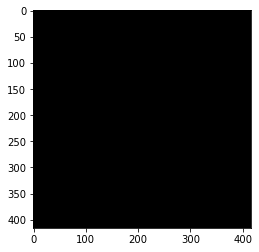

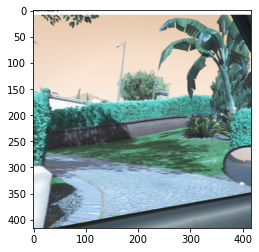

---------------------------------------------------------


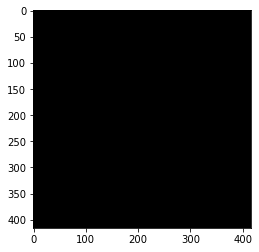

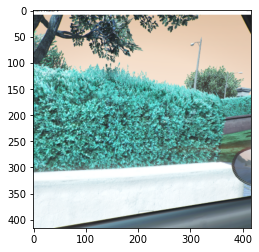

---------------------------------------------------------


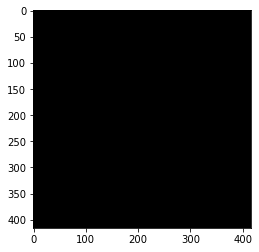

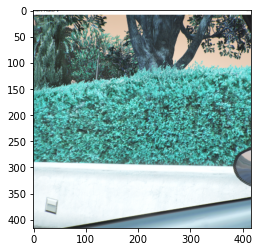

---------------------------------------------------------


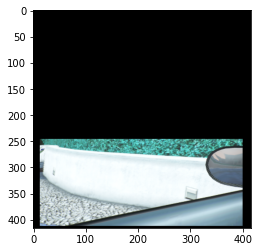

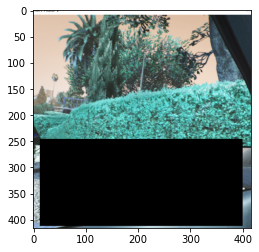

---------------------------------------------------------


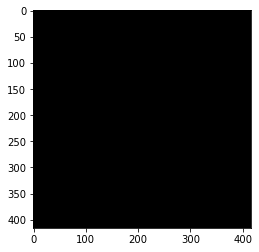

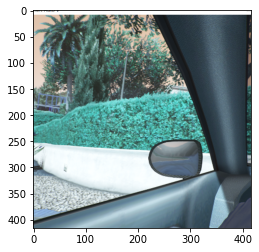

---------------------------------------------------------


In [20]:
'''
Plots images from the data file after object detection and separation
'''

plotImgs = True
if plotImgs:
    with np.load('Data\\training_data1.npz') as data:
        training_data = data['data']
    
    i= 10
    
    train_objects = []
    train_background = []
    for j in range(5):
        temp1,temp2 = get_sub_images(training_data[i][j])
        train_objects.append(temp1)
        train_background.append(temp2)
    
    for j in range(5):
        plt.imshow(cv2.cvtColor(train_objects[j], cv2.COLOR_BGR2RGB))
        plt.show()
        plt.imshow(cv2.cvtColor(train_background[j], cv2.COLOR_BGR2RGB))
        plt.show()
        print('---------------------------------------------------------')

This function is used to count the number of instances per class in a set:

In [ ]:
#TODO: Rewrite function to use one bit hot encoded values

def number_instances_per_class(data):
    
    nonekey = []
    A = []
    D = []
    W = []
    S = []
    
    AD = []
    AW = []
    AS = []
    DW =[]
    DS = []
    WS =[]
    
    ADW = []
    AWS =[]
    ADS = []
    DWS = []
    
    ASWS = []
    
    np.random.shuffle(data)
    
    for d in data:
        if np.array_equal(d, [0,0,0,0]):
            nonekey.append(d)
        elif np.array_equal(d, [1,0,0,0]):
            A.append(d)
        elif np.array_equal(d, [0,1,0,0]):
            D.append(d)
        elif np.array_equal(d , [0,0,1,0]):
            W.append(d)
        elif np.array_equal(d , [0,0,0,1]):
            S.append(d)
        elif np.array_equal(d , [1,1,0,0]):
            AD.append(d)
        elif np.array_equal(d , [1,0,1,0]):
            AW.append(d)
        elif np.array_equal(d , [1,0,0,1]):
            AS.append(d)
        elif np.array_equal(d , [0,1,1,0]):
            DW.append(d)
        elif np.array_equal(d , [0,1,0,1]):
            DS.append(d)
        elif np.array_equal(d , [0,0,1,1]):
            WS.append(d)
        elif np.array_equal(d , [1,1,1,0]):
            ADW.append(d)
        elif np.array_equal(d , [1,1,0,1]):
            AWS.append(d)
        elif np.array_equal(d , [1,1,0,1]):
            ADS.append(d)
        elif np.array_equal(d , [0,1,1,1]):
            DWS.append(d)
        elif np.array_equal(d , [1,1,1,1]):
            ASWS.append(d)
    return [nonekey,A,D,W,S,AW,AS,DW,DS]
    


This function will balance the number of instances of the classes in a set by deleting extra instances after shuffling:

In [ ]:
def balance_data(data_in_clases):
    balanced_data = []
    data_in_clases.sort(key=len)
    max_len = len(data_in_clases[0])
        
    for data in data_in_clases:
        if len(data) > max_len:
            data=data[:max_len]
        for d in data:
            balanced_data.append(d)
        
    np.random.shuffle(balanced_data)
    
    return balanced_data
    

For debug purposes:

In [ ]:
debug = True
if debug:
    with np.load('Data\\training_data_test.npz') as data:
        images = data['data']
        labels = data['labels']

    number = number_instances_per_class(labels)
    print('none: ' + str(len(number[0])))
    print('A: ' + str(len(number[1])))
    print('D ' + str(len(number[2])))
    print('W ' + str(len(number[3])))
    print('S ' + str(len(number[4])))
    print('AW ' + str(len(number[5])))
    print('AS ' + str(len(number[6])))
    print('DW ' + str(len(number[7])))
    print('DS ' + str(len(number[8])))

    #TODO: re-implement data balancing
    balanced_data = balance_data(number)
    number = number_instances_per_class(balanced_data)
    print('none: ' + str(len(number[0])))
    print('A: ' + str(len(number[1])))
    print('D ' + str(len(number[2])))
    print('W ' + str(len(number[3])))
    print('S ' + str(len(number[4])))
    print('AW ' + str(len(number[5])))
    print('AS ' + str(len(number[6])))
    print('DW ' + str(len(number[7])))
    print('DS ' + str(len(number[8])))


# 3. Define the model

We will define the model to use in our training, please select the model you want to use in the cell bellow (the models are described in the "Definition of the DNN" of the [documentation](https://github.com/eritzyg/GTAV-Self-driving-car#documentation)):

In [ ]:
# Select the model to use:
# 'CNN+MPL' : Convolutional neural network with multi layer perceptron.
# 'CNN+RNN' : Convolutional neural network with recurrent neural network.
# 'YOLO'    : Processes the objects and the background seperately 
selected_model = 'YOLO'

And now we define the corresponding model:

In [ ]:
if selected_model == 'CNN+RNN':
    model = Sequential()

    model.add(InputLayer(input_shape=(5, 270, 480, 3)))

    model.add(TimeDistributed(Convolution2D(32, (4,4), data_format='channels_last')))
    model.add(TimeDistributed(Activation('relu')))
    print(model.output_shape)

    model.add(TimeDistributed(Convolution2D(32, (4,4), data_format='channels_last')))
    model.add(TimeDistributed(Activation('relu')))
    print(model.output_shape)

    model.add(TimeDistributed(MaxPooling2D(pool_size=(5, 5), data_format='channels_last')))
    model.add(TimeDistributed(Dropout(0.25)))
    print(model.output_shape)

    model.add(TimeDistributed(Convolution2D(16, (3,3), data_format='channels_last')))
    model.add(TimeDistributed(Activation('relu')))
    print(model.output_shape)


    model.add(TimeDistributed(MaxPooling2D(pool_size=(5, 5), data_format='channels_last')))
    model.add(TimeDistributed(Dropout(0.25)))
    print(model.output_shape)

    model.add(TimeDistributed(Flatten()))
    print(model.output_shape)

    model.add(GRU(256, kernel_initializer=initializers.RandomNormal(stddev=0.001))) #128
    model.add(Dropout(0.25))
    print(model.output_shape)

    model.add(Dense(100))
    print(model.output_shape)

    model.add(Dense(80))
    print(model.output_shape)

    model.add(Dense(40))
    print(model.output_shape)

    model.add(Dense(9, activation='sigmoid'))
    print(model.output_shape)

    opt = optimizers.RMSprop(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy']) 

In [ ]:
if selected_model == 'CNN+MLP':
    model = Sequential()

    model.add(InputLayer(input_shape=(5, 270, 480, 3)))

    model.add(TimeDistributed(Convolution2D(16, (4,8), data_format='channels_last')))
    model.add(TimeDistributed(Activation('relu')))
    print(model.output_shape)

    model.add(TimeDistributed(Convolution2D(16, (4,4), data_format='channels_last')))
    model.add(TimeDistributed(Activation('relu')))
    print(model.output_shape)

    model.add(TimeDistributed(MaxPooling2D(pool_size=(5, 5), data_format='channels_last')))
    model.add(TimeDistributed(Dropout(0.25)))
    print(model.output_shape)

    model.add(TimeDistributed(Convolution2D(12, (3,3), data_format='channels_last')))
    model.add(TimeDistributed(Activation('relu')))
    print(model.output_shape)

    model.add(TimeDistributed(MaxPooling2D(pool_size=(5, 5), data_format='channels_last')))
    model.add(TimeDistributed(Dropout(0.25)))
    print(model.output_shape)

    model.add(Flatten())
    print(model.output_shape)

    model.add(Dense(300))
    print(model.output_shape)
    model.add(Dense(100))
    print(model.output_shape)
    print(model.output_shape)
    model.add(Dense(9, activation='sigmoid'))
    print(model.output_shape)

    opt = optimizers.rmsprop(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy']) 

In [ ]:
# Model by Evan Miller
#
# Takes in two inputs corresponding to the images after they have been split into objects and background
# by the YOLO object detection algorithm. These images are processed with a CNN and an RNN+CNN respectively, then they are
# concatenated and fed through some Dense layers for a final prediction.

if selected_model == 'YOLO':
    input1 = tf.keras.Input(shape=(5, 270, 480, 3))
    x1 = TimeDistributed(Convolution2D(16, (4,8), data_format='channels_last'))(input1)
    x1 = TimeDistributed(Activation('relu'))(x1)
    x1 = TimeDistributed(Convolution2D(16, (4,4), data_format='channels_last'))(x1)
    x1 = TimeDistributed(Activation('relu'))(x1)
    x1 = TimeDistributed(MaxPooling2D(pool_size=(5, 5), data_format='channels_last'))(x1)
    x1 = TimeDistributed(Dropout(0.25))(x1)
    x1 = TimeDistributed(Convolution2D(12, (3,3), data_format='channels_last'))(x1)
    x1 = TimeDistributed(Activation('relu'))(x1)
    x1 = TimeDistributed(MaxPooling2D(pool_size=(5, 5), data_format='channels_last'))(x1)
    x1 = TimeDistributed(Dropout(0.25))(x1)
    x1 = Flatten()(x1)
    x1 = Dense(300)(x1)
    x1 = Dense(100)(x1)
    #x1 = Dense(9, activation='sigmoid')(x1)
    x1 = Model(inputs=input1,outputs=x1)
    
    input2 = tf.keras.Input(shape=(5, 270, 480, 3))
    x2 = TimeDistributed(Convolution2D(32, (4,4), data_format='channels_last'))(input2)
    x2 = TimeDistributed(Activation('relu'))(x2)
    x2 = TimeDistributed(Convolution2D(32, (4,4), data_format='channels_last'))(x2)
    x2 = TimeDistributed(Activation('relu'))(x2)
    x2 = TimeDistributed(MaxPooling2D(pool_size=(5, 5), data_format='channels_last'))(x2)
    x2 = TimeDistributed(Dropout(0.25))(x2)
    x2 = TimeDistributed(Convolution2D(16, (3,3), data_format='channels_last'))(x2)
    x2 = TimeDistributed(Activation('relu'))(x2)
    x2 = TimeDistributed(MaxPooling2D(pool_size=(5, 5), data_format='channels_last'))(x2)
    x2 = TimeDistributed(Dropout(0.25))(x2)
    x2 = TimeDistributed(Flatten())(x2)
    x2 = GRU(256, kernel_initializer=initializers.RandomNormal(stddev=0.001))(x2)
    x2 = Dropout(0.25)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(100)(x2)
    #x2 = Dense(80)(x2)
    #x2 = Dense(40)(x2)
    #x2 = Dense(9, activation='sigmoid')(x2)
    x2 = Model(inputs=input2,outputs=x2)
    
    combined = concatenate([x1.output,x2.output])
    out = Dense(80)(combined)
    out = Dense(40)(out)
    out = Dense(9, activation='sigmoid')(out)
    
    model = Model(inputs=[x1.input,x2.input], outputs=out)

In [ ]:
model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])
model.summary()

# 4. Train

Now we will define some functions to reshape the data according to the input of our model:

In [ ]:
#Determine value range for images from the game. 

def reshape_custom_X(data, verbose = 1):
    reshaped = np.zeros((data.shape[0], 5, 270, 480, 3), dtype=np.float32)
    for i in range(0, data.shape[0]):
        for j in range(0, 5):
            if (verbose == 1):
                clear_output(wait=True)
                stdout.write('Reshaped image: ' + str(i))
                stdout.flush()
            reshaped[i][j] = data[i][j]/255.
            
    return reshaped

def reshape_custom_y(data):
    reshaped = np.zeros((data.shape[0], 9), dtype=np.float32)
    for i in range(0, data.shape[0]):
        if np.array_equal(data[i] , [0,0,0,0]):
            reshaped[i][0] = 1.
        elif np.array_equal(data[i] , [1,0,0,0]):
            reshaped[i][1] = 1.
        elif np.array_equal(data[i] , [0,1,0,0]):
            reshaped[i][2] = 1.
        elif np.array_equal(data[i] , [0,0,1,0]):
            reshaped[i][3] = 1.
        elif np.array_equal(data[i] , [0,0,0,1]):
            reshaped[i][4] = 1.
        elif np.array_equal(data[i] , [1,0,1,0]):
            reshaped[i][5] = 1.
        elif np.array_equal(data[i] , [1,0,0,1]):
            reshaped[i][6] = 1.
        elif np.array_equal(data[i] , [0,1,1,0]):
            reshaped[i][7] = 1.
        elif np.array_equal(data[i] , [0,1,0,1]):
            reshaped[i][8] = 1.
    return reshaped

These functions will help for picking the number of batches and the start and end indexes:

In [ ]:
def get_num_batches(length, BATCH_SIZE):
    if (int(length/BATCH_SIZE)*BATCH_SIZE == length):
        return int(length/BATCH_SIZE)
    else:
        return int(length/BATCH_SIZE)+1

def get_start_end(iteration, BATCH_SIZE, max_length):
    start = iteration*BATCH_SIZE
    if (start > max_length):
        print("ERROR: Check iterations made! Must be wrong")
        return -1, -1
    end = (iteration+1)*BATCH_SIZE
    if (end > max_length):
        end = max_length
    return start, end

And now we run the training process, the accuracy can be seen after each epoch (all the inputs will be saved to a "log.txt" file, so don't worry if you miss out some output). Also remember to change the path to the same path where you saved the dataset:

In [ ]:
log.openlog()

# Define the sizes and epoches
BATCH_SIZE = 10
TEST_BATCH_SIZE = 10
n_epochs = 6

# This path will be the path used to load the dataset files!
files = glob.glob("Data\\*.npz")


actual_file = 0
acc_for_files = []
for fil in files:
    actual_file = actual_file + 1
    log.output("\n Loading input: "+fil)
    with np.load(fil) as data:
        training_data_images = data['data']
        training_data_labels = data['labels']

    #print("\n Balancing data...")
    #number = number_instances_per_class(training_data)
    #training_data = np.array(balance_data(number))
    
    log.output("\n Reshaping data...")
    
    to_shuffle = list(zip(training_data_images, training_data_labels))
    np.random.shuffle(to_shuffle)
    training_data_images, training_data_labels = zip(*to_shuffle)
    
    #np.random.shuffle(training_data)
    train_x = training_data_images[0:int(len(training_data_images)*0.90)]
    train_y = training_data_labels[0:int(len(training_data_labels)*0.90)]
    test_x = training_data_images[int(len(training_data_images)*0.90):]
    test_y = training_data_labels[int(len(training_data_labels)*0.90):]
    #test = training_data[int(len(training_data)*0.90):len(training_data)]
    del training_data_images, training_data_labels
    
    log.output("\n Executing Object Detection...")
    
    train_objects = []
    train_background = []
    for i in range(len(train_x)):
        train_objects.append([])
        train_background.append([])
        for j in range(5):
            temp1,temp2 = get_sub_images(train_x[i][j])
            train_objects[i].append(temp1)
            train_background[i].append(temp2)
    
    test_objects = []
    test_background = []
    for i in range(len(test_x)):
        test_objects.append([])
        test_background.append([])
        for j in range(5):
            temp1,temp2 = get_sub_images(test_x[i][j])
            test_objects[i].append(temp1)
            test_background[i].append(temp2)
    
    X_train = [reshape_custom_X(np.array(train_objects)), reshape_custom_X(np.array(train_background))]
    y_train = reshape_custom_y(np.array(train_y))
    X_test = [reshape_custom_X(np.array(test_objects)), reshape_custom_X(np.array(test_background))]
    y_test= reshape_custom_y(np.array(test_y))
    del train_x, train_y, test_x, test_y, test_objects, test_background, train_objects, train_background
    
    log.output("\n Training...")
    data_length = len(X_train[0])
    n_batch = get_num_batches(data_length, BATCH_SIZE)
    for epoch in range(n_epochs):
        for iteration in range(n_batch):
            start, end = get_start_end(iteration, BATCH_SIZE, data_length)
            model.fit(x=[X_train[0][start:end], X_train[1][start:end]], y=y_train[start:end], epochs=1, verbose=0)
            clear_output(wait=True)
            log.output('\n => File : ' + str(actual_file) + ' of ' + str(len(files)))
            log.output('\n ==> EPOCH : ' + str(epoch+1) + ' of ' + str(n_epochs))
            log.output('\n ===> Iteration: ' + str(iteration+1) + ' of ' + str(n_batch))
            score = model.evaluate((X_train[0][start:end], X_train[1][start:end]), y_train[start:end], verbose=0)
            log.output("\n Train batch accuracy: %.2f%%" % (score[1]*100))
            stdout.flush()
        prec = np.zeros((9))
        for i in range(len(y_test)):
            p = np.argmax(model.predict((X_test[0][i:i+1], X_test[1][i:i+1])), axis=1)
            prec[p] = prec[p] + 1
        log.output("\n ==> Predictions:"+str(prec))
        stdout.flush()   
    total_acc = 0.0
    num = 0
    data_length = len(X_test[0])
    n_batch = get_num_batches(data_length, TEST_BATCH_SIZE)
    for iteration in range(n_batch):
        start, end = get_start_end(iteration, TEST_BATCH_SIZE, data_length)
        score = model.evaluate((X_test[0][start:end], X_test[1][start:end]), y_test[start:end], verbose=0)
        log.output("\n => Batch %s: %.2f%%" % (model.metrics_names[1], score[1]*100))
        total_acc = total_acc + score[1]
        num = num + 1
    total_acc = total_acc/float(num)
    log.output("\n ==> Total acc for file %s: %.2f%%" % (fil, total_acc*100))
    acc_for_files.append(total_acc*100)


    prec = np.zeros((9))
    for i in range(len(y_test)):
        p = np.argmax(model.predict((X_test[0][i:i+1], X_test[1][i:i+1])), axis=1)
        prec[p] = prec[p] + 1
    log.output("\n ==> Predictions:"+str(prec))
    time.sleep(5)

for acc in range(len(acc_for_files)):
    log.output("\n ==> Total acc after file %d: %.2f%%" % (acc, acc_for_files[acc]))
    
    
log.closelog()

In [ ]:
print(start,end)
print(len(X_train[0]))
print(np.array(X_test).shape)
print("objects", X_test[0][:, start:end], "backgrounds", X_test[1][:, start:end], "labels", y_test[start:end])
print("prediction ratings", model.evaluate((X_test[0][start:end], X_test[1][start:end]), y_test[start:end], verbose=1))
print(model.metrics_names)

Now we save the learned network:

In [ ]:
import h5py as h5py
#model.save('Model\\'+selected_model)
model.save('Model\\'+'nonsense')

In [ ]:
'''
Plots images from the data file after object detection and separation, then executes and prints a prediction on the sequence
'''

#model = load_model('Data\\'+selected_model)
model = load_model('Model\\'+'nonsense')

plotImgs = True
if plotImgs:
    with np.load('Data\\training_data_test.npz') as data:
        training_data = data['data']
    
    i= 10
    
    train_objects = []
    train_background = []
    for j in range(5):
        temp1,temp2 = get_sub_images(training_data[i][j])
        train_objects.append(temp1)
        train_background.append(temp2)
    
    for j in range(5):
        plt.imshow(cv2.cvtColor(train_objects[j], cv2.COLOR_BGR2RGB))
        plt.show()
        plt.imshow(cv2.cvtColor(train_background[j], cv2.COLOR_BGR2RGB))
        plt.show()
        print('---------------------------------------------------------')
    
    X_test = [reshape_custom_X(np.array([train_objects]), verbose=0), reshape_custom_X(np.array([train_background]), verbose=0)]

    print (np.argmax(model.predict((X_test[0], X_test[1])), axis=1))

# 5. Run our model in the game

Now it is time to test our model in the game, we will reduce the amount of VRAM tensorflow can use so that the game has some VRAM in spare. We will also import the library needed to send inputs to the game:

In [ ]:
# Let the game have some VRAM (needed or the game will crash)
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

# For controlling the game
from inputsHandler import select_key
from tkinter import *

In [ ]:
def key_press(key):
    if key == 1:
        return'A'
    if key == 2:
        return'D'
    if key == 3:
        return'W'
    if key == 4:
        return'S'
    if key == 5:
        return'AW'
    if key == 6:
        return'AS'
    if key == 7:
        return'DW'
    if key == 8:
        return'DS'
    return 'none'

This fuction calculates the Mean Squared Error between 2 images. Is used to detect if the car is stuck somewhere. 

In [ ]:
def mse(imageA, imageB):

    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

We define the run function for our network:

In [ ]:
#Run Configurations
show_current_control = False #It will show a windows with a message indicating if the car is currently be controlled by
                            #Network  or by a Human
    
show_whatAIsees = False #It will show the 5 images that the netowrk uses the predict the output 

enable_evasion = False #If the program detects that the car is not moving (for example because it is stuck facing a wall and
                        #the network is not able to return to the road) It will make the car move backwards for a second.

In [ ]:
def run_IA():
    global fps
    global front_buffer
    global back_buffer
    global seq
    global key_out
    global num
    
    model = load_model('Data\\'+selected_model)
    
    training_data = []
    threads = list()
    th_img = threading.Thread(target=img_thread)
    th_seq = threading.Thread(target=image_sequencer_thread)
    threads.append(th_img)
    threads.append(th_seq)
    th_img.start()
    time.sleep(1)
    th_seq.start()
    time.sleep(4)
    
    last_num = 0
    
    last_time = time.time()
    
    if show_current_control:
        root = Tk()
        var = StringVar()
        var.set('IA CONDUCIENDO')
        l = Label(root, textvariable = var, fg='green', font=("Courier", 44))
        l.pack()

    
    while True:
       
        img_seq = seq.copy()
        while len(img_seq) != 5 or last_num==num:
            del img_seq
            img_seq = seq.copy()
        last_num = num
        array = [img_seq[0],img_seq[1],img_seq[2],img_seq[3],img_seq[4]]
        
        objects = []
        background = []
        for j in range(5):
            temp1,temp2 = get_sub_images(array[j])
            objects.append(temp1)
            background.append(temp2)
        
        
        objects = np.expand_dims(np.array(objects), axis=0)
        background = np.expand_dims(np.array(background), axis=0)
        p = np.argmax(model.predict([objects,background]))
        
        if not 'J' in key_check():
            select_key(p)
            if show_current_control:
                var.set('IA CONDUCIENDO')
                l.config(fg='green')
                root.update()
        else:
            if show_current_control:
                var.set('CONTROL MANUAL')
                l.config(fg='red')
                root.update()

        #This is used to detect if the car is stuck somewhere (for example facing a wall) and the network does not know what to do. It will move the car
        #backward for a second.
        
        if enable_evasion:
            score = mse(img_seq[0],img_seq[4])
            if score < 1000:
                if show_current_control:
                    var.set('MANIOBRA DE EVASIÓN')
                    l.config(fg='blue')
                    root.update()
                select_key(4)
                time.sleep(1)
                if np.random.rand()>0.5:
                    select_key(6)
                else:
                    select_key(8)
                time.sleep(0.2)
                if show_current_control:
                    var.set('IA CONDUCIENDO')
                    l.config(fg='green')
                    root.update()

        time_act = time.time()
        clear_output(wait=True)
        stdout.write('Recording at {} FPS \n'.format(fps))
        stdout.write('Images in sequence {} \n'.format(len(img_seq)))
        stdout.write('Keys pressed: ' + key_press(p[0]) + '\n')
        stdout.write('Actions per second: ' + str(1/(time_act-last_time)) + '\n')
        if enable_evasion:
            stdout.write('Diference from img 1 to img 5: ' + str(score))
        stdout.flush()
        last_time = time.time()
        
        if show_whatAIsees:
            cv2.imshow('window1',np.array(img_seq[0])) 
            cv2.imshow('window2',np.array(img_seq[1]))
            cv2.imshow('window3',np.array(img_seq[2]))
            cv2.imshow('window4',np.array(img_seq[3]))
            cv2.imshow('window5',np.array(img_seq[4]))
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break
     

And now we run the network in the game:

In [ ]:
run_IA()